In [ ]:
%matplotlib inline  
from models.binary_model.binary_model import BinaryModel
from models.ind_model.ind_model import OvAModel
from models.multi_model.multi_model import MultiModel
mags = ["g_mag",  "r_mag", "i_mag", "z_mag", "y_mag",
        "W1_mag", "W2_mag",
        "J_mag", "K_mag", "H_mag"]

model = MultiModel(
       cols = mags, 
       folds = 10,
#        class_labels = ["TDE", "GRB"],
#        folds = 10,     
       transform_features = True,
       balanced_purity = True)
#        lsst_test= True) 

model.run_model()

In [175]:
import pickle

with open(model.dir + '/model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [174]:
model.dir

'/Users/marina/Documents/PhD/research/astro_research/code/thex_model/thex_data/../output/Multiclass_Classifier16'

In [ ]:
import numpy as np
import pandas as pd
X_test_list = [] # All rows in X test (all data) in right order
y_test_label_list = [] # Probs assigned to each class, and label in last column

for data in model.datas:
    X_test_cur, test_probs = data
    X_test_list.append(X_test_cur)
    y_test_label_list.append(test_probs)

X_test = pd.concat(X_test_list)
y_test_label = np.concatenate(y_test_label_list)

In [ ]:
if X_test.shape[0] == y_test_label.shape[0] and y_test_label.shape[0] == model.X.shape[0]:
    
    print("Dimensions correct. " + str(X_test.shape[0]))
else:
    raise ValueError("DIMENSIONS INCORRECT.")

See what percent of SGRB are wrong vs LGRB

In [ ]:
# get all indices FNs vs TP LGRBS and SGRBs
FN_SGRBs_indices = []
TP_SGRBs_indices = []
FN_LGRBs_indices = []
TP_LGRBs_indices = [] 
label_index = len(model.class_labels)
for i, row in X_test.iterrows():
    row = y_test_label[i] 
    
    max_class_prob = np.max(row[: len(row) - 1])
    max_class_index = np.argmax(row[: len(row) - 1])
    max_class_name = model.class_labels[max_class_index]
    if max_class_name == "GRB":
        
        if "SGRB" in row[label_index]: 
            TP_SGRBs_indices.append(i)
        elif "LGRB" in row[label_index]: 
            TP_LGRBs_indices.append(i)
        
    else:
        # Label is GRB but we did not predict it, FN
        if "SGRB" in row[label_index]: 
            FN_SGRBs_indices.append(i)
        elif "LGRB" in row[label_index]:
            FN_LGRBs_indices.append(i) 

C_SGRB = len(TP_SGRBs_indices)/(len(TP_SGRBs_indices) + len(FN_SGRBs_indices))
C_LGRB = len(TP_LGRBs_indices)/(len(TP_LGRBs_indices) + len(FN_LGRBs_indices))

print("Completeness of SGRB: " + str(round(C_SGRB,2)))
print("Completeness of LGRB: " + str(round(C_LGRB,2)))


In [ ]:
# get all indices FNs vs TP GRBs, and plot their feature dists
FN_GRBs_indices = []
TP_GRBs_indices = []
label_index = len(model.class_labels)
for i, row in X_test.iterrows():
    row = y_test_label[i]
    if "GRB" in row[label_index]:
        max_class_prob = np.max(row[: len(row) - 1])
        max_class_index = np.argmax(row[: len(row) - 1])
        max_class_name = model.class_labels[max_class_index]
        
        if max_class_name == "GRB":
            TP_GRBs_indices.append(i)
        else:
            FN_GRBs_indices.append(i)


In [172]:
from thex_data.data_consts import * 
from utilities import utilities as util

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import kstest
import math
from numpy import random

def cust_relabel(labels, class_labels):
    """
    Rename list of labels to be class names.
    """ 
    new_labels = []
    for row_label in labels: 
        for class_name in class_labels:
            if class_name in row_label:
                new_labels.append(class_name) 
                break
    return new_labels


def plot_dist(ax, data, min_value, max_value, color, class_name):
    """
    Plots the normal distribution for given data 
    """
    bins = np.linspace(0, max_value, 50)  
    mean, std = norm.fit(data)
    x = np.linspace(min_value, max_value, 100)
    y = norm.pdf(x, mean, std)
    print(class_name + " mean: " + str(mean) + " stdev: " + str(std))
    ax.plot(x, y, color=color, label=class_name) 
    return mean, std

def plot_classes_feature_dist(ax,  df, feature, min_value, max_value,  class_labels):
    """
    Plots the normal distribution of each transient type in df over 'feature'
    :param model_dir: directory of model to save figure
    :param df: DataFrame with both feature column and TARGET_LABEL column
    :param feature: Name of feature to plot distribution over
    :param class_labels: class labels
    """
    
    bins = np.linspace(0, max_value, 50)
    colors = plt.get_cmap('tab20').colors
    for index, class_name in enumerate(class_labels):
        class_values = df[df[TARGET_LABEL] == class_name][feature].values
        mean, std = plot_dist(ax, class_values, min_value, max_value, colors[index], class_name) 
    
    return mean, std

def plot_binary_classes_feature_dist(ax,  df, feature, min_value, max_value,  class_label):
    """
    Plots the normal distribution of each transient type in df over 'feature'
    :param model_dir: directory of model to save figure
    :param df: DataFrame with both feature column and TARGET_LABEL column
    :param feature: Name of feature to plot distribution over
    :param class_labels: class labels
    """
    
    bins = np.linspace(min_value, max_value, 50)
    colors = plt.get_cmap('tab20').colors

    G = df[df[TARGET_LABEL] == class_label][feature].values
    ax.hist(G, bins, density=True, edgecolor='blue', linewidth=1.6,
           label="GRBs", facecolor='blue', alpha=0.3)
#     mean_g, std_g = plot_dist(ax, G, min_value, max_value, "blue", "GRBs")  
    
    NG = df[df[TARGET_LABEL] != class_label][feature].values 
#     mean_ng, std_ng = plot_dist(ax, NG, min_value, max_value, "green", "Non-GRBs")  
    ax.hist(NG, bins, density=True, edgecolor="green", linewidth=1.6,
           label="Non-GRBs", facecolor="green", alpha=0.3)
     
    D, pvalue = kstest(G, NG)
#     c_alpha = 1.358 # 0.05, 95% confidence
    c_alpha_99 = 1.949 # 0.001 ; 99.9% confidence
    v = c_alpha_99 * math.sqrt((len(G) + len(NG))/(len(G) * len(NG)))
#     print("Length of GRBs " + str(len(G)))
#     print("Length of non-GRBs " + str(len(NG)))
    if D > v:
        print("Distributions ARE different.")
        return D
    return None
    # Check if distributions are statistically different
    



Feature: J_mag


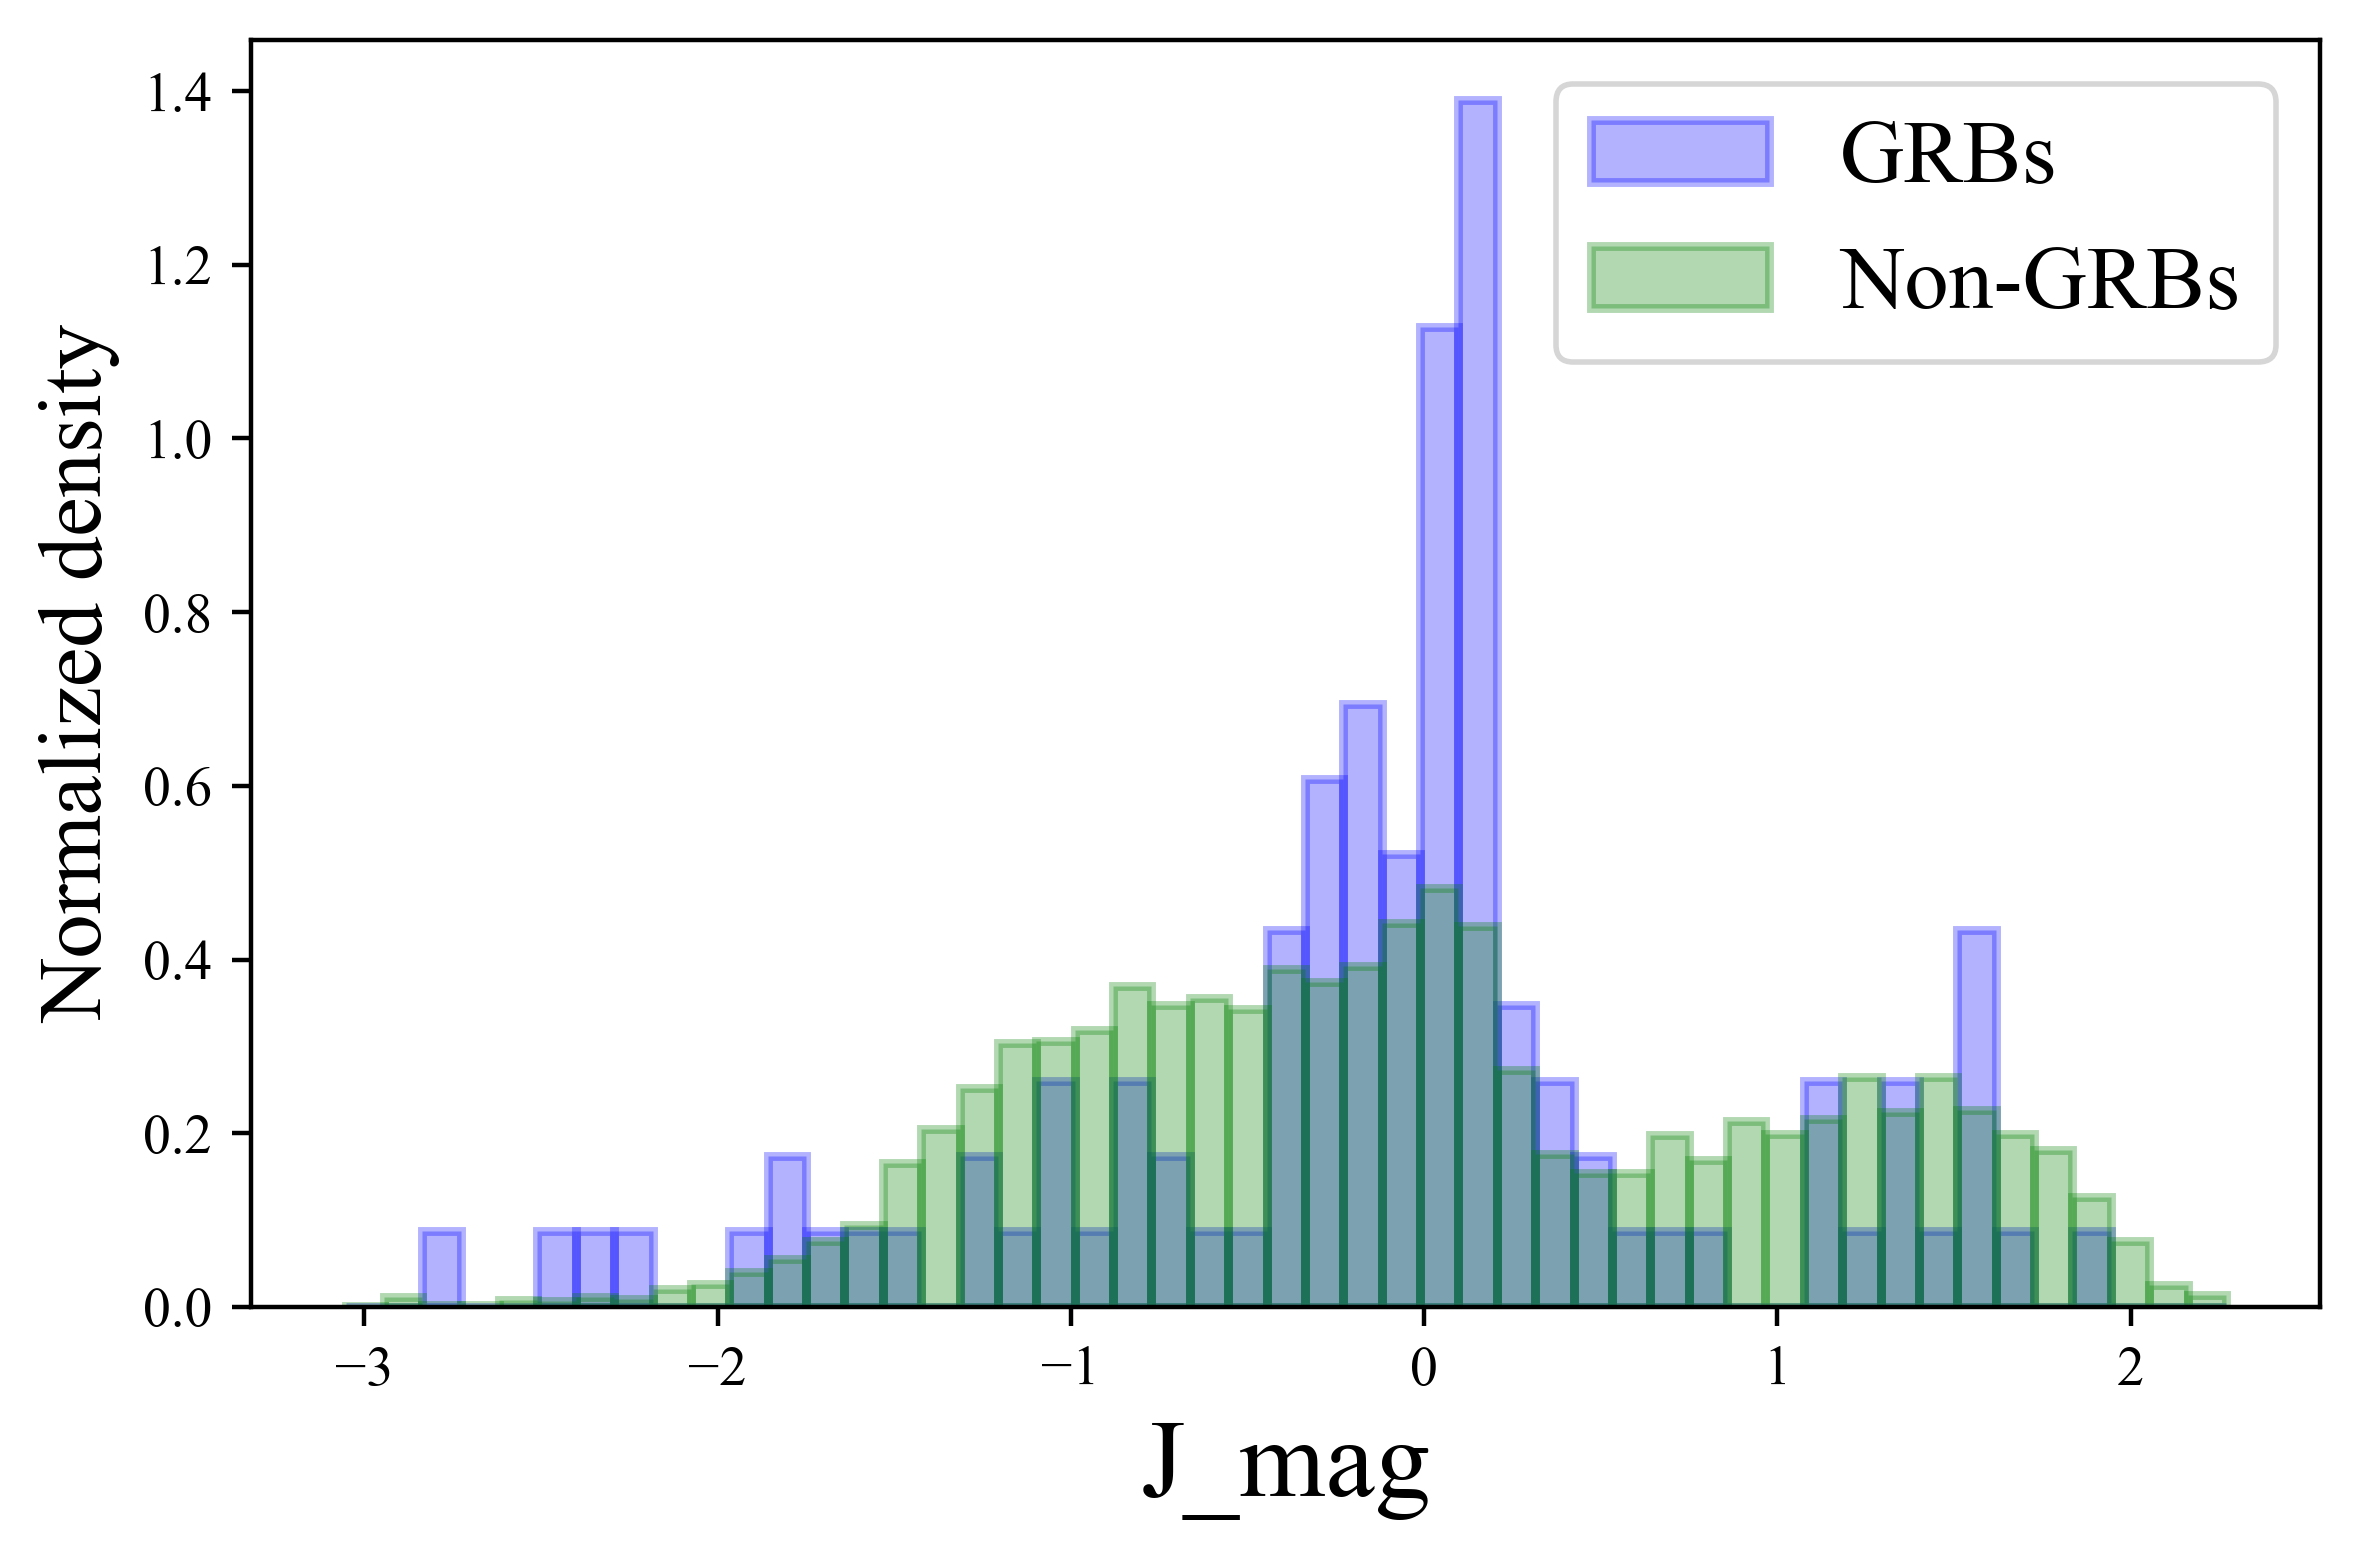



Feature: K_mag


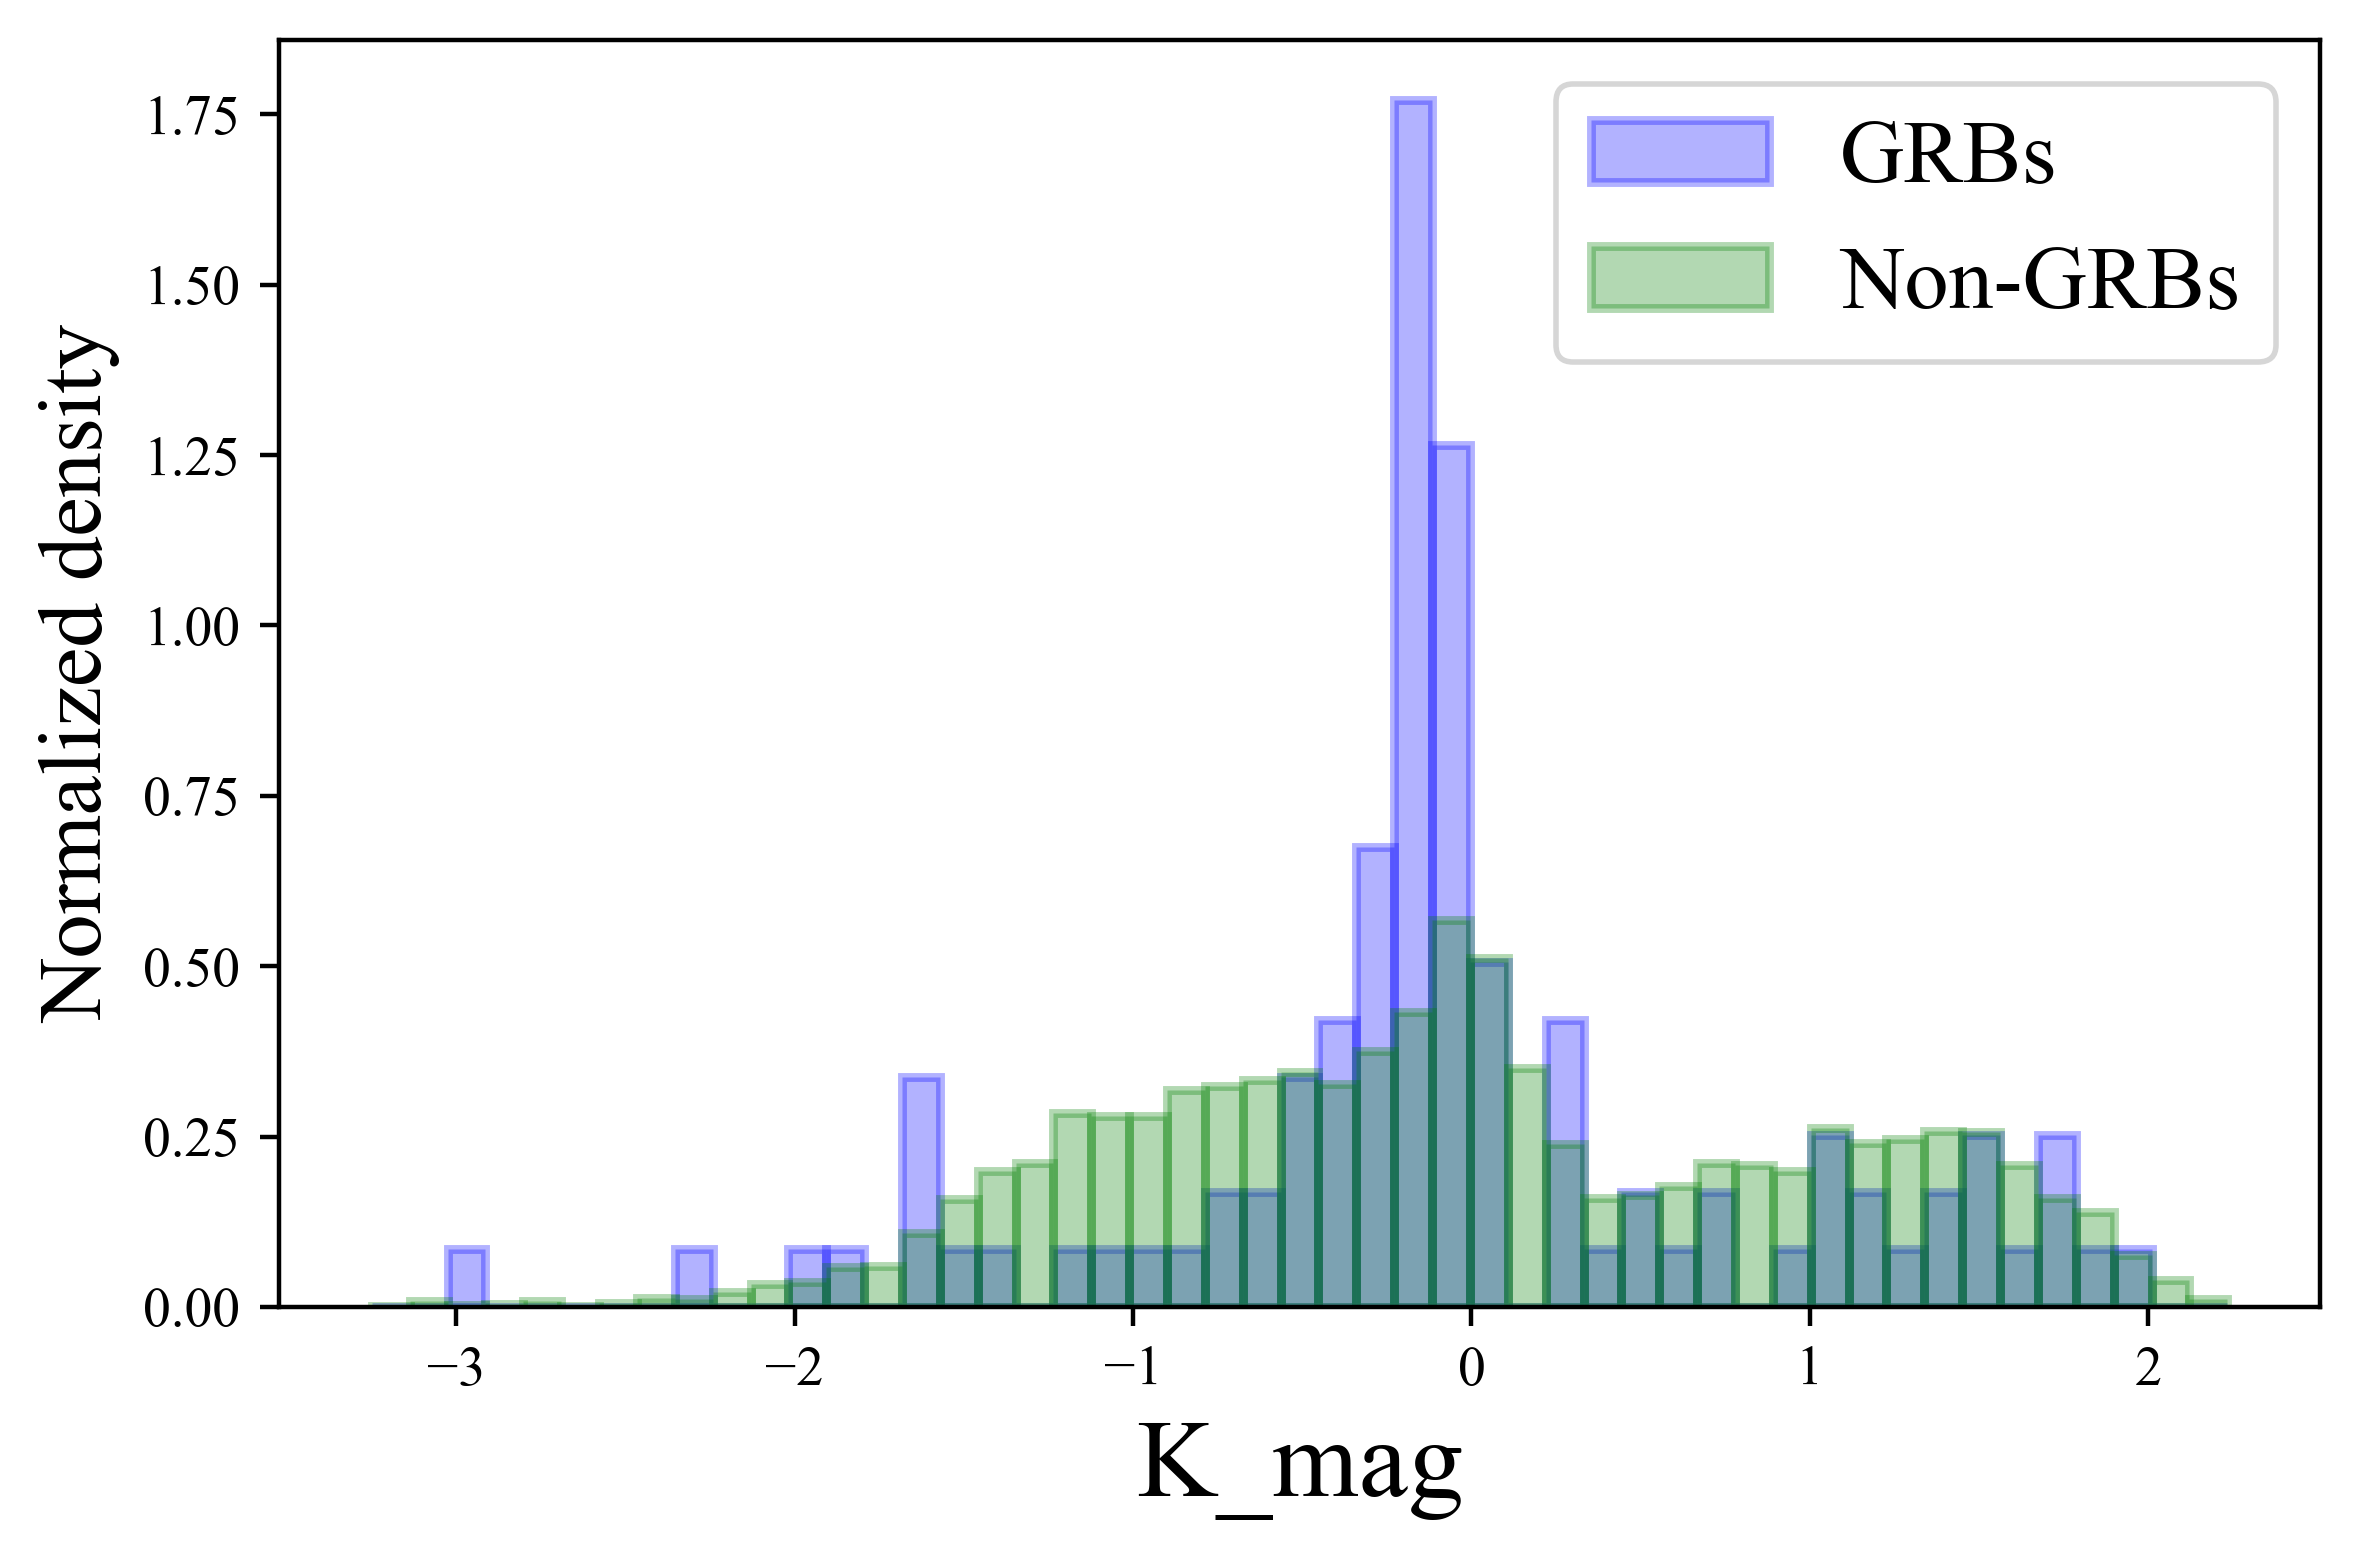



Feature: y_mag
Distributions ARE different.


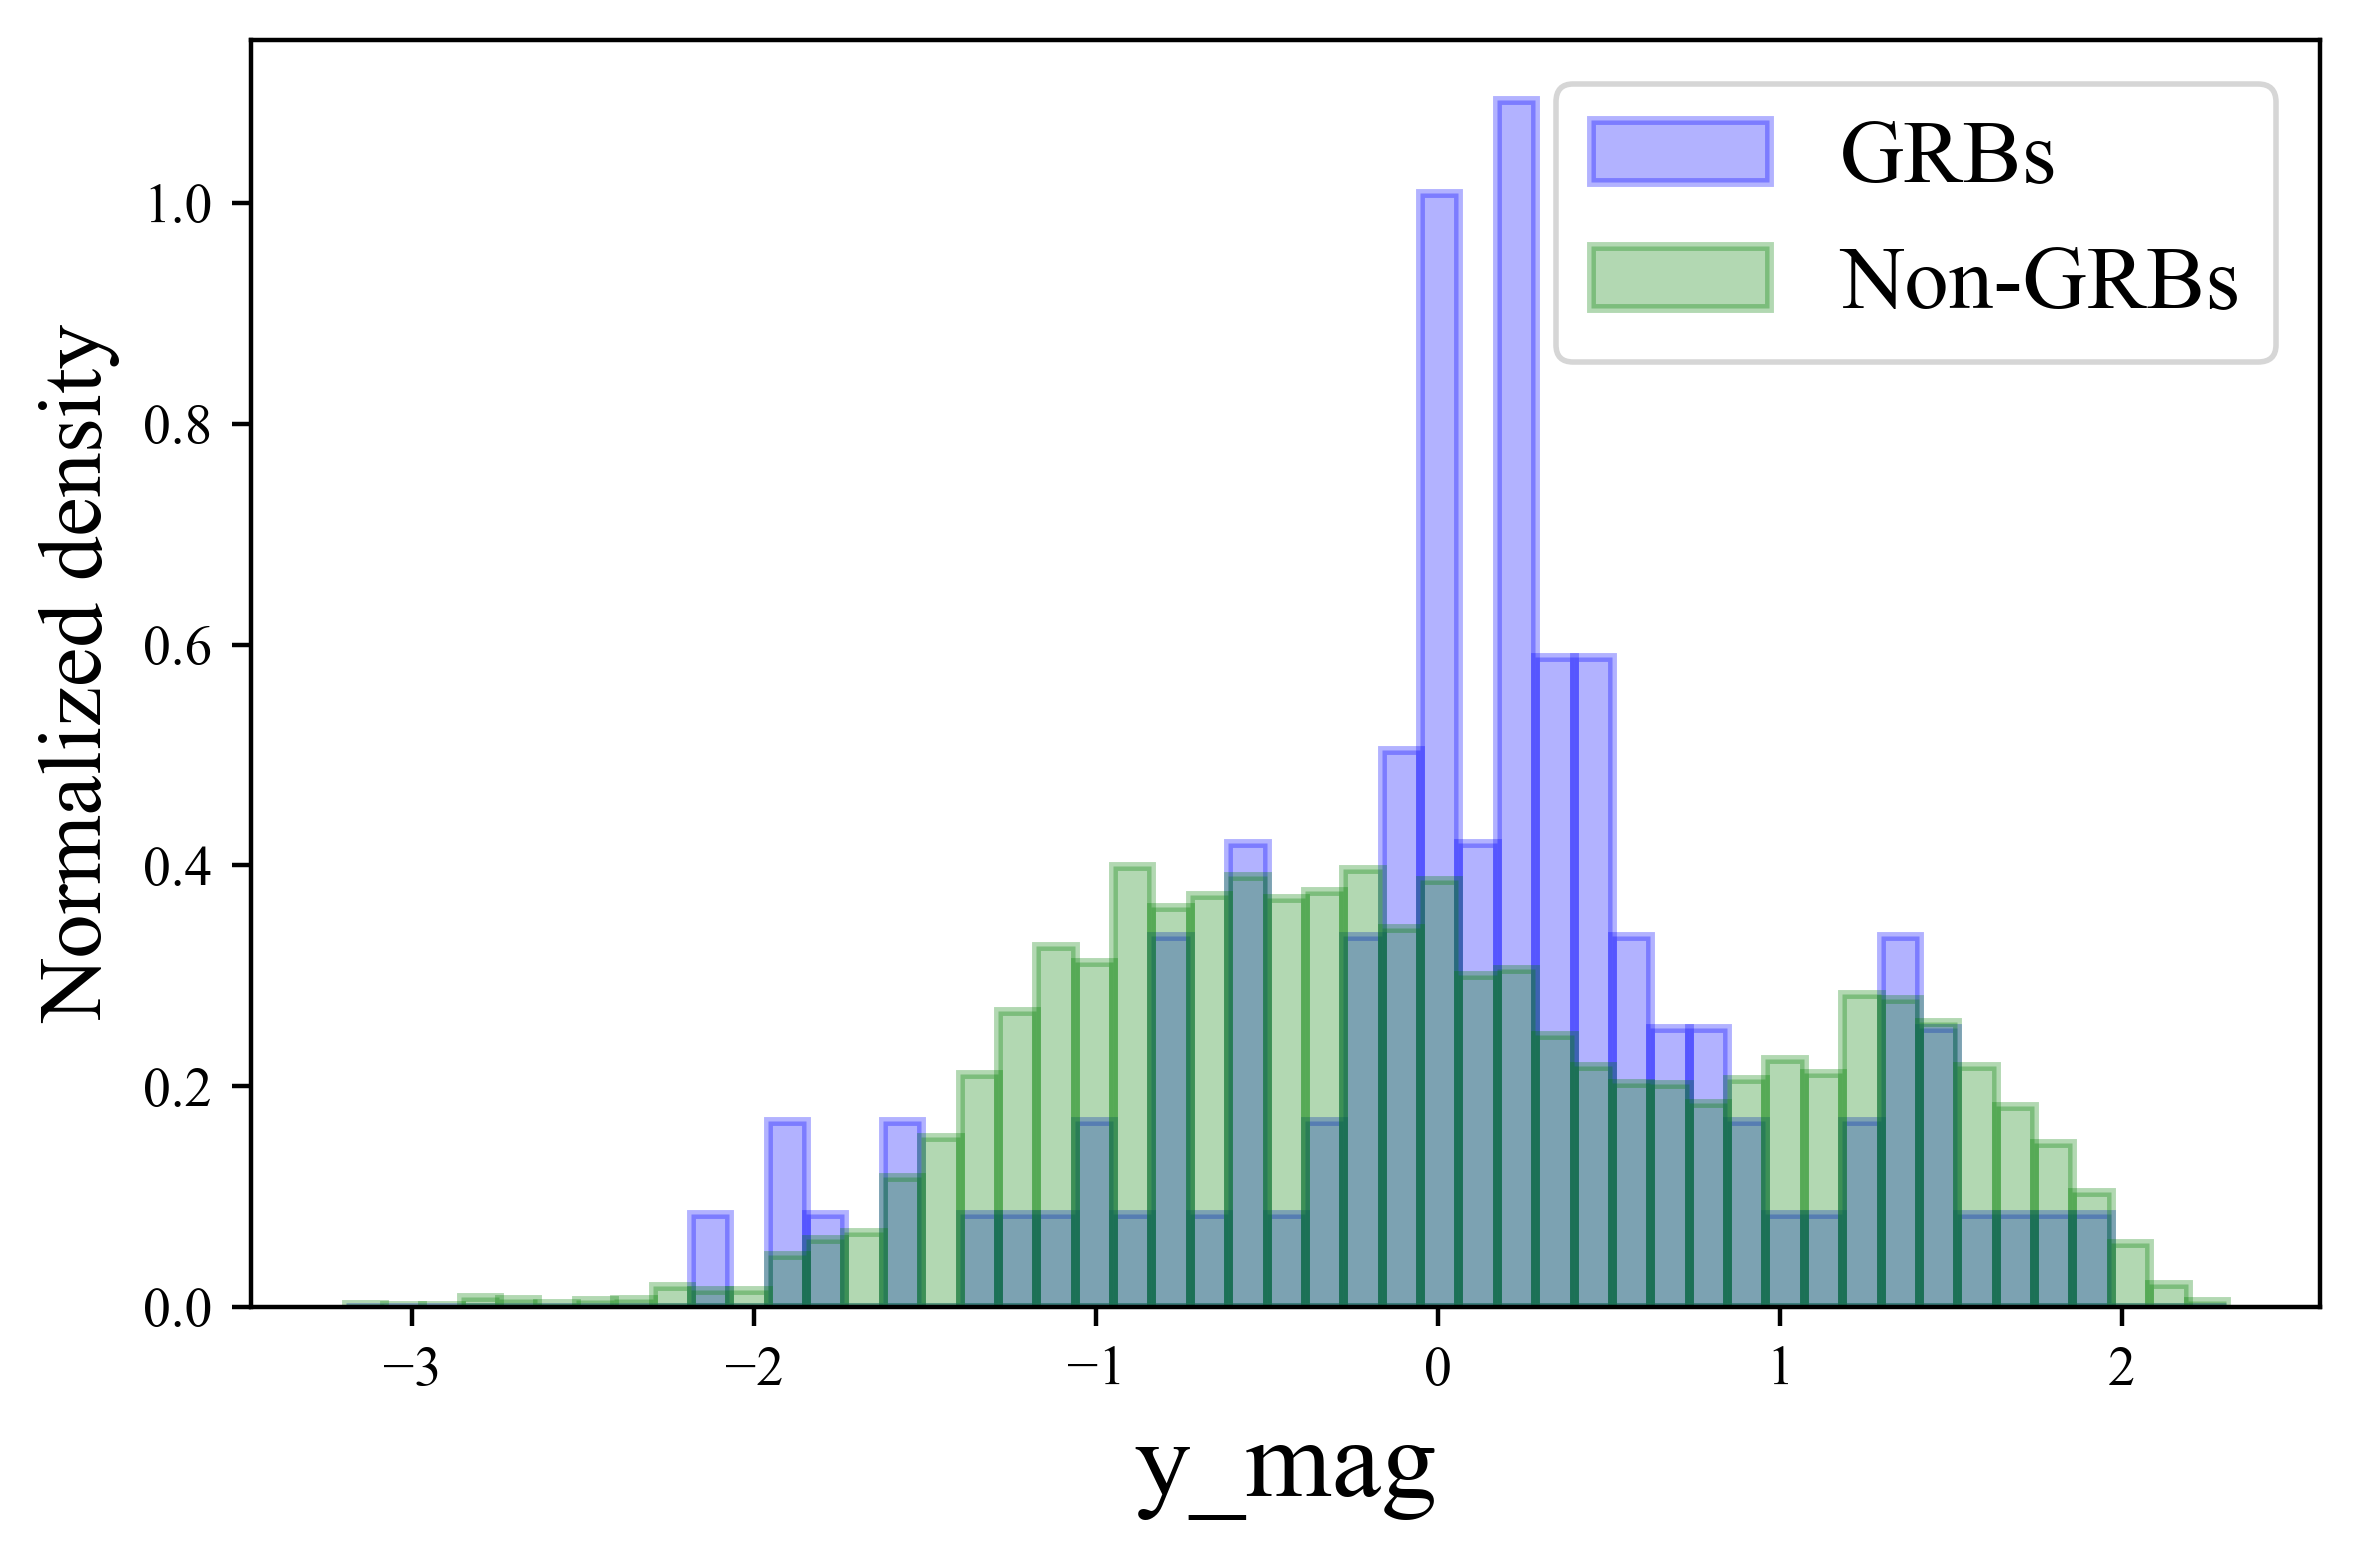



Feature: r_mag


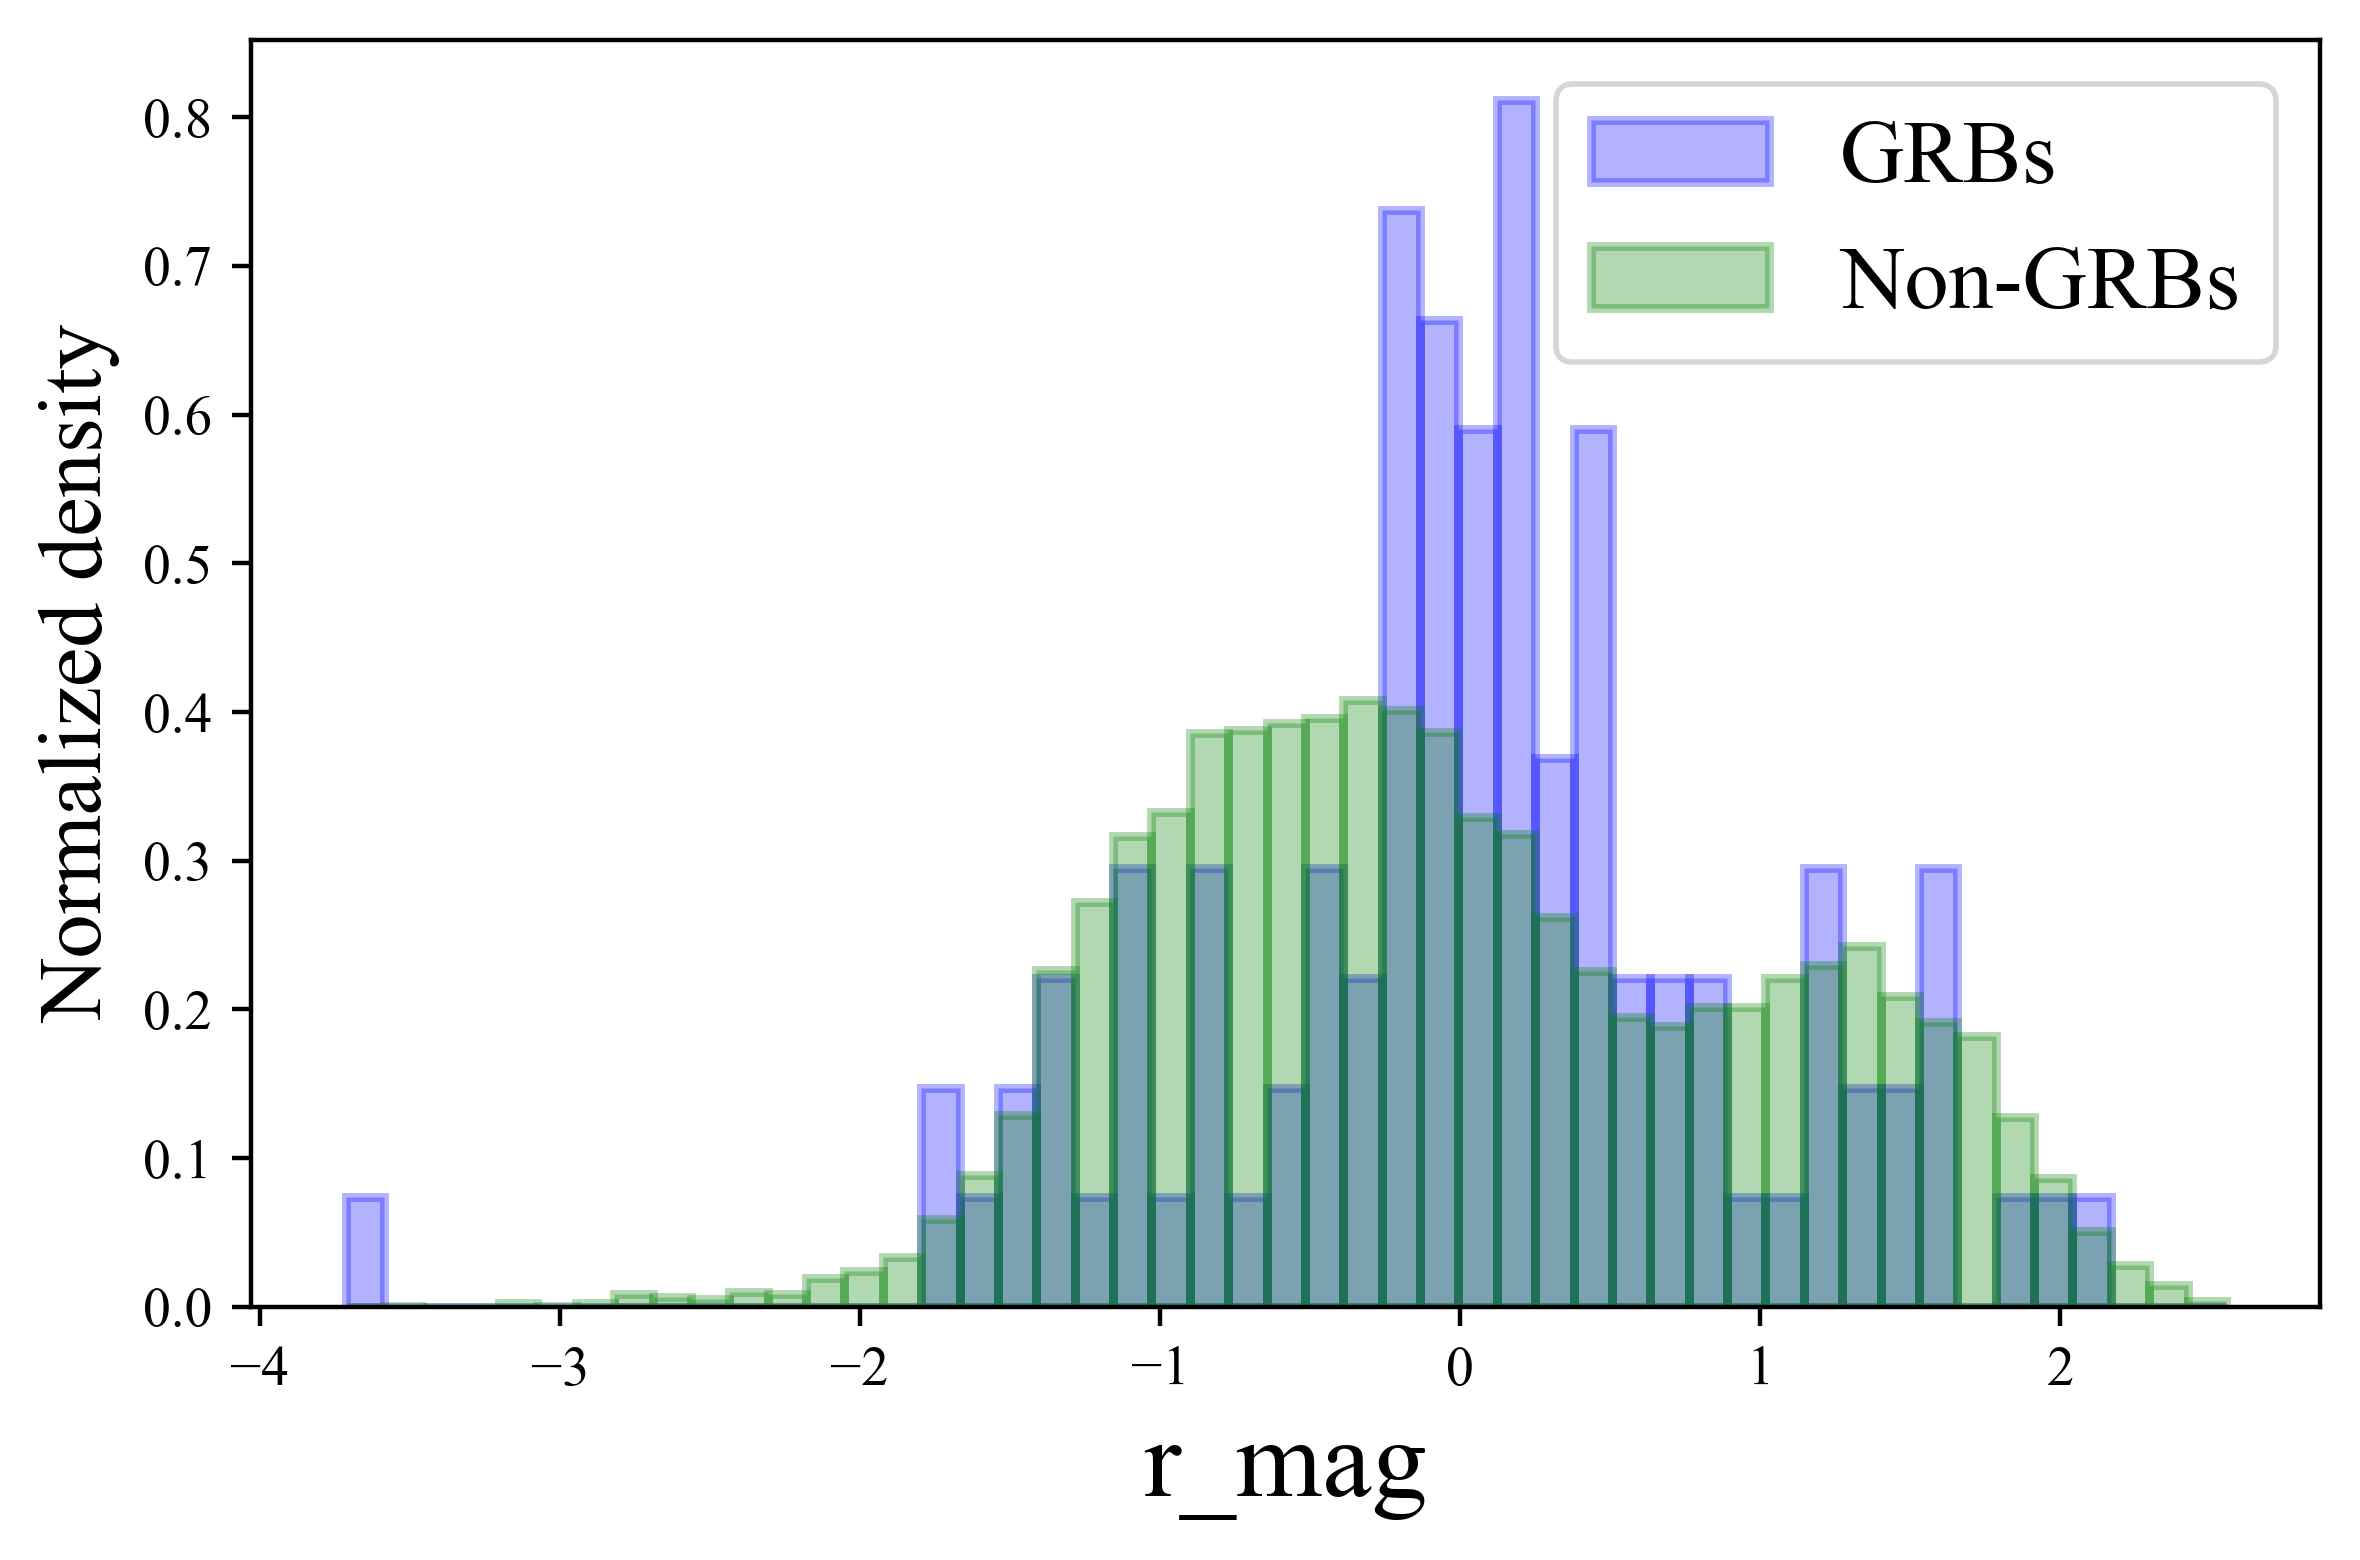



Feature: H_mag


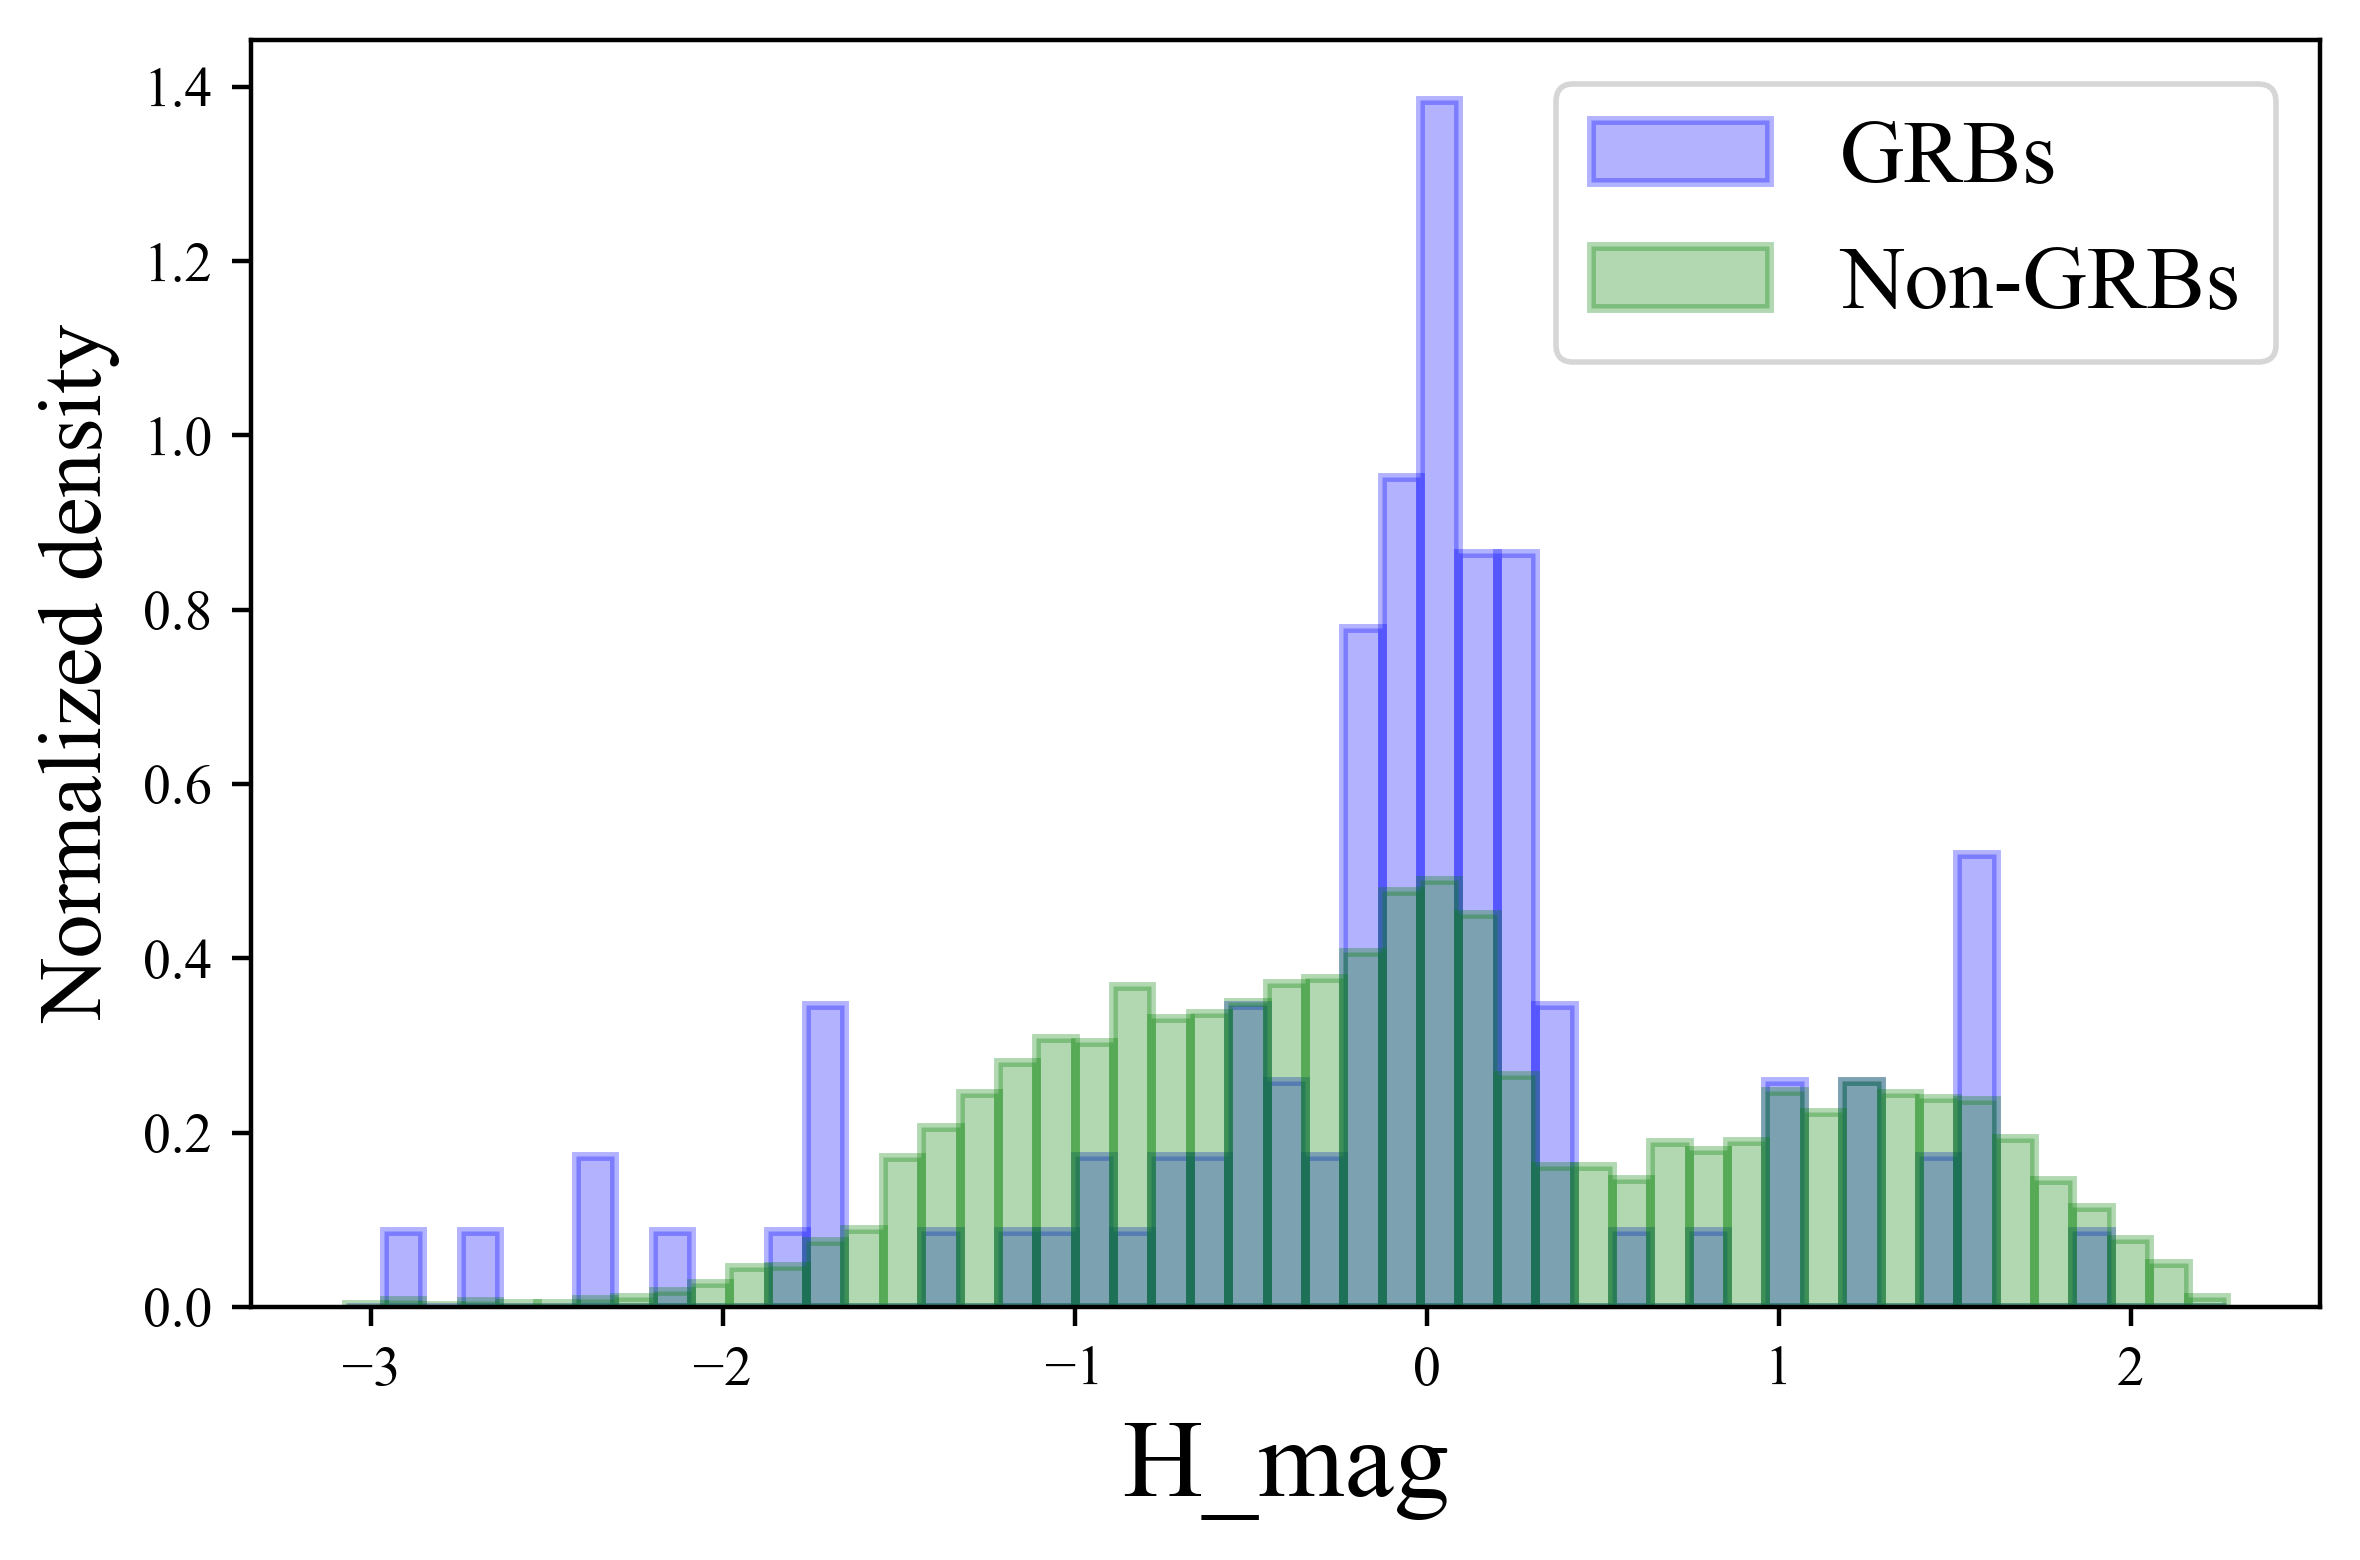



Feature: W1_mag
Distributions ARE different.


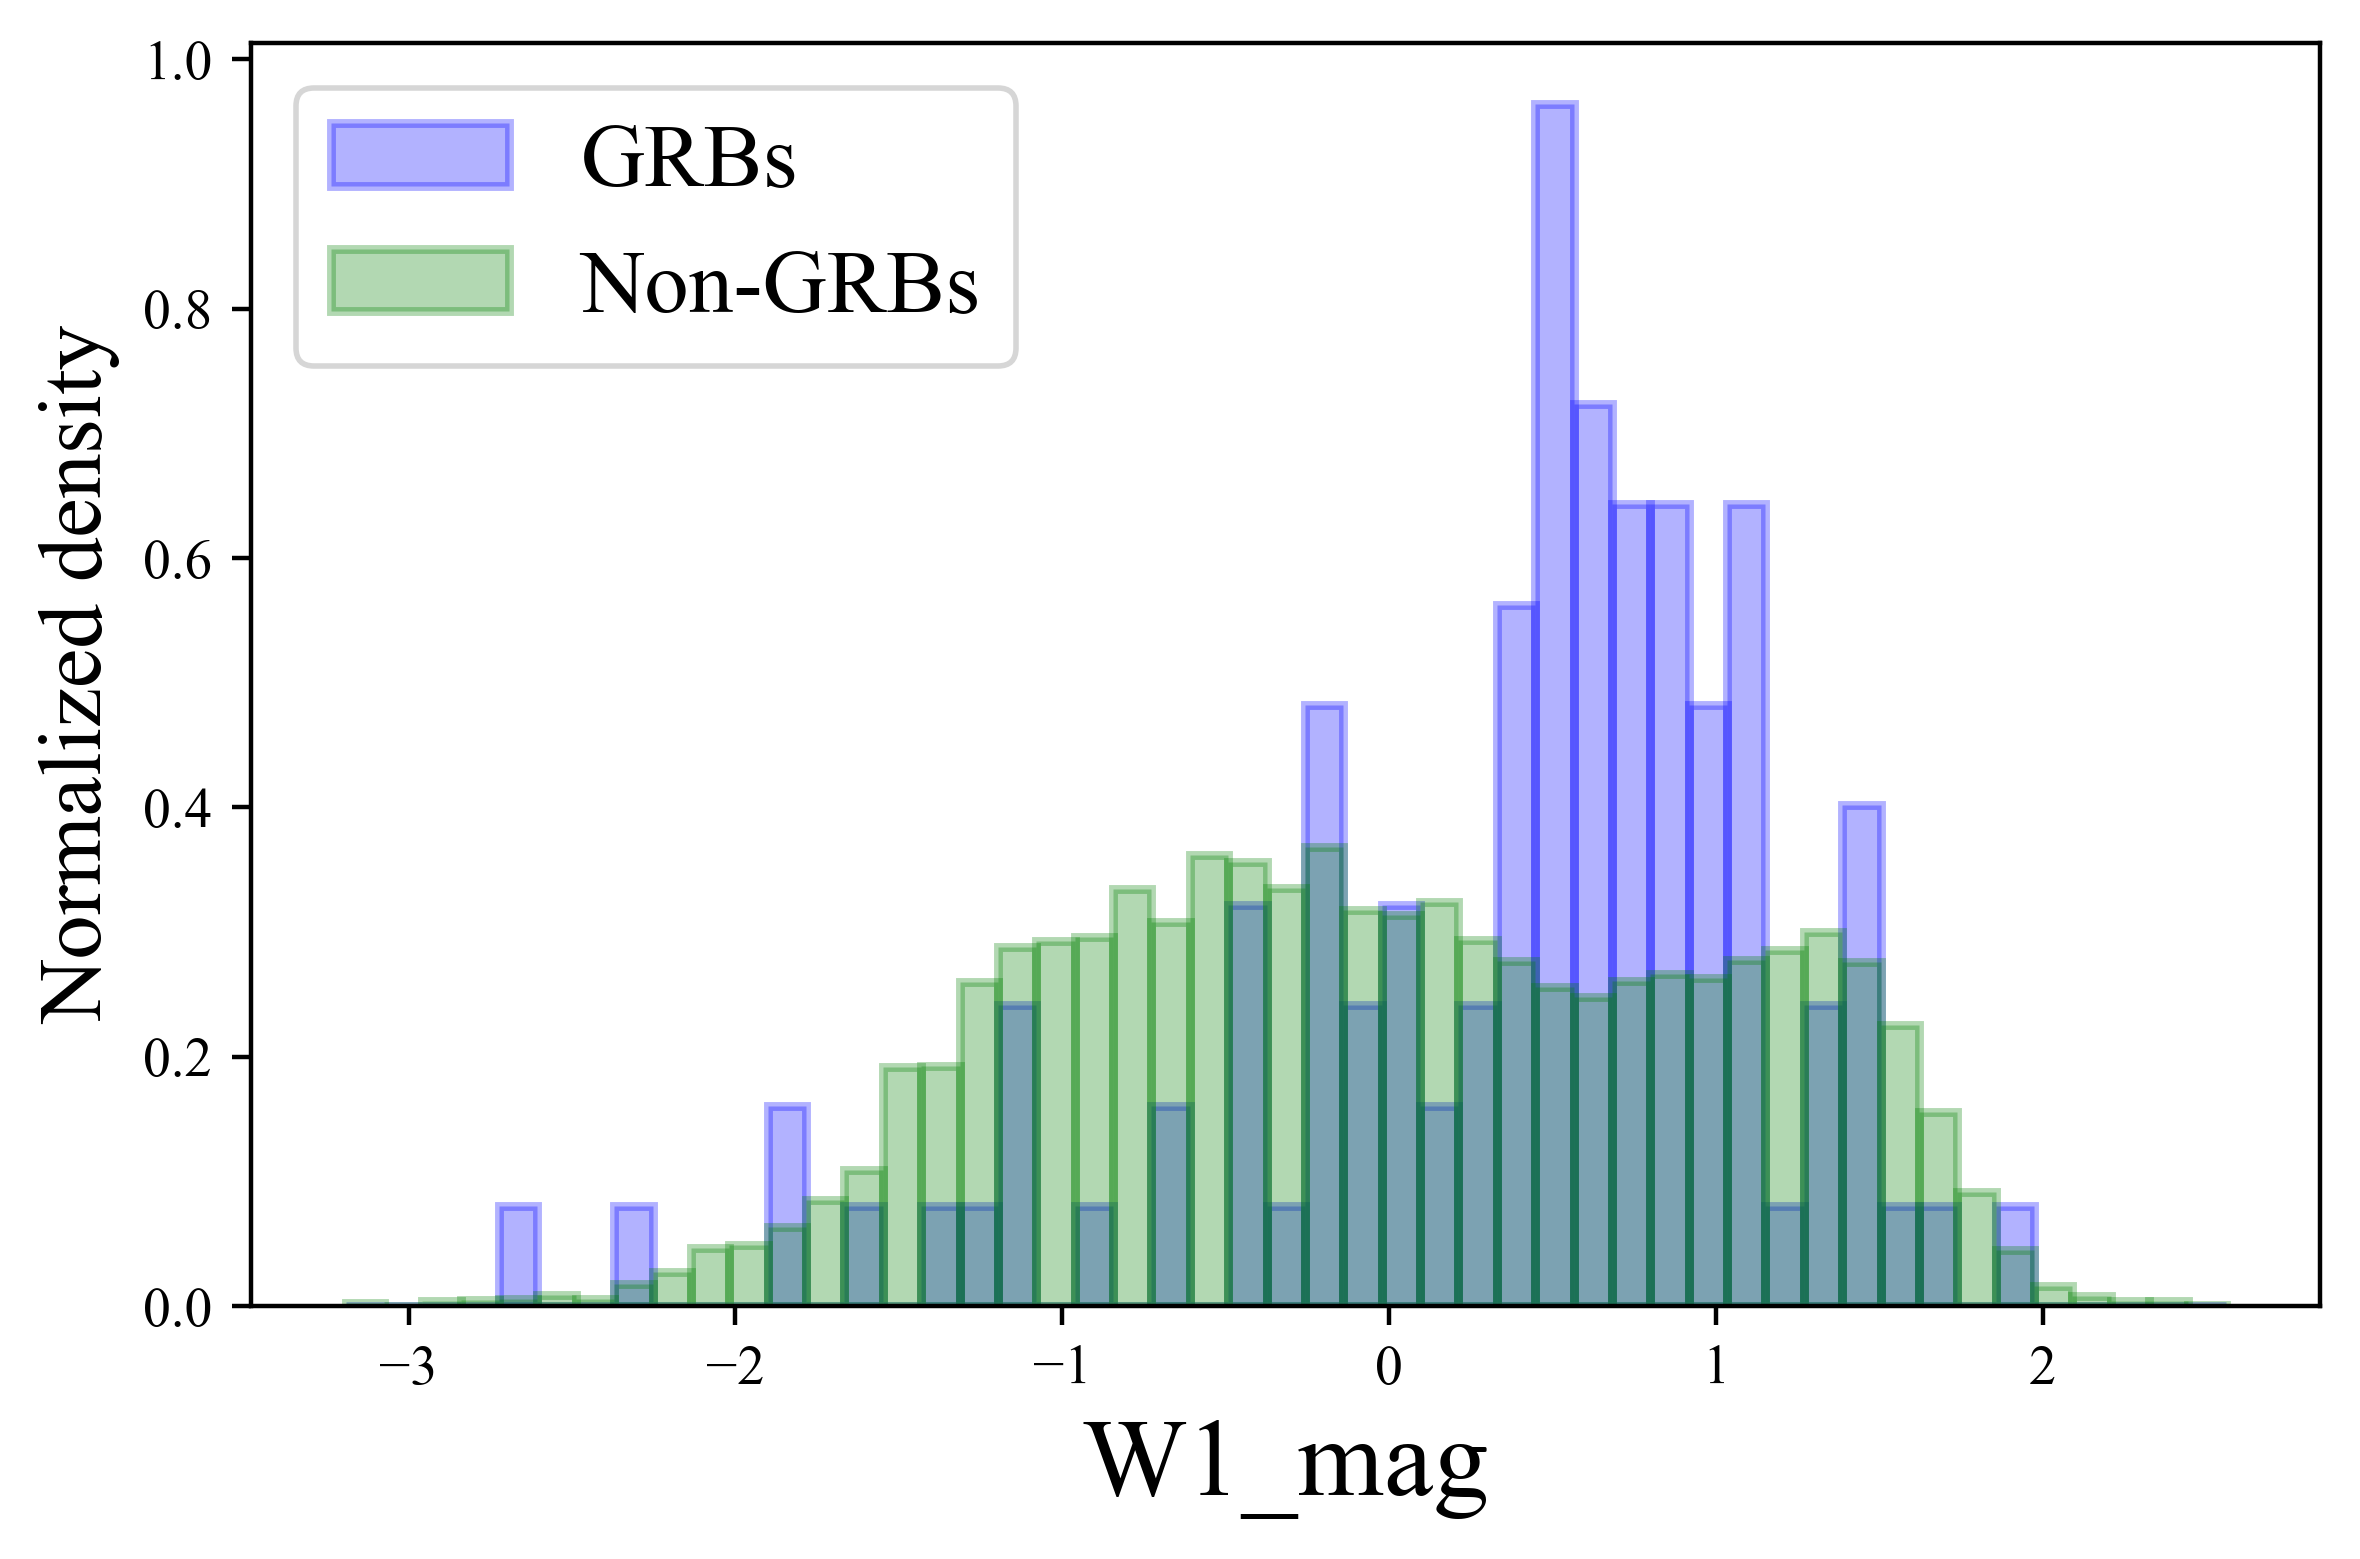



Feature: W2_mag
Distributions ARE different.


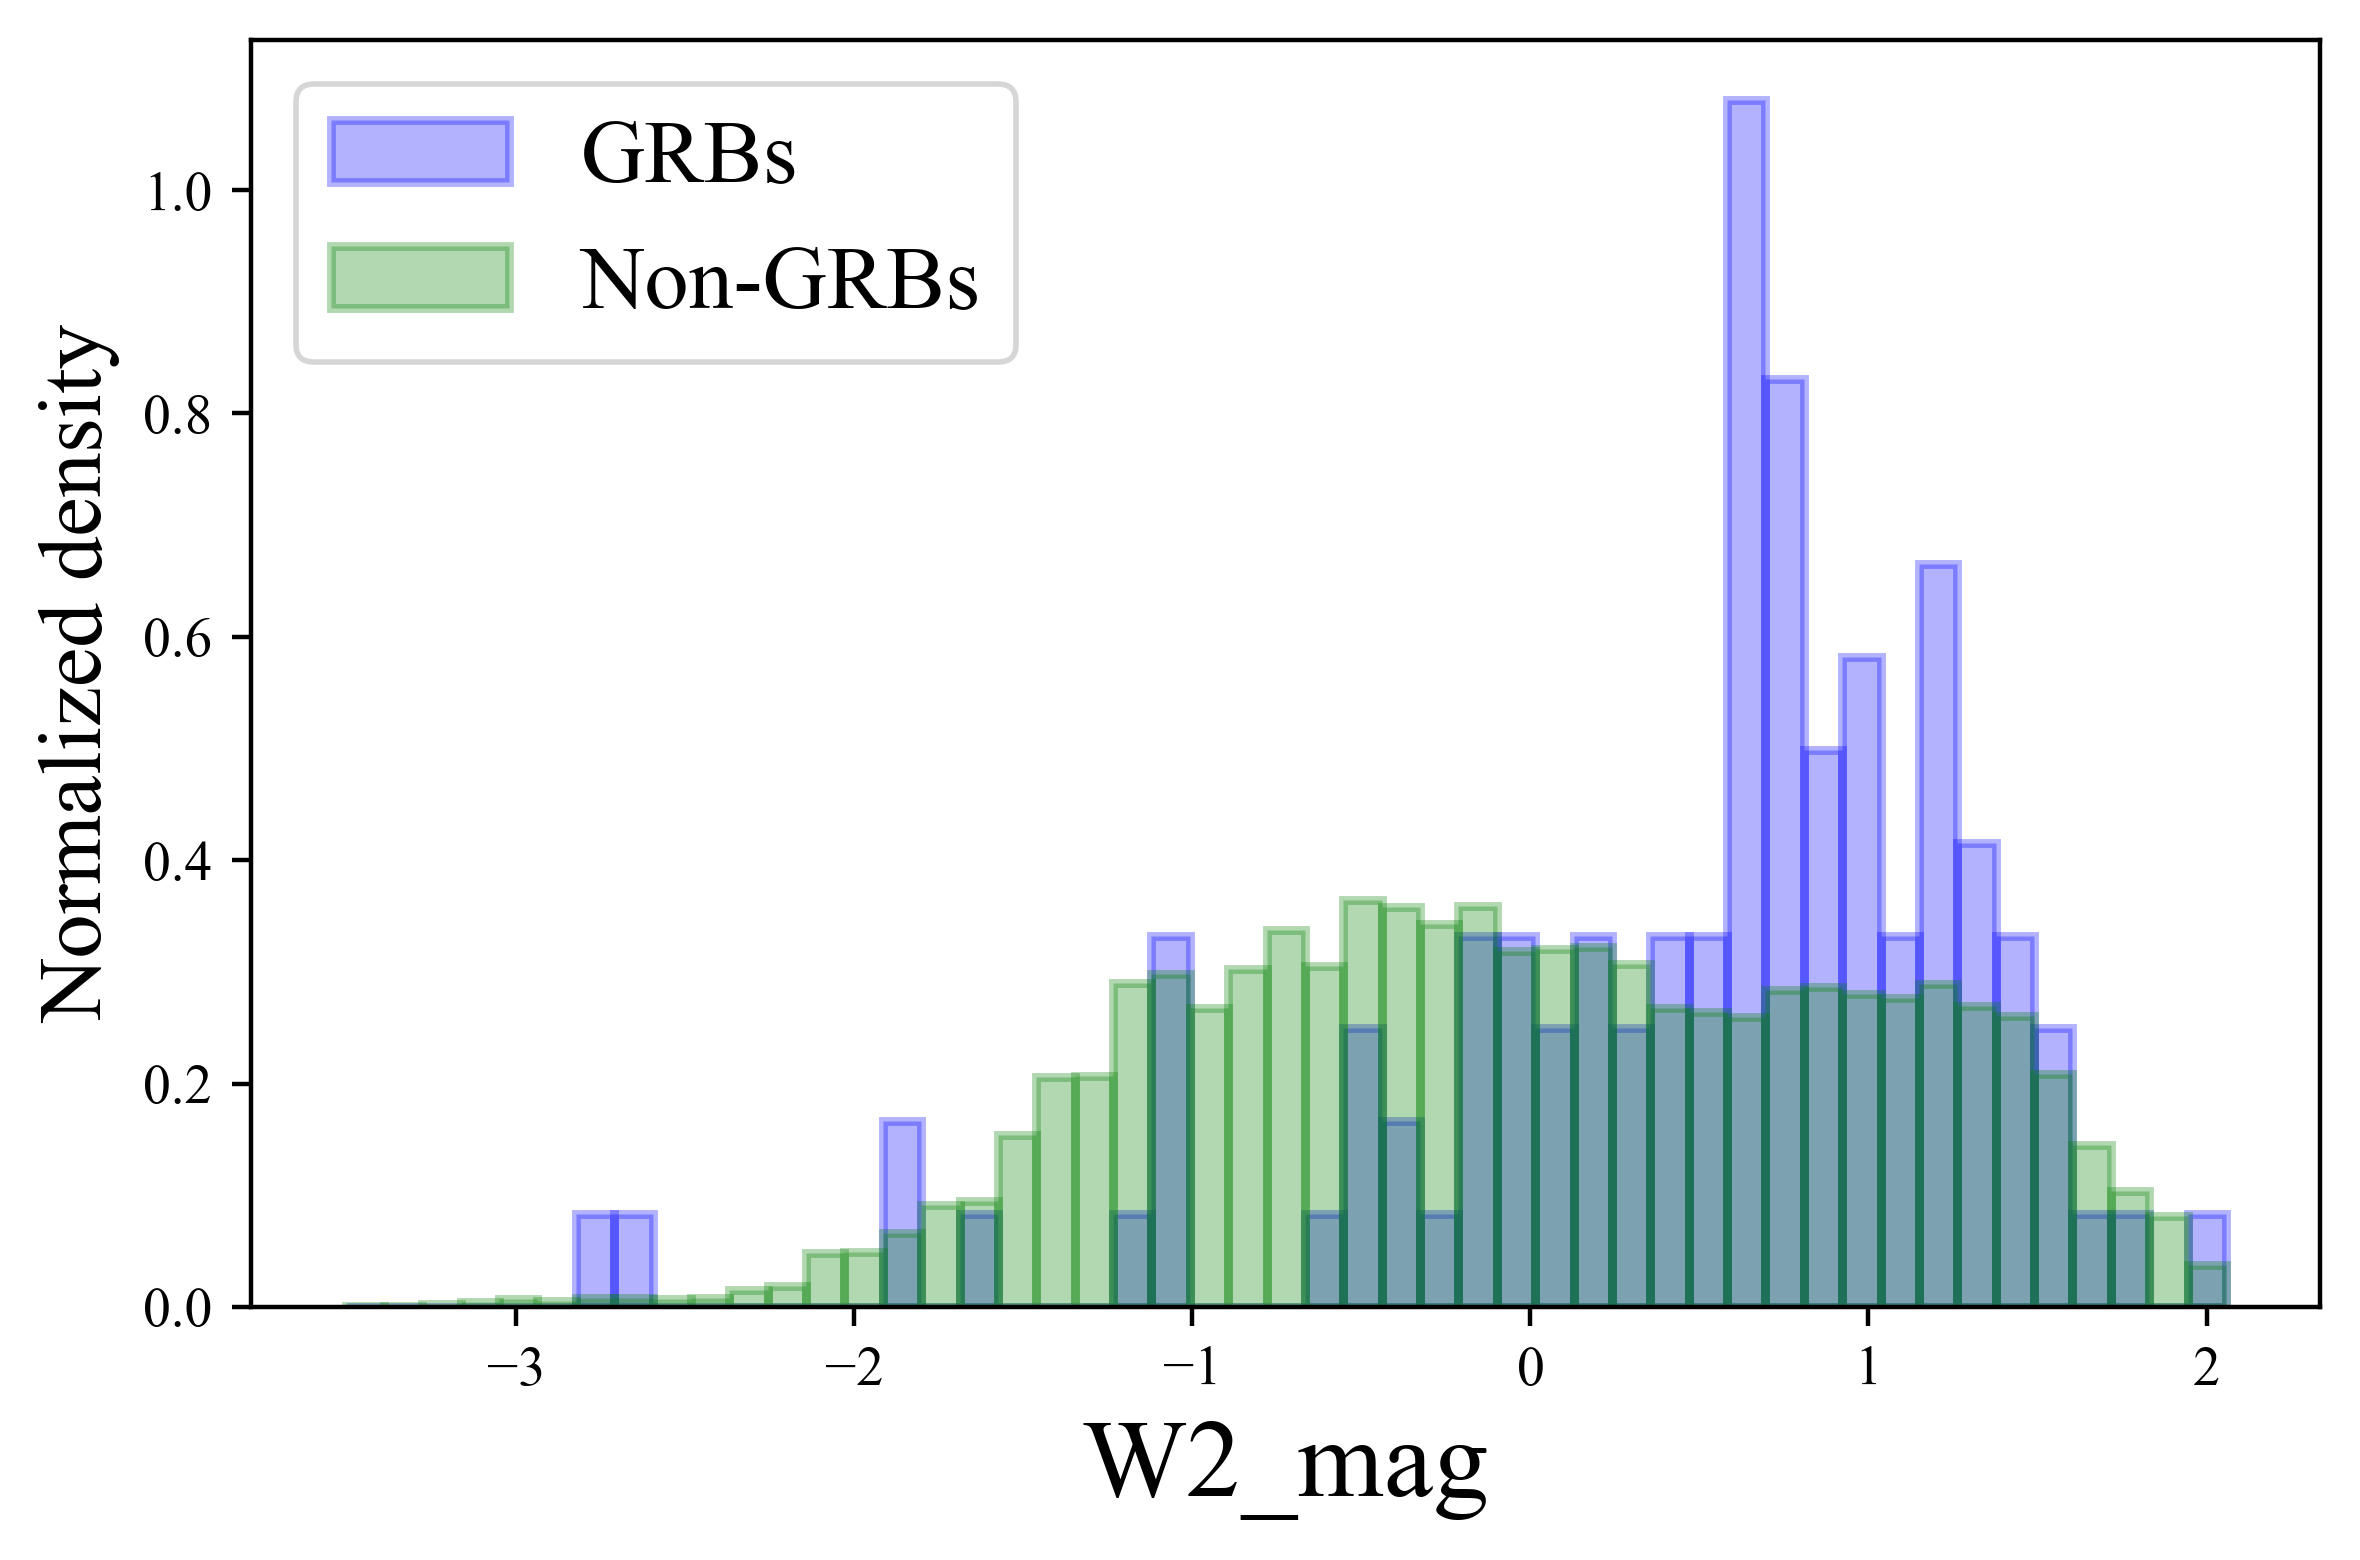



Feature: i_mag
Distributions ARE different.


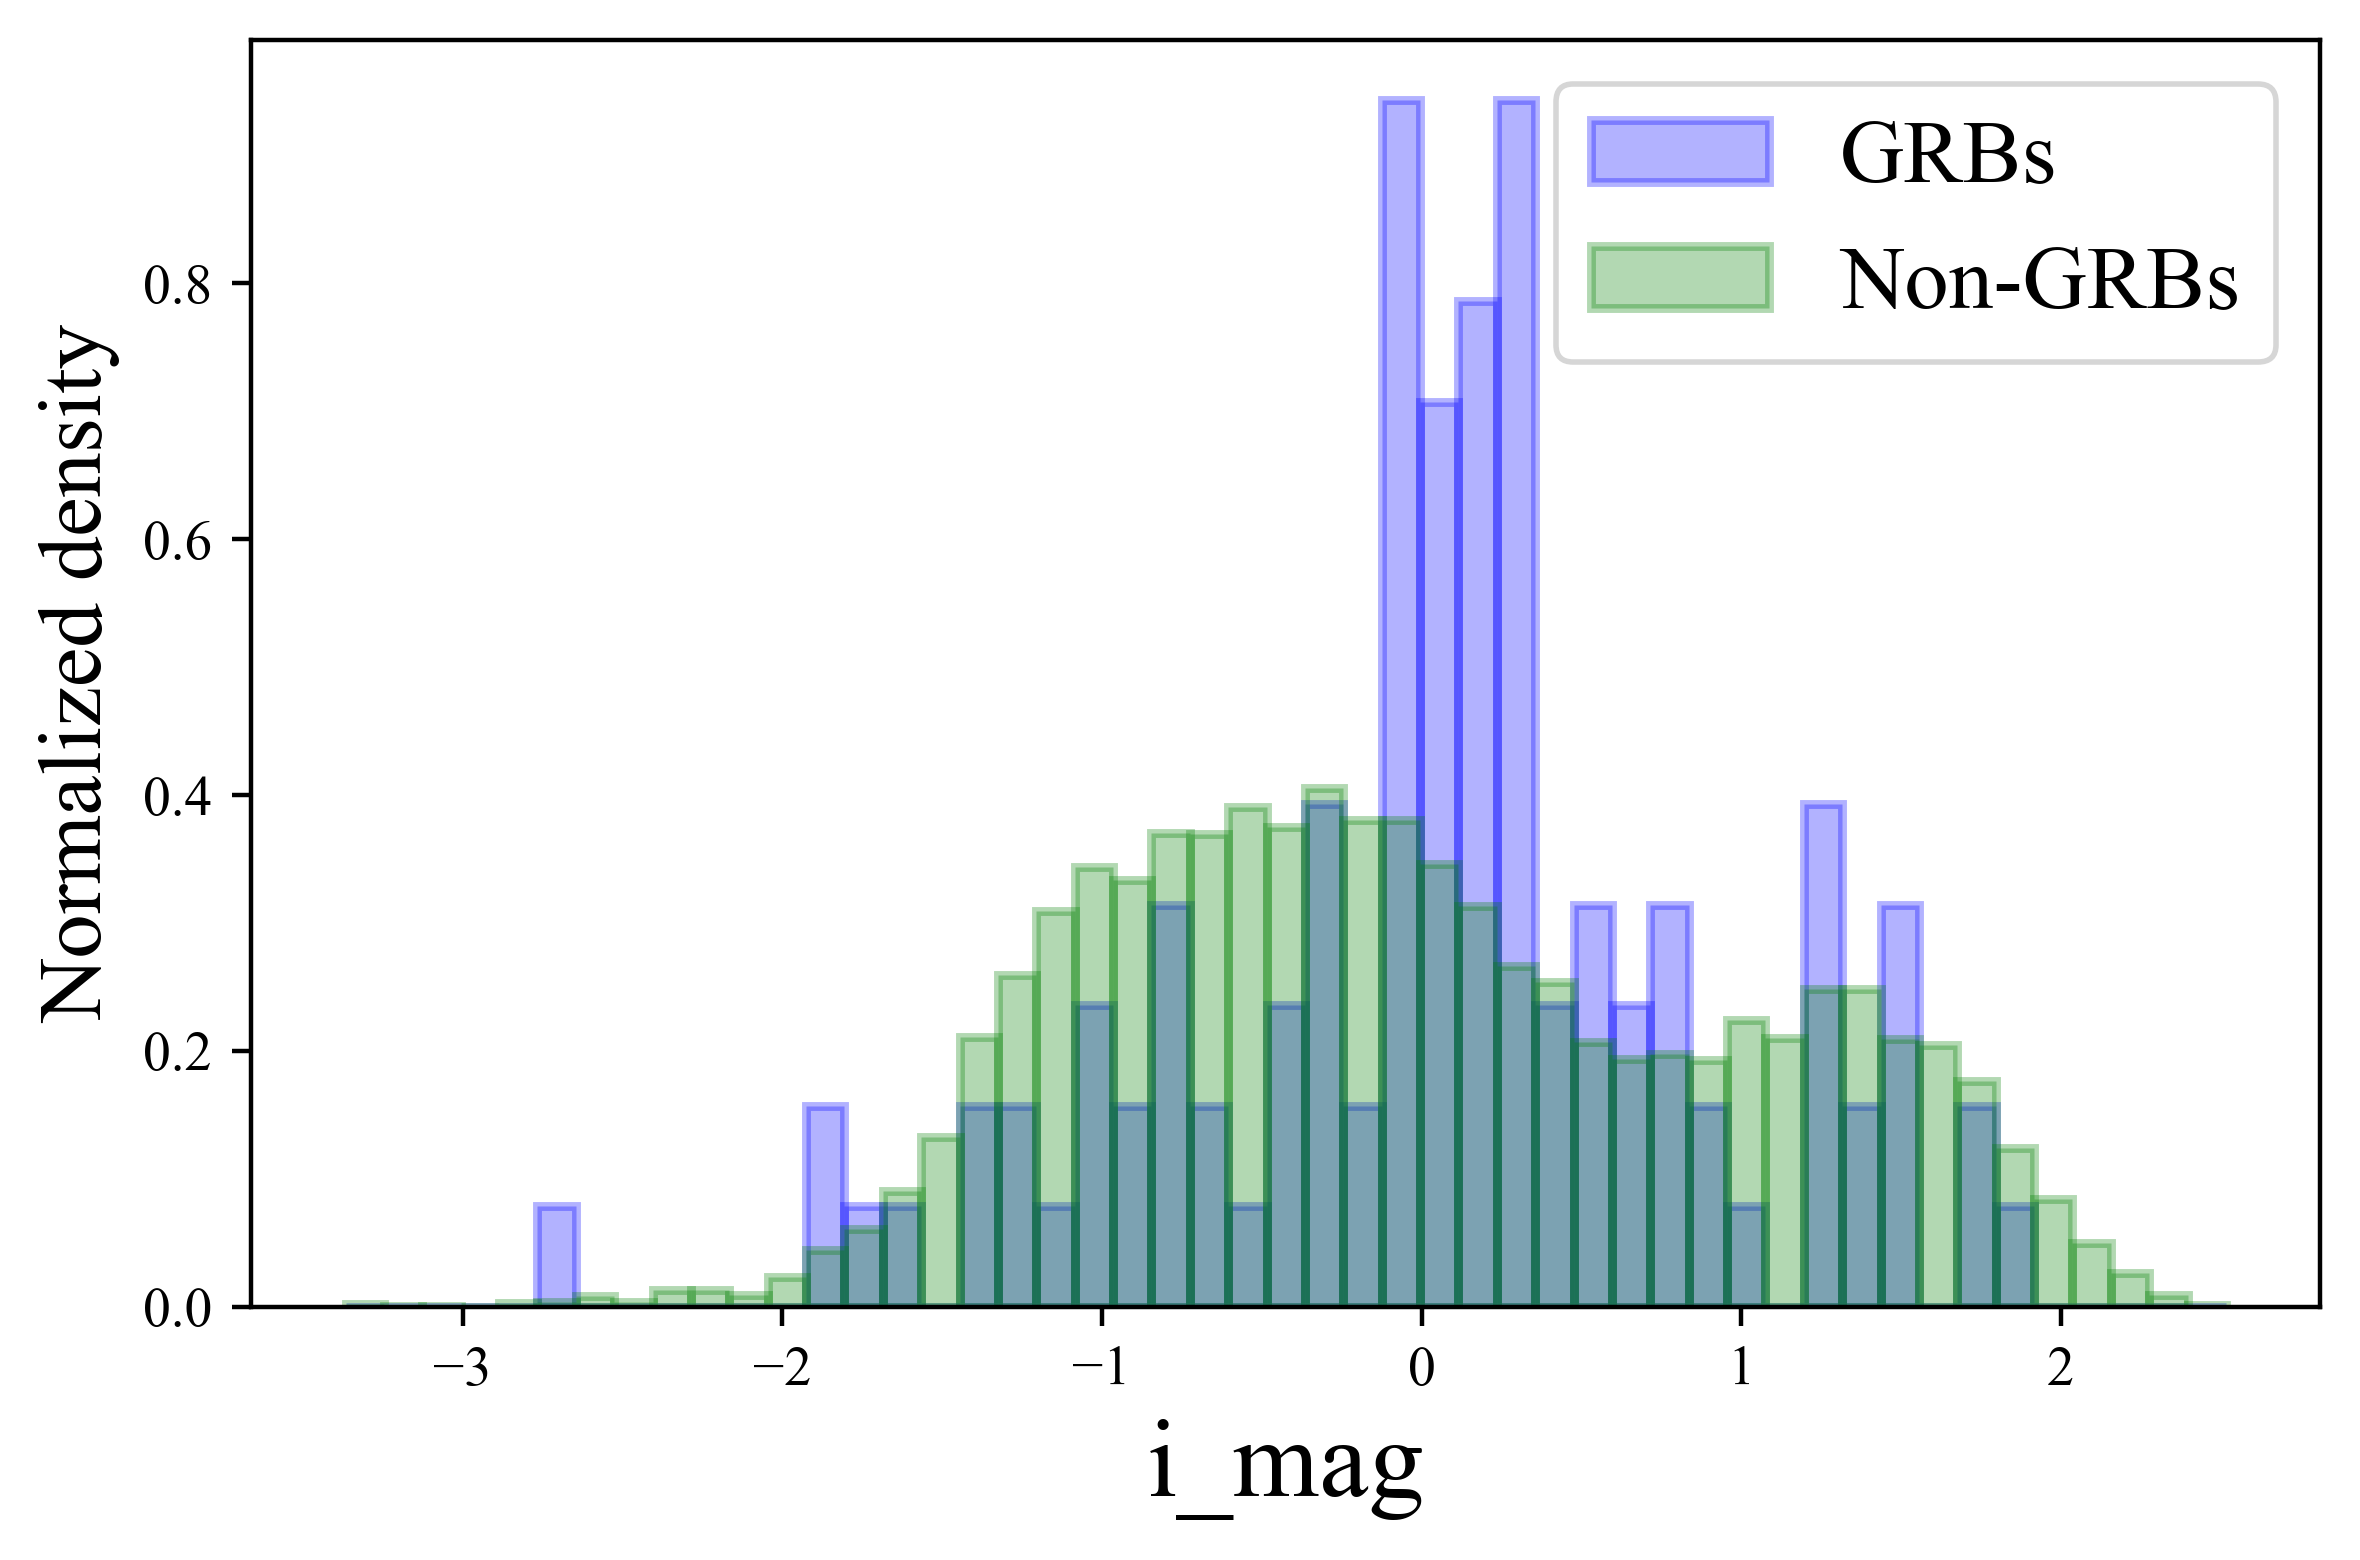



Feature: z_mag
Distributions ARE different.


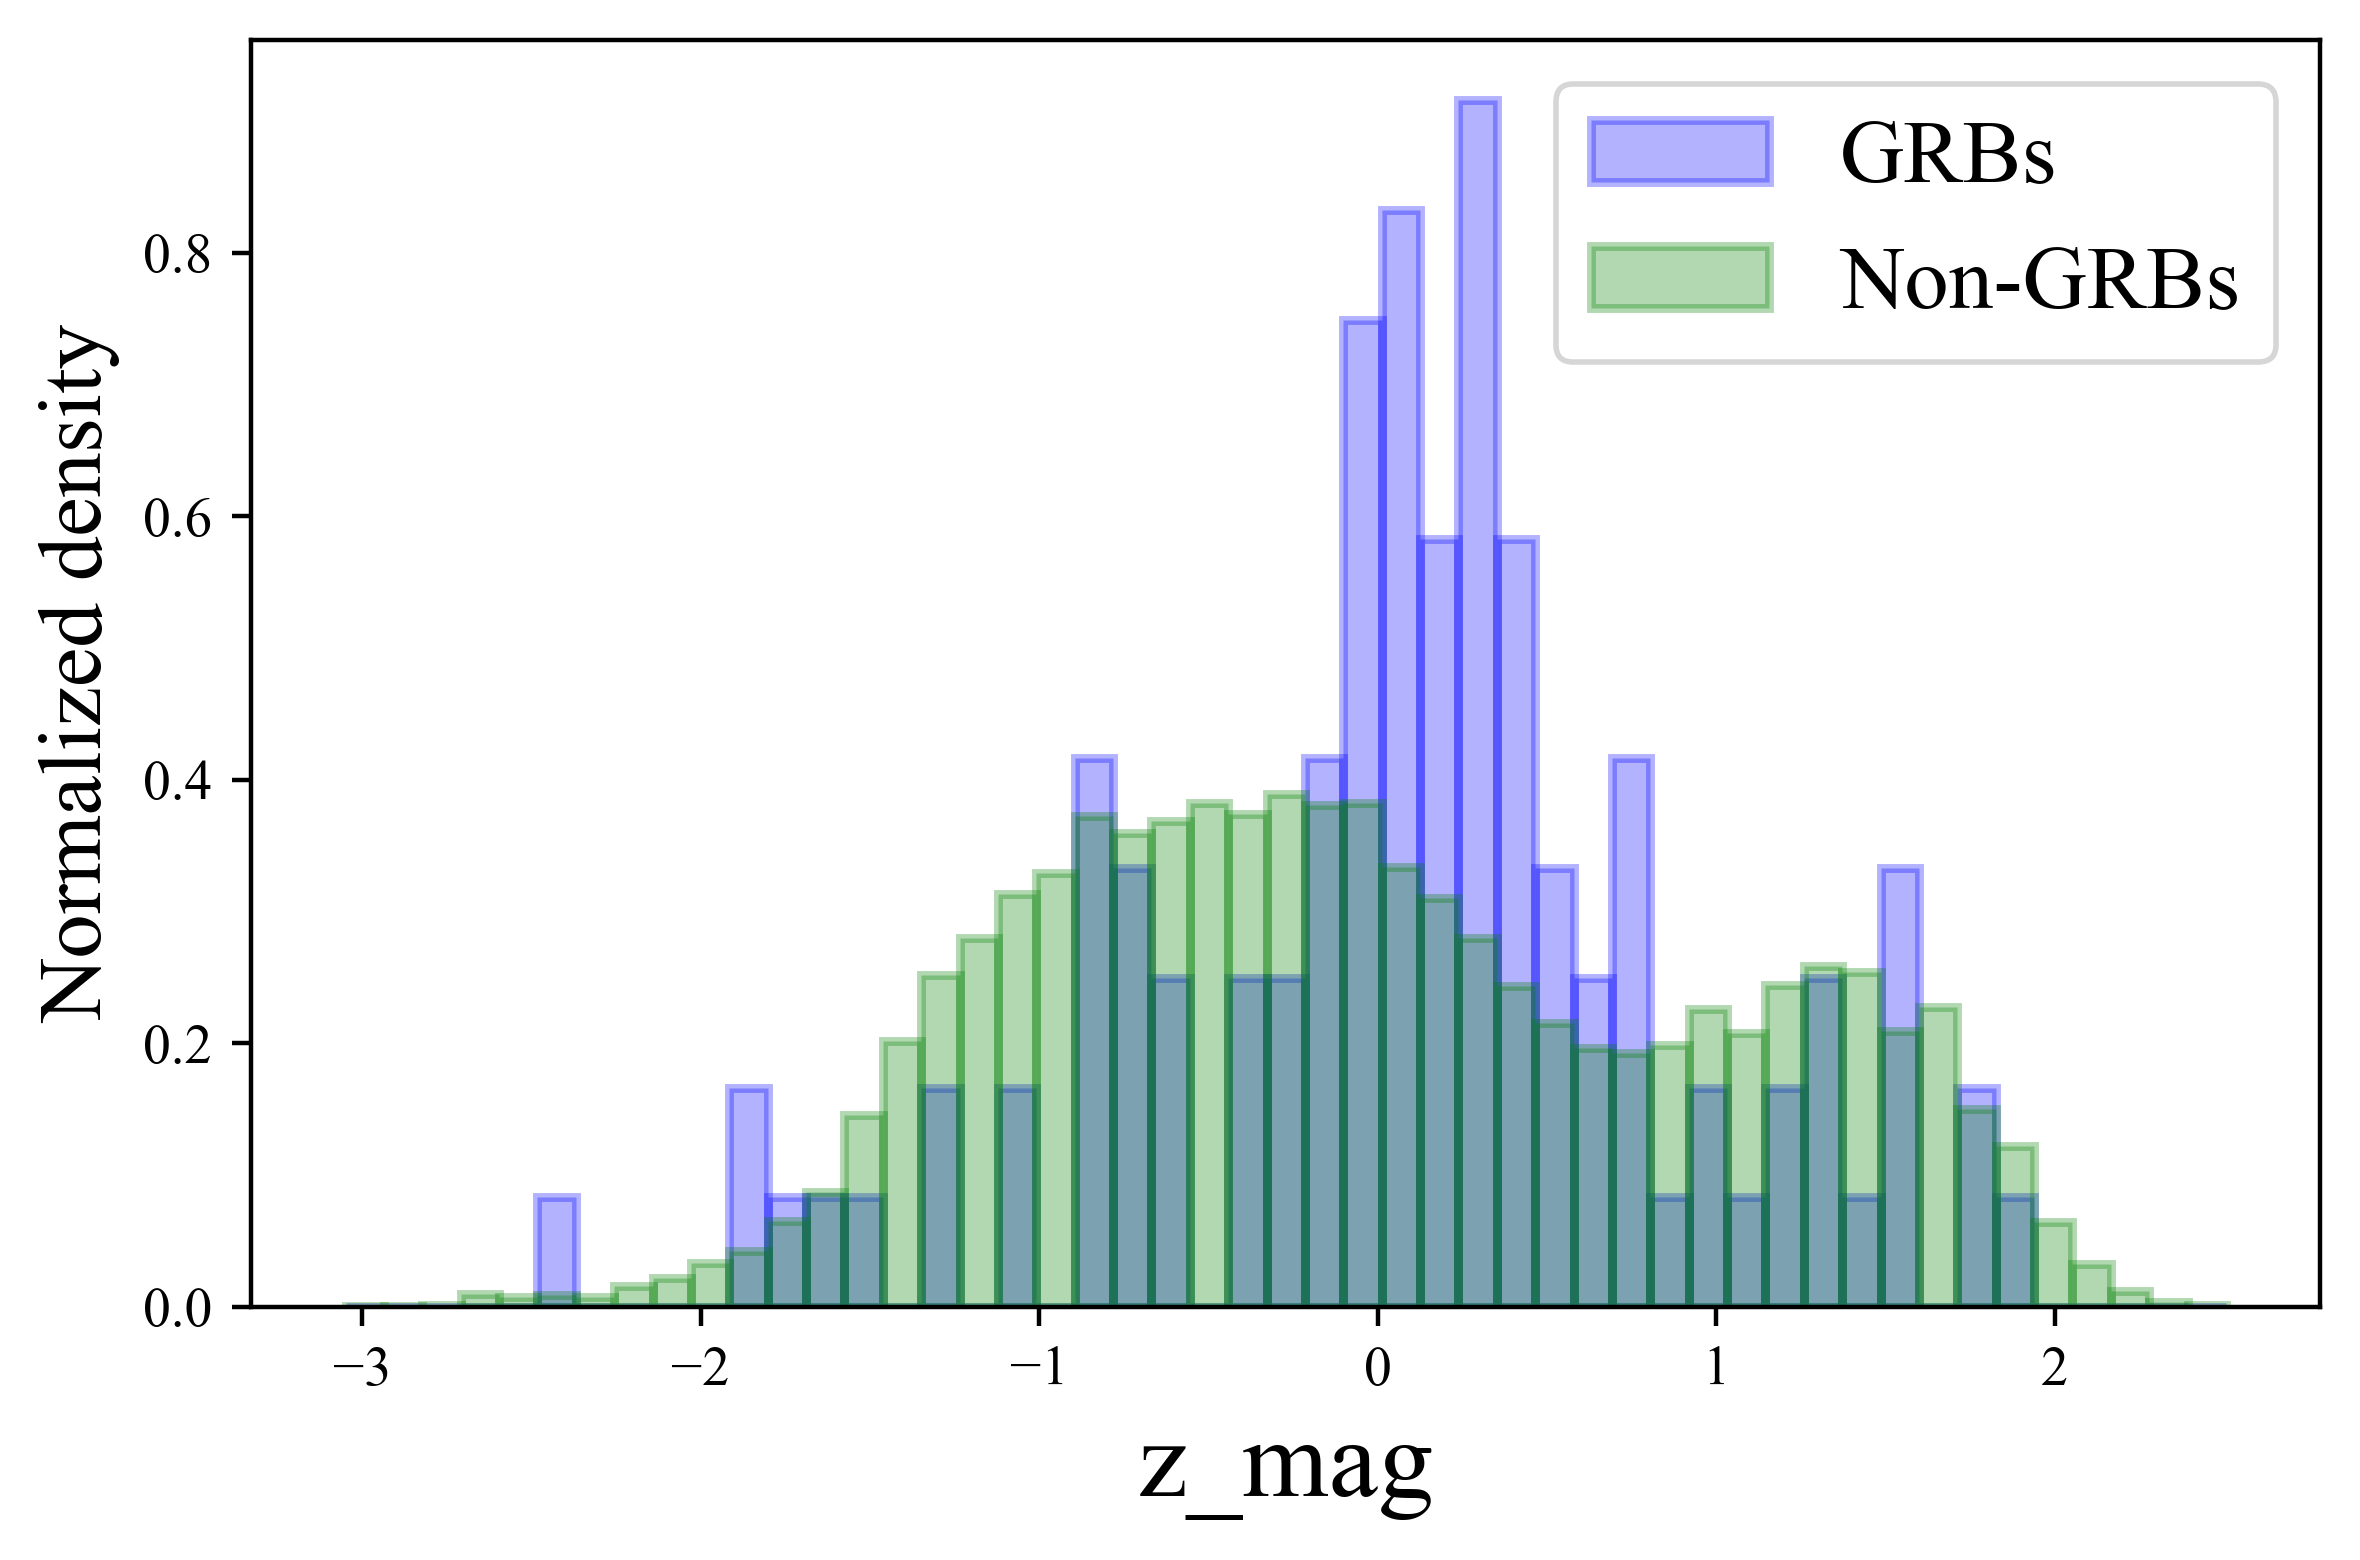



Feature: g_mag


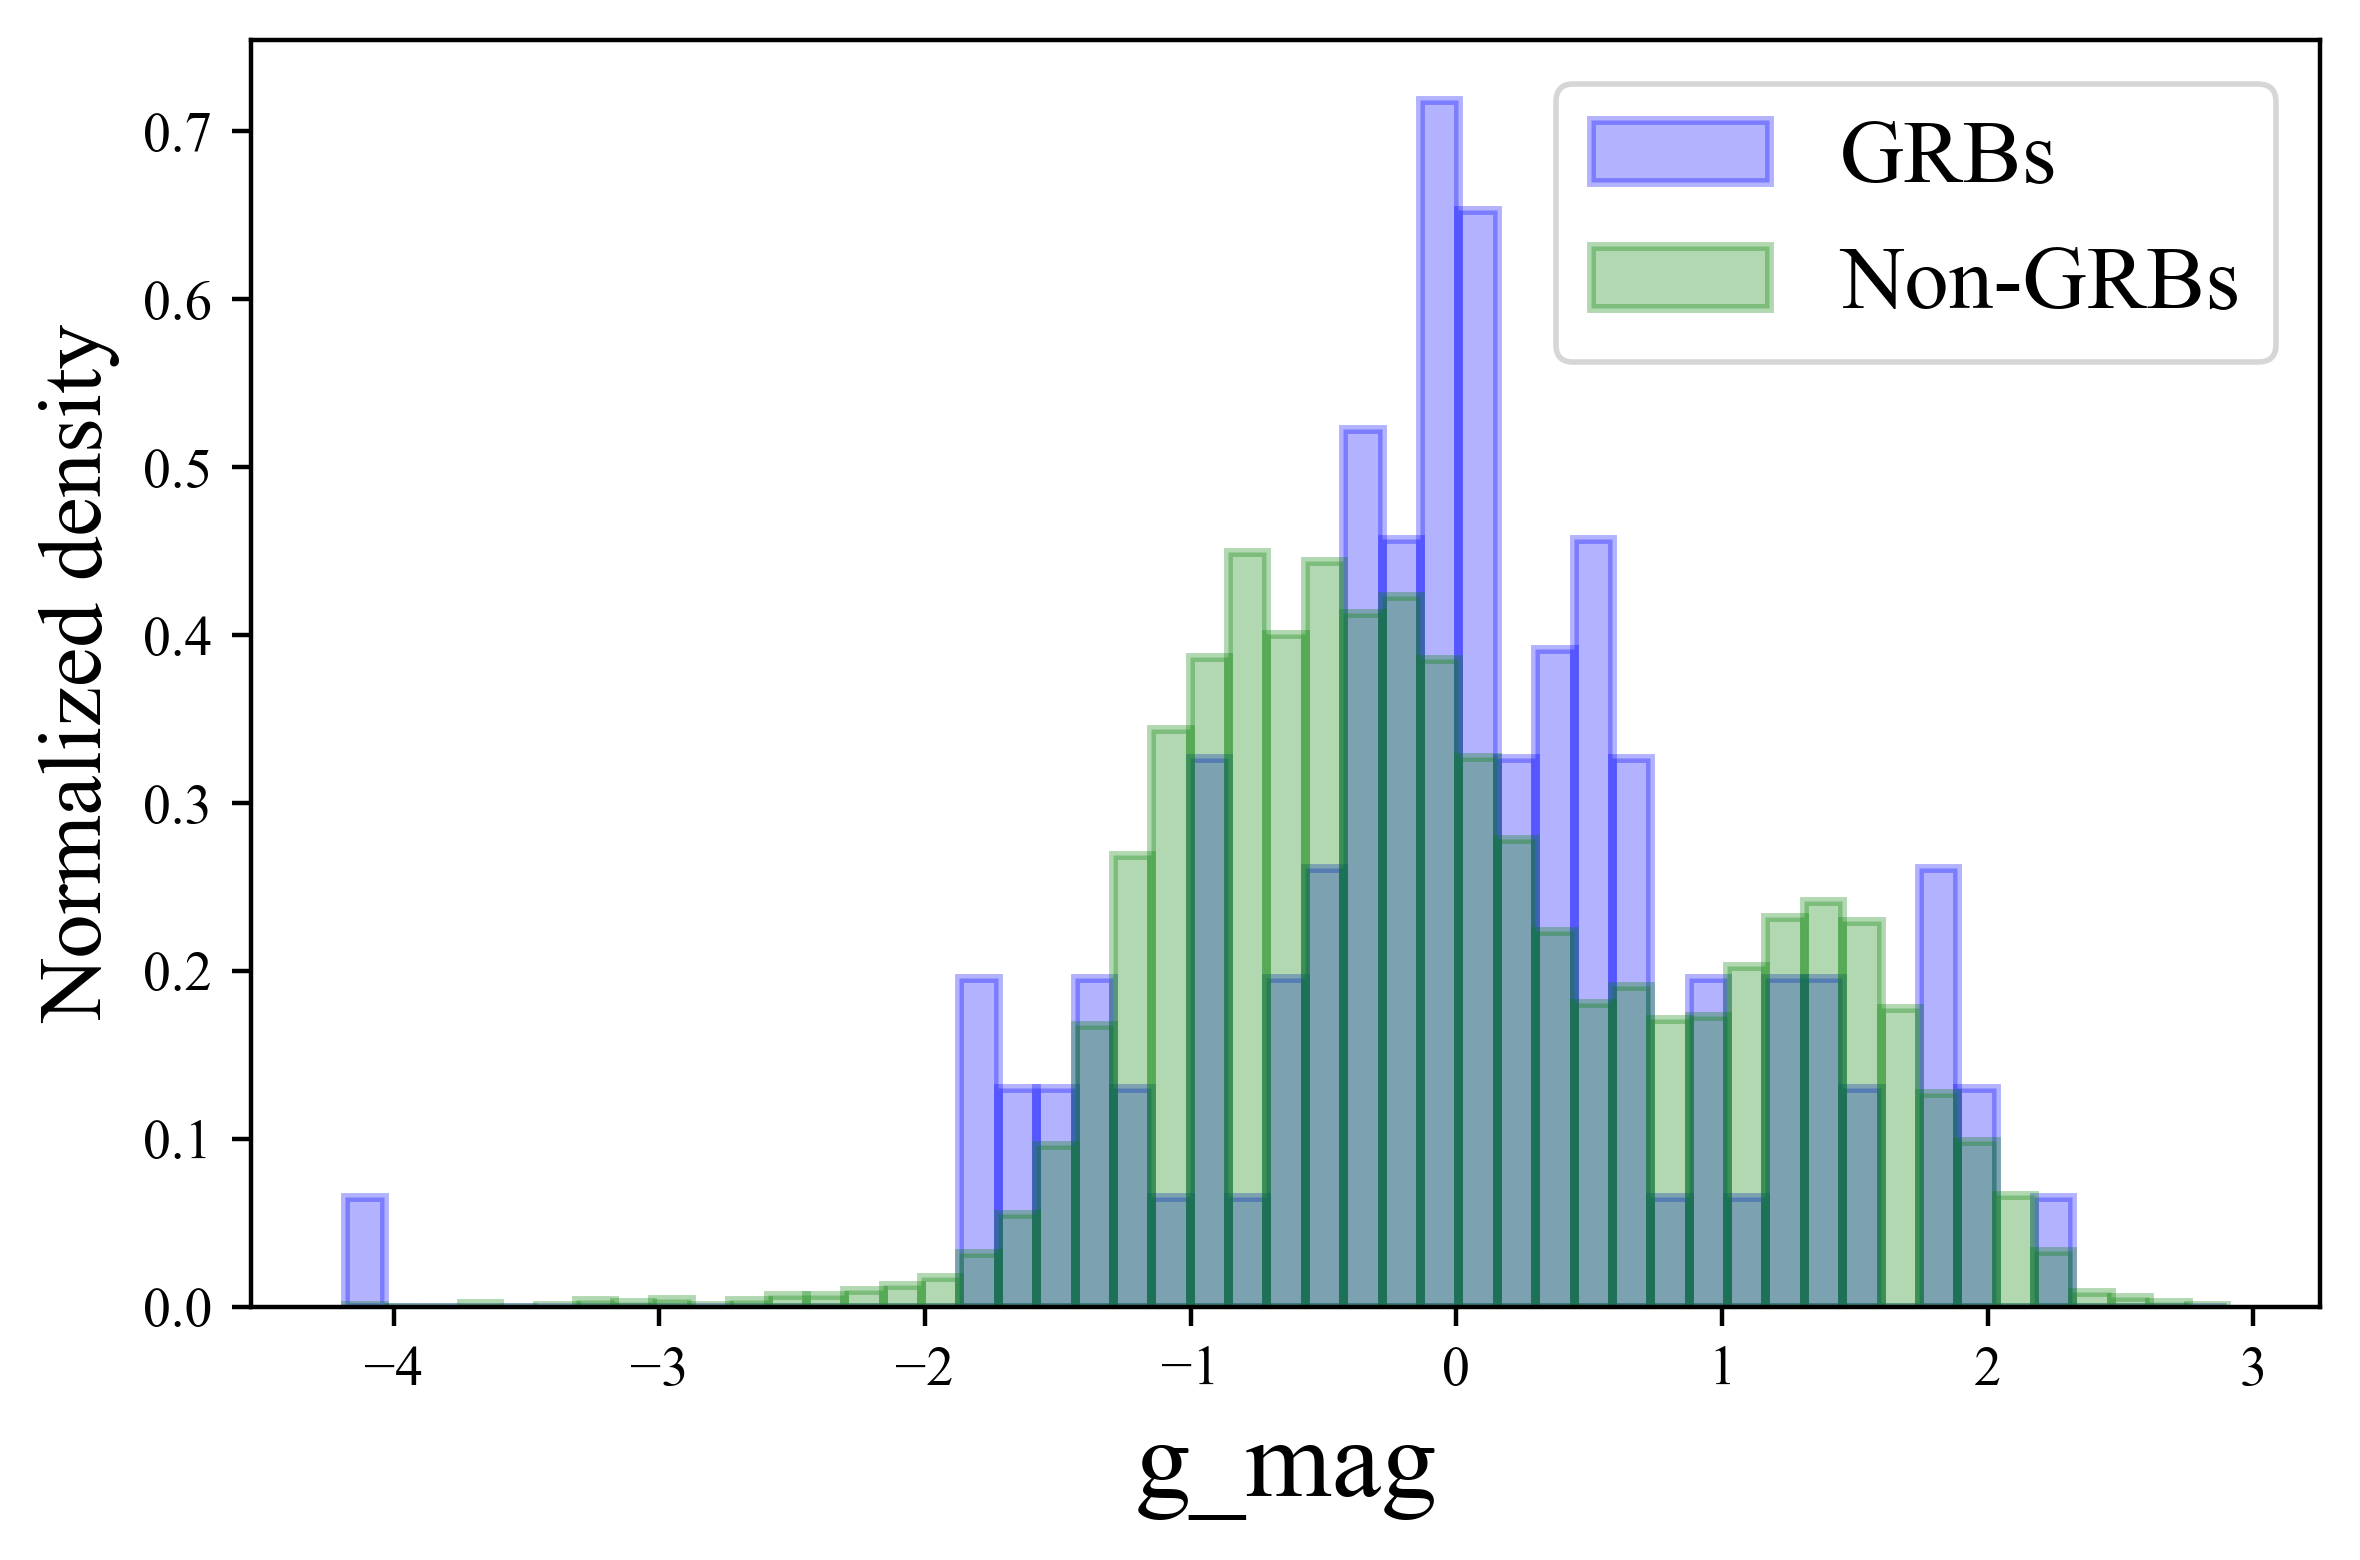



Feature: y_mag_minus_J_mag
Distributions ARE different.


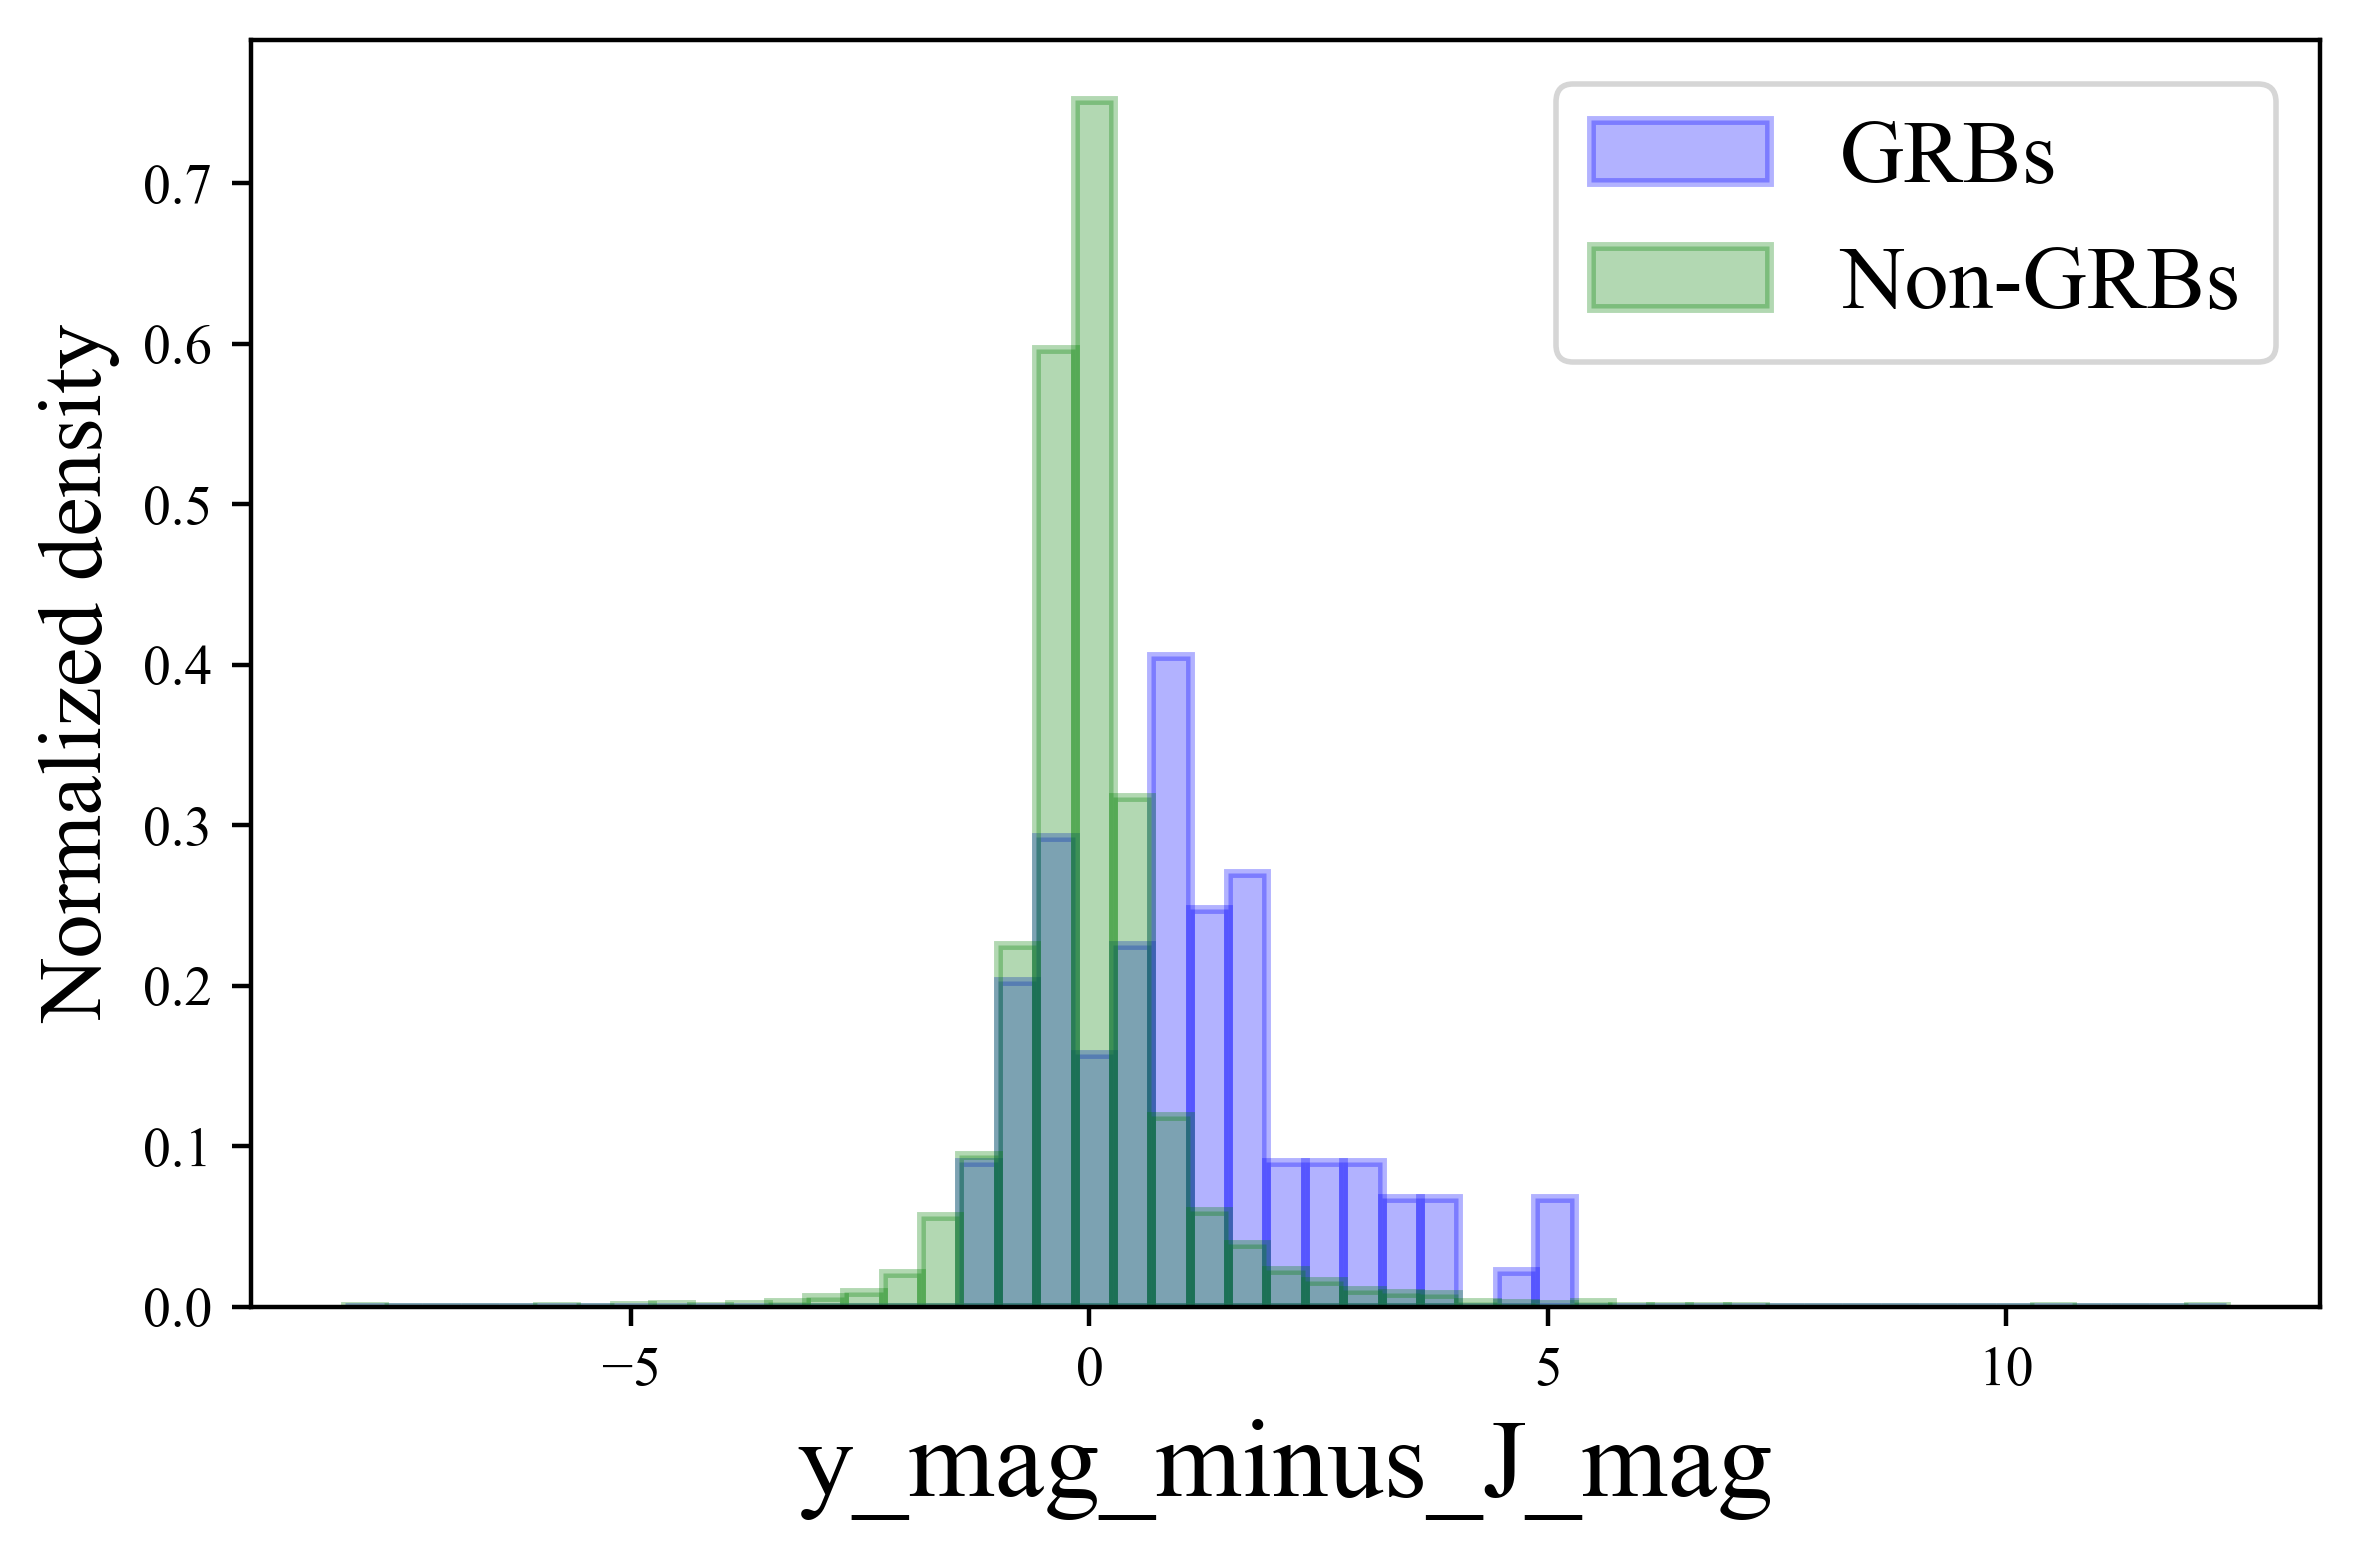



Feature: H_mag_minus_K_mag
Distributions ARE different.


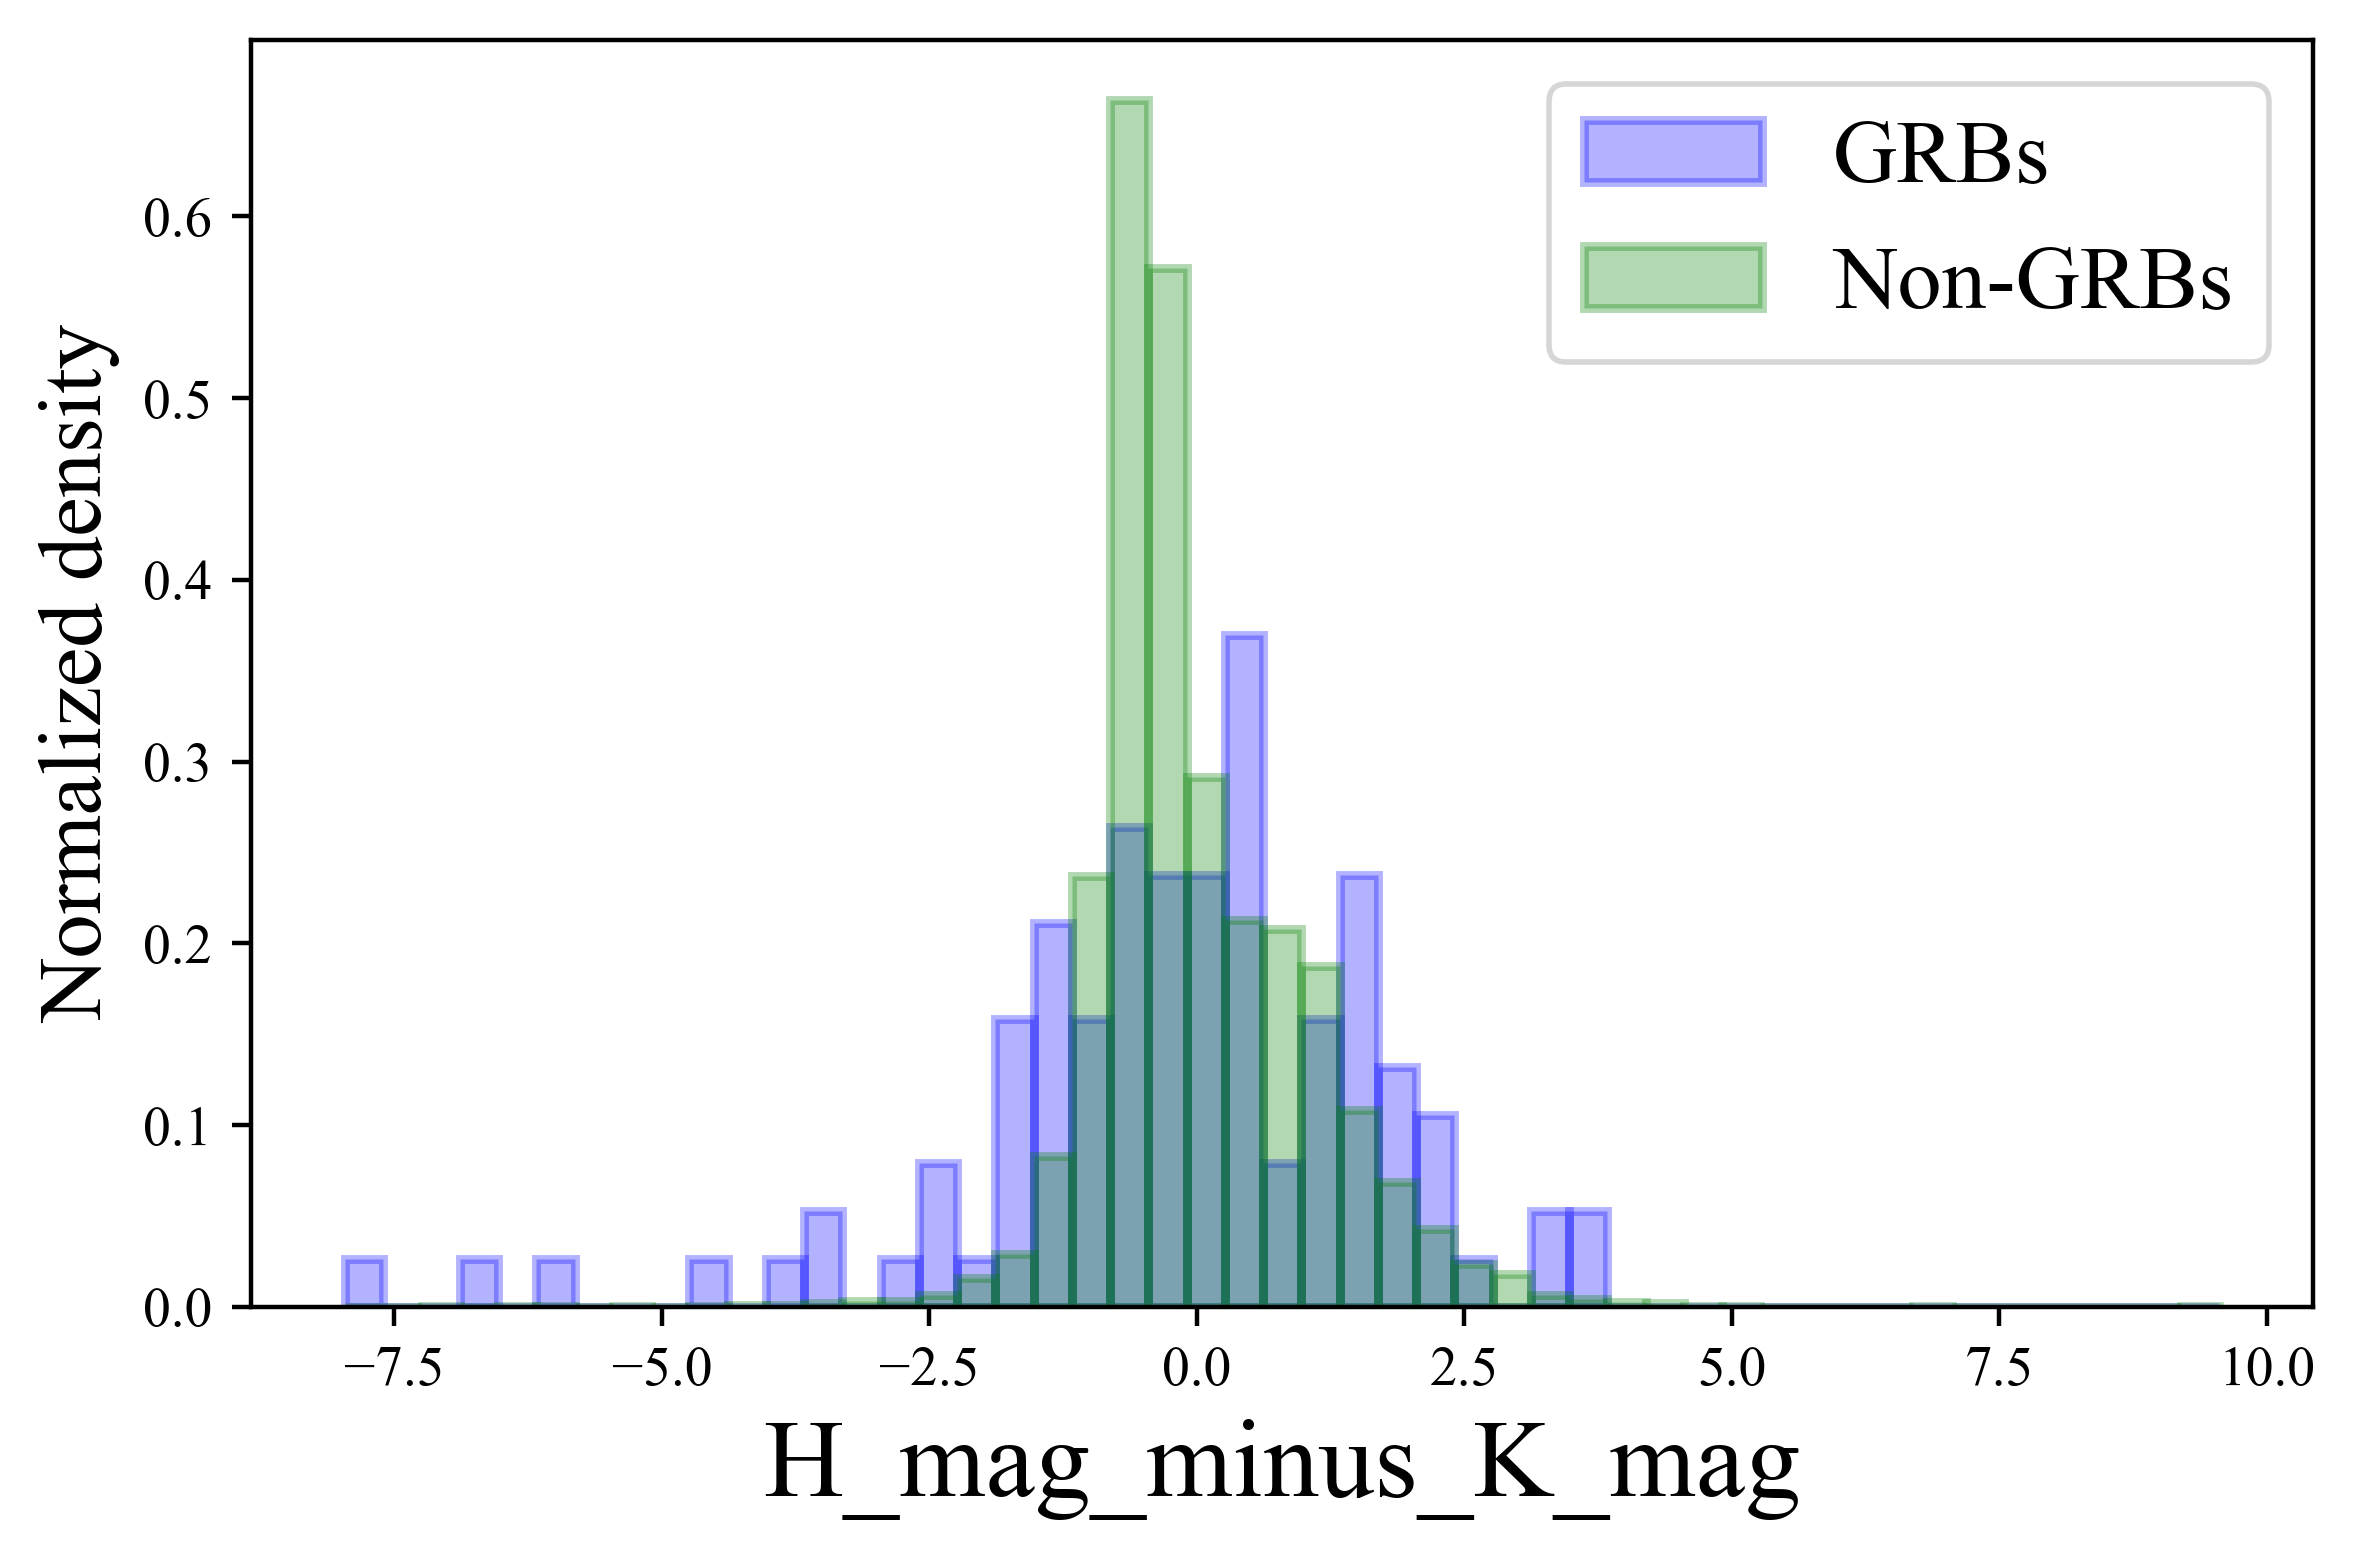



Feature: z_mag_minus_y_mag
Distributions ARE different.


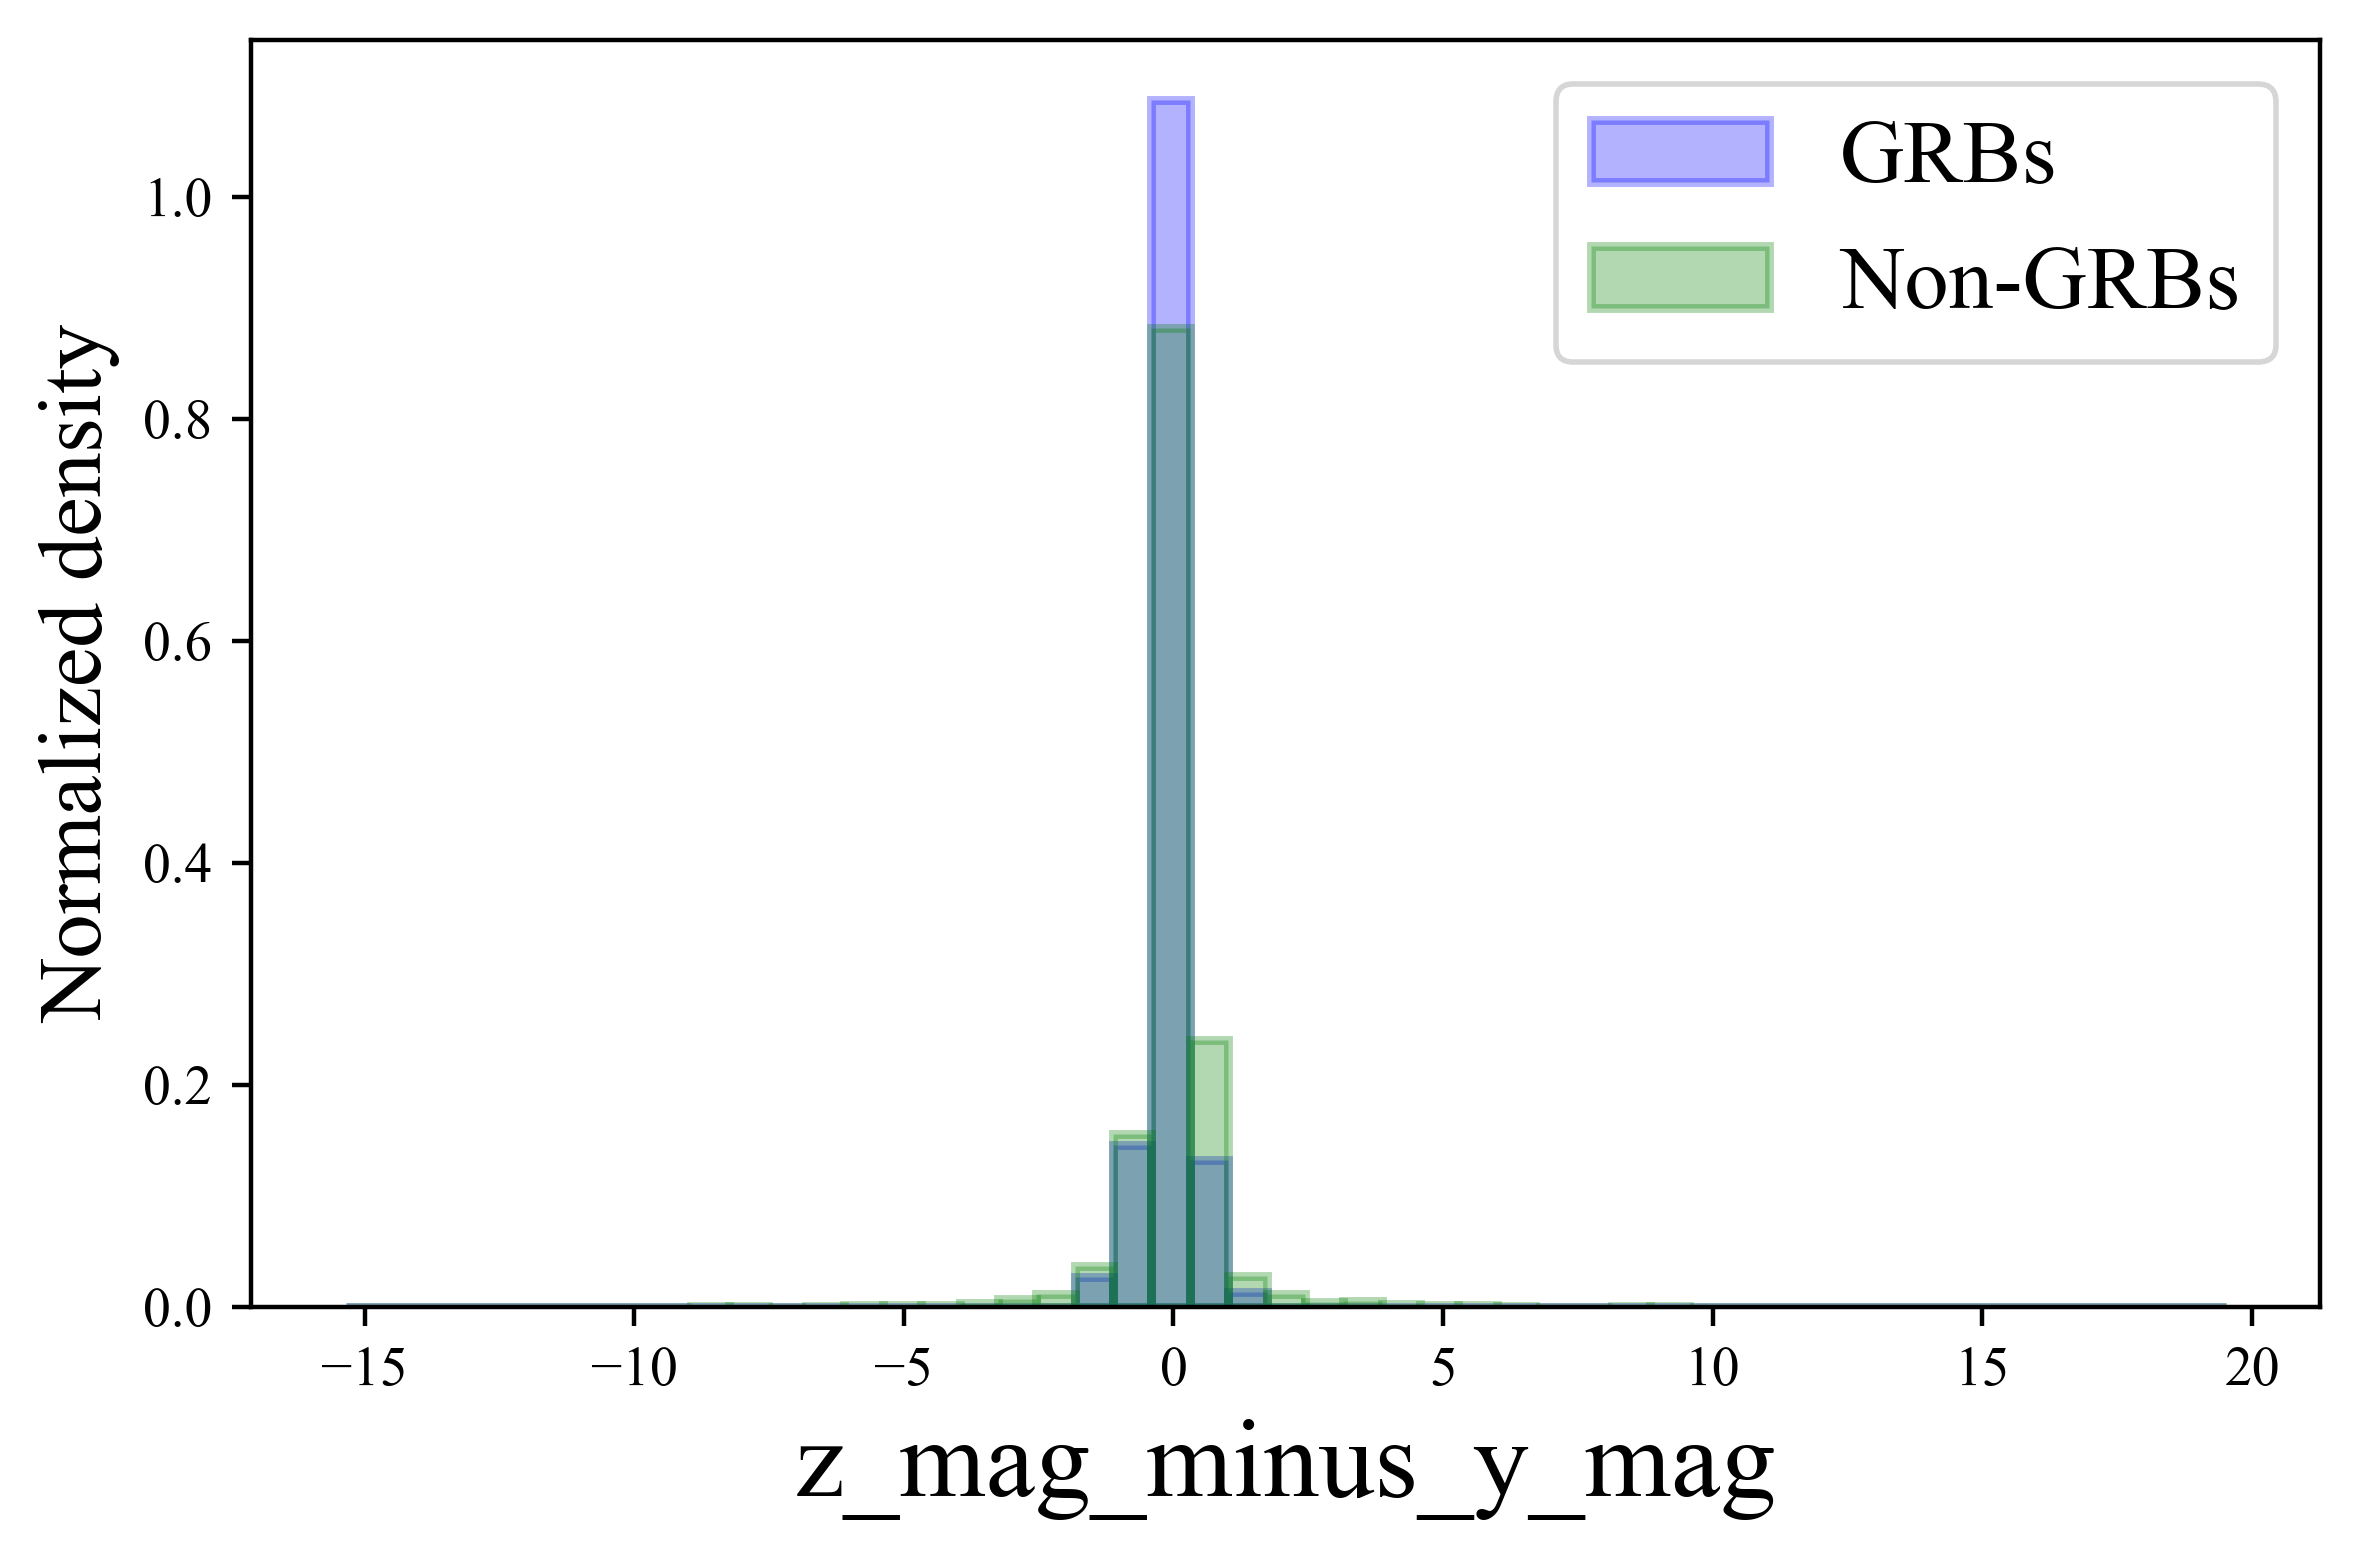



Feature: g_mag_minus_r_mag


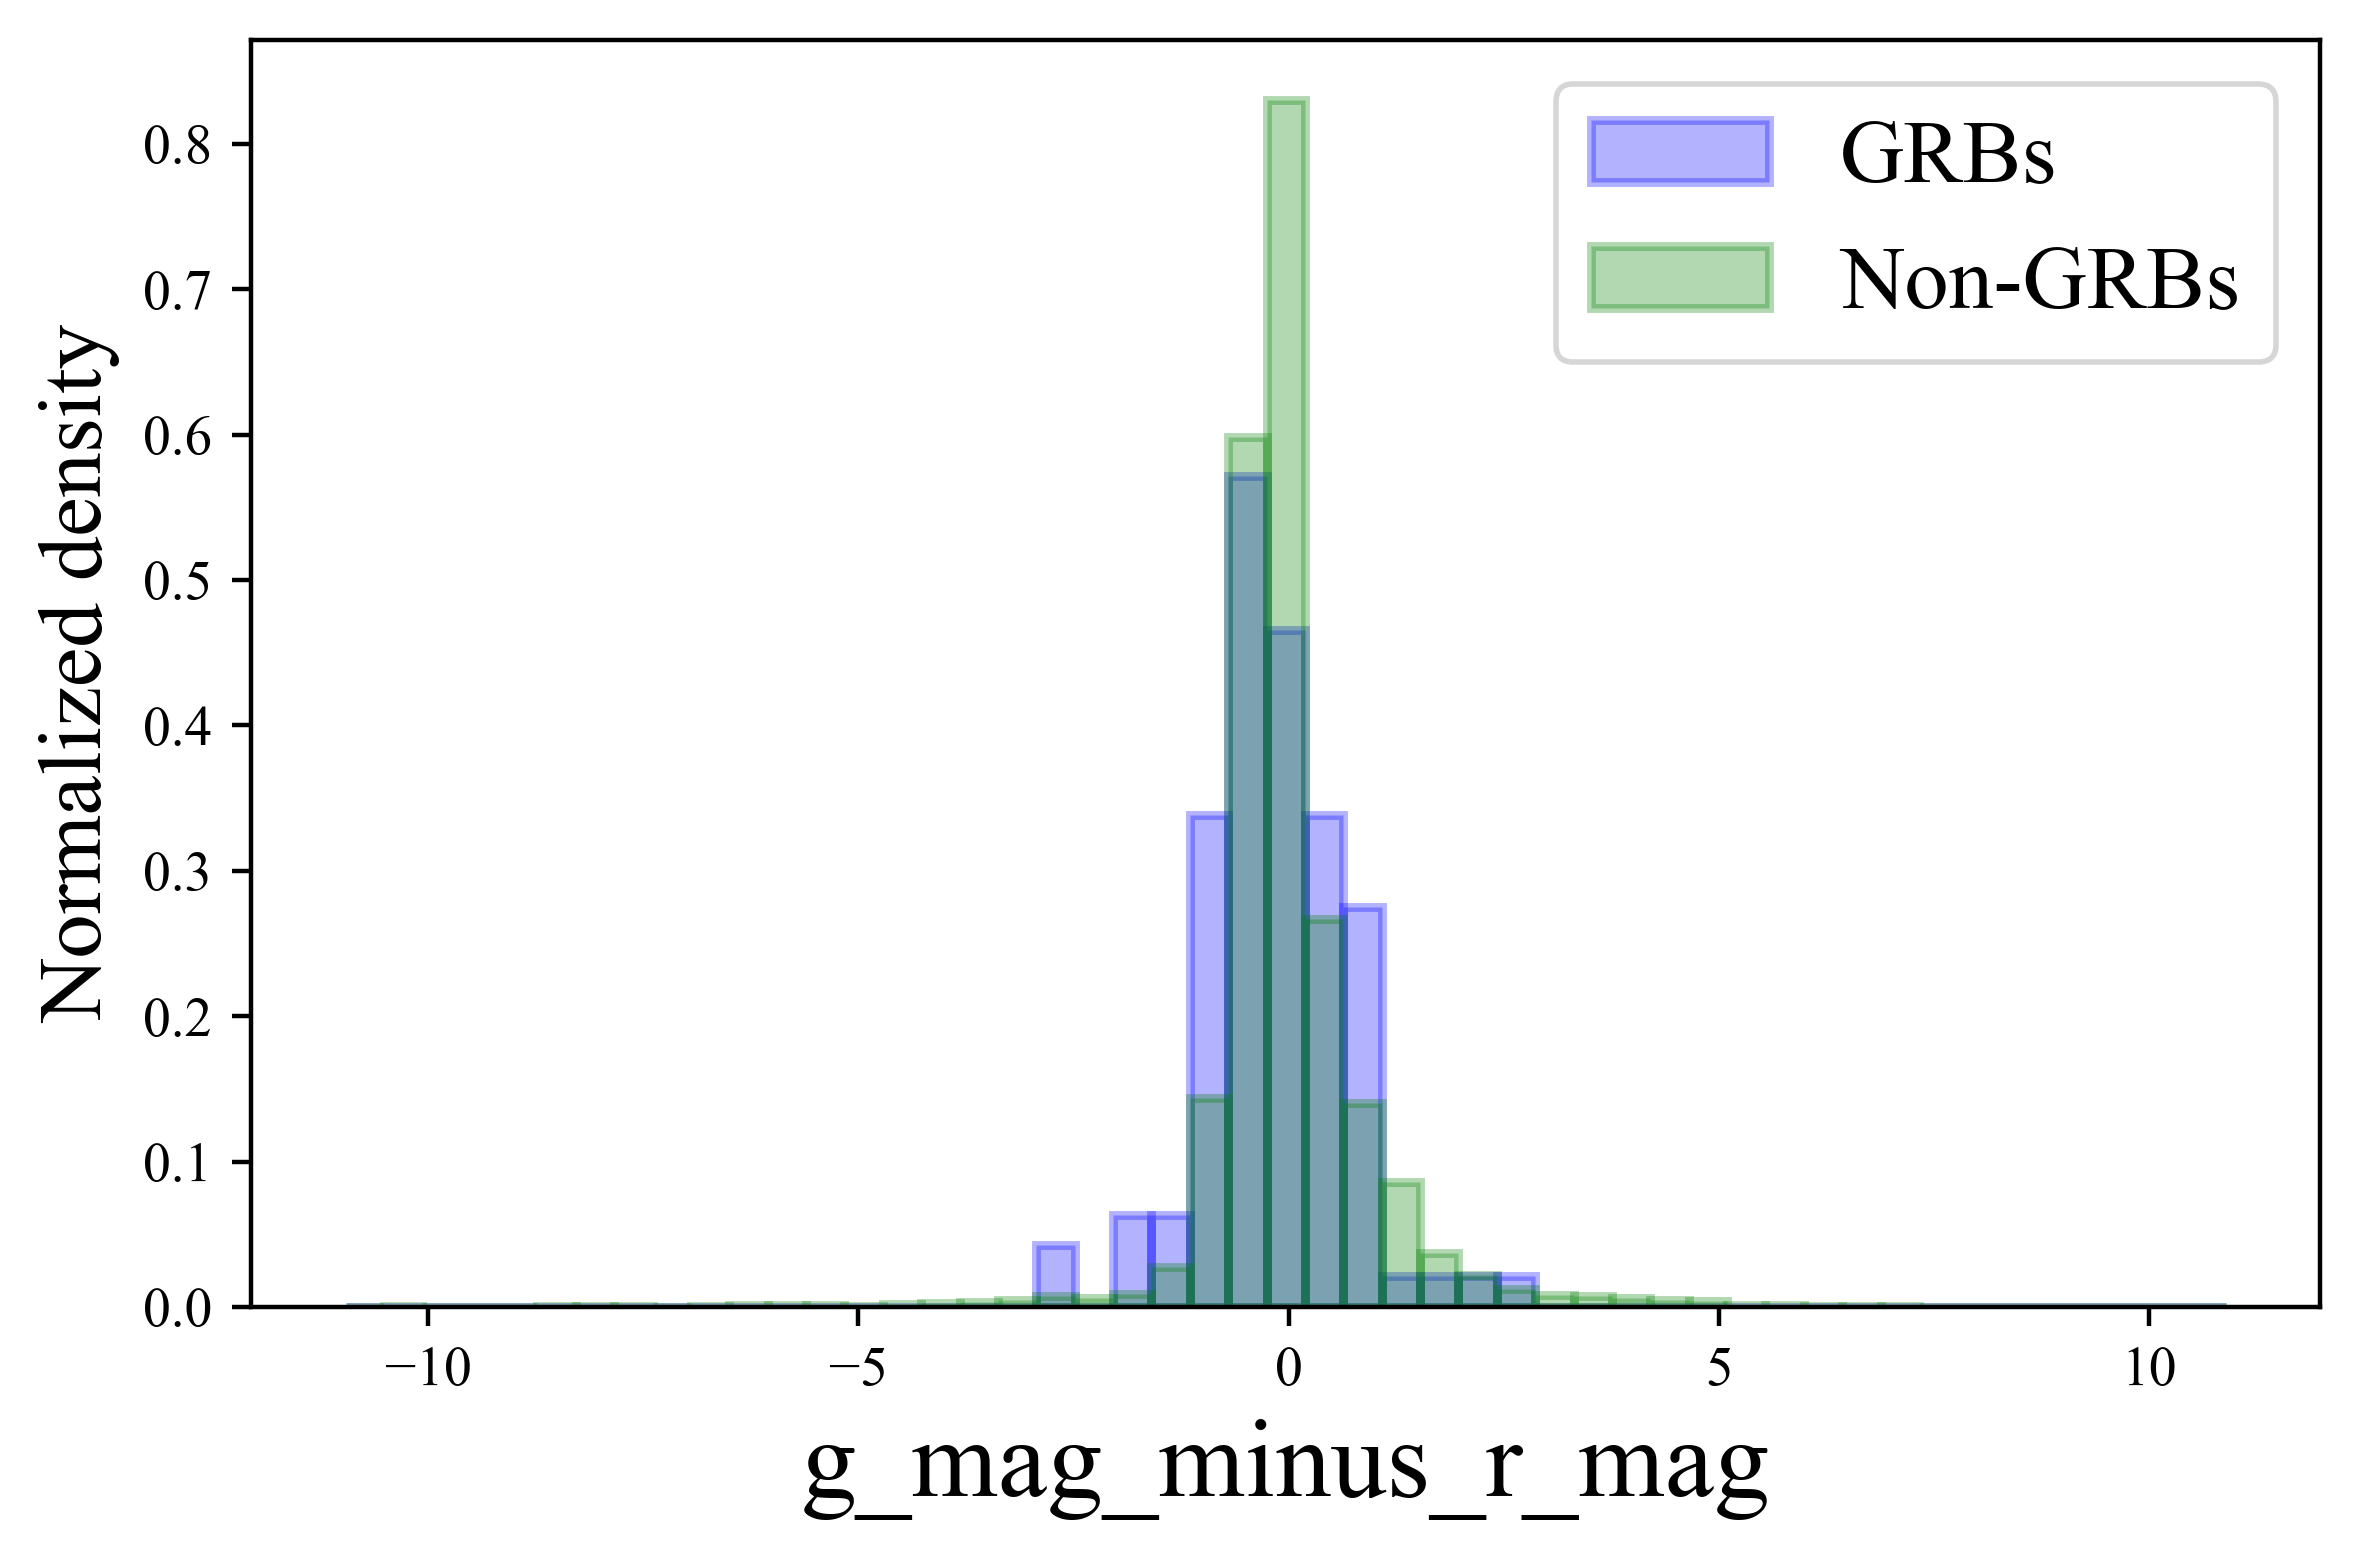



Feature: J_mag_minus_H_mag
Distributions ARE different.


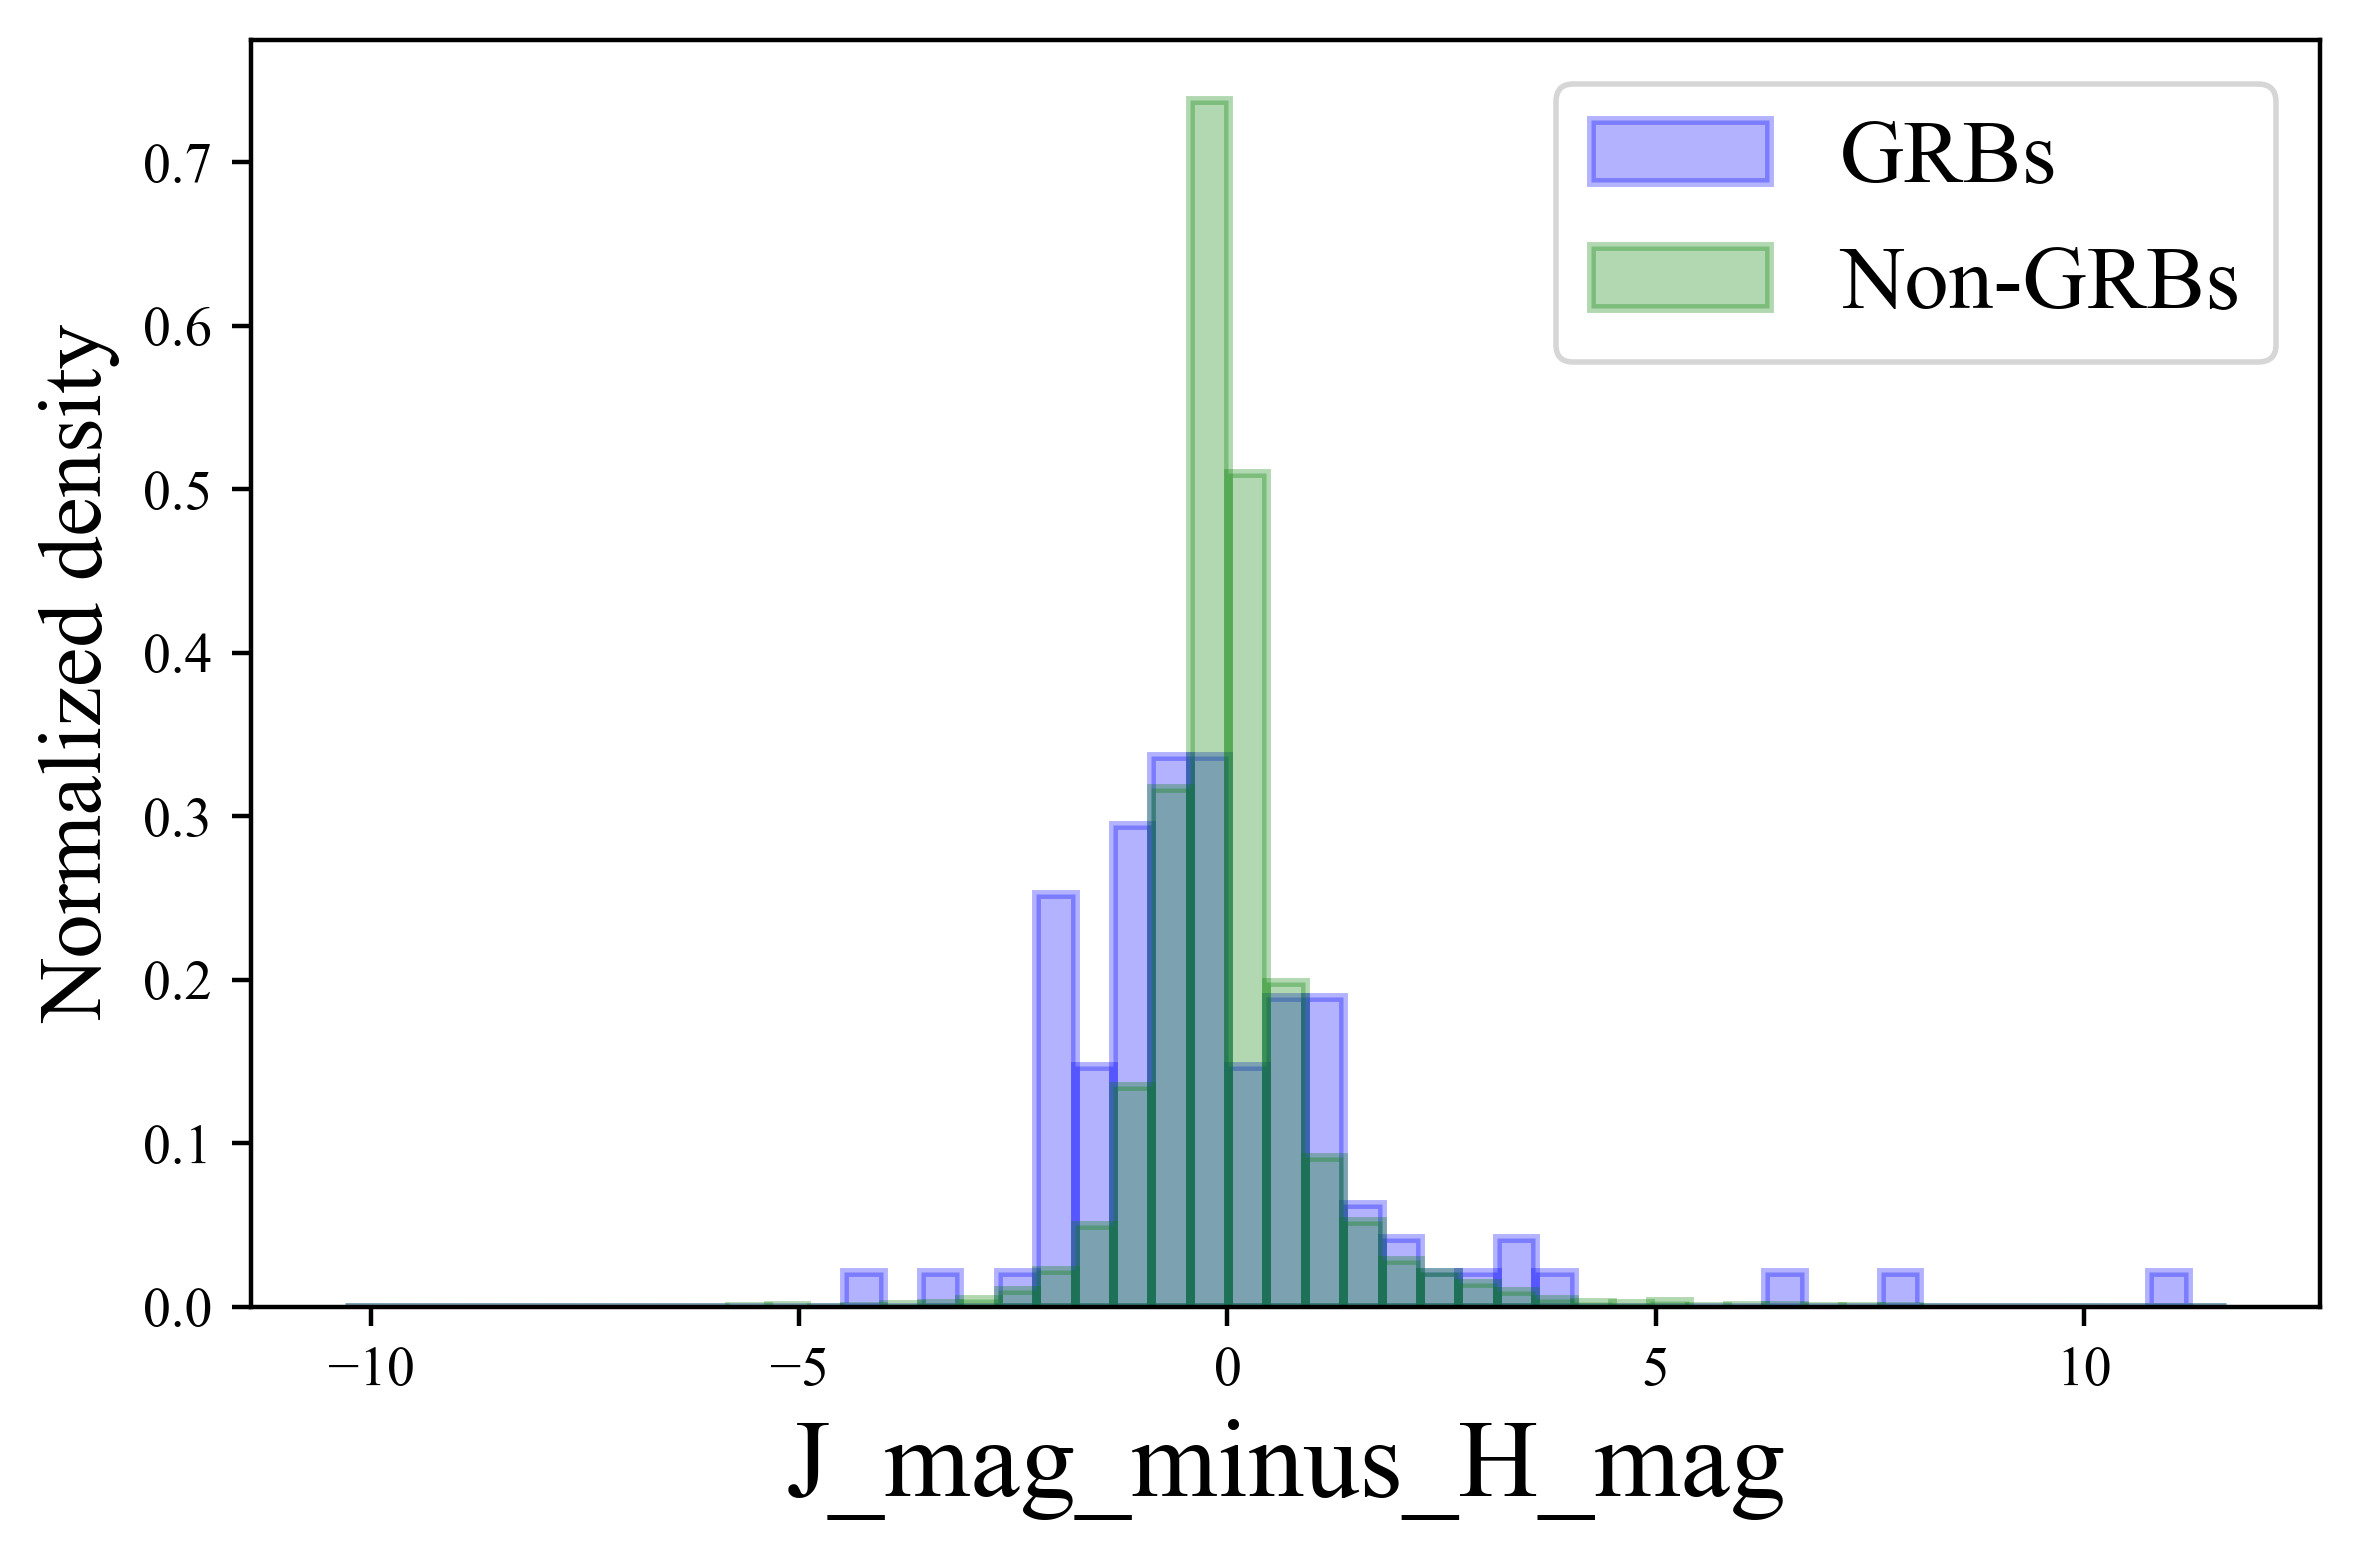



Feature: K_mag_minus_W1_mag
Distributions ARE different.


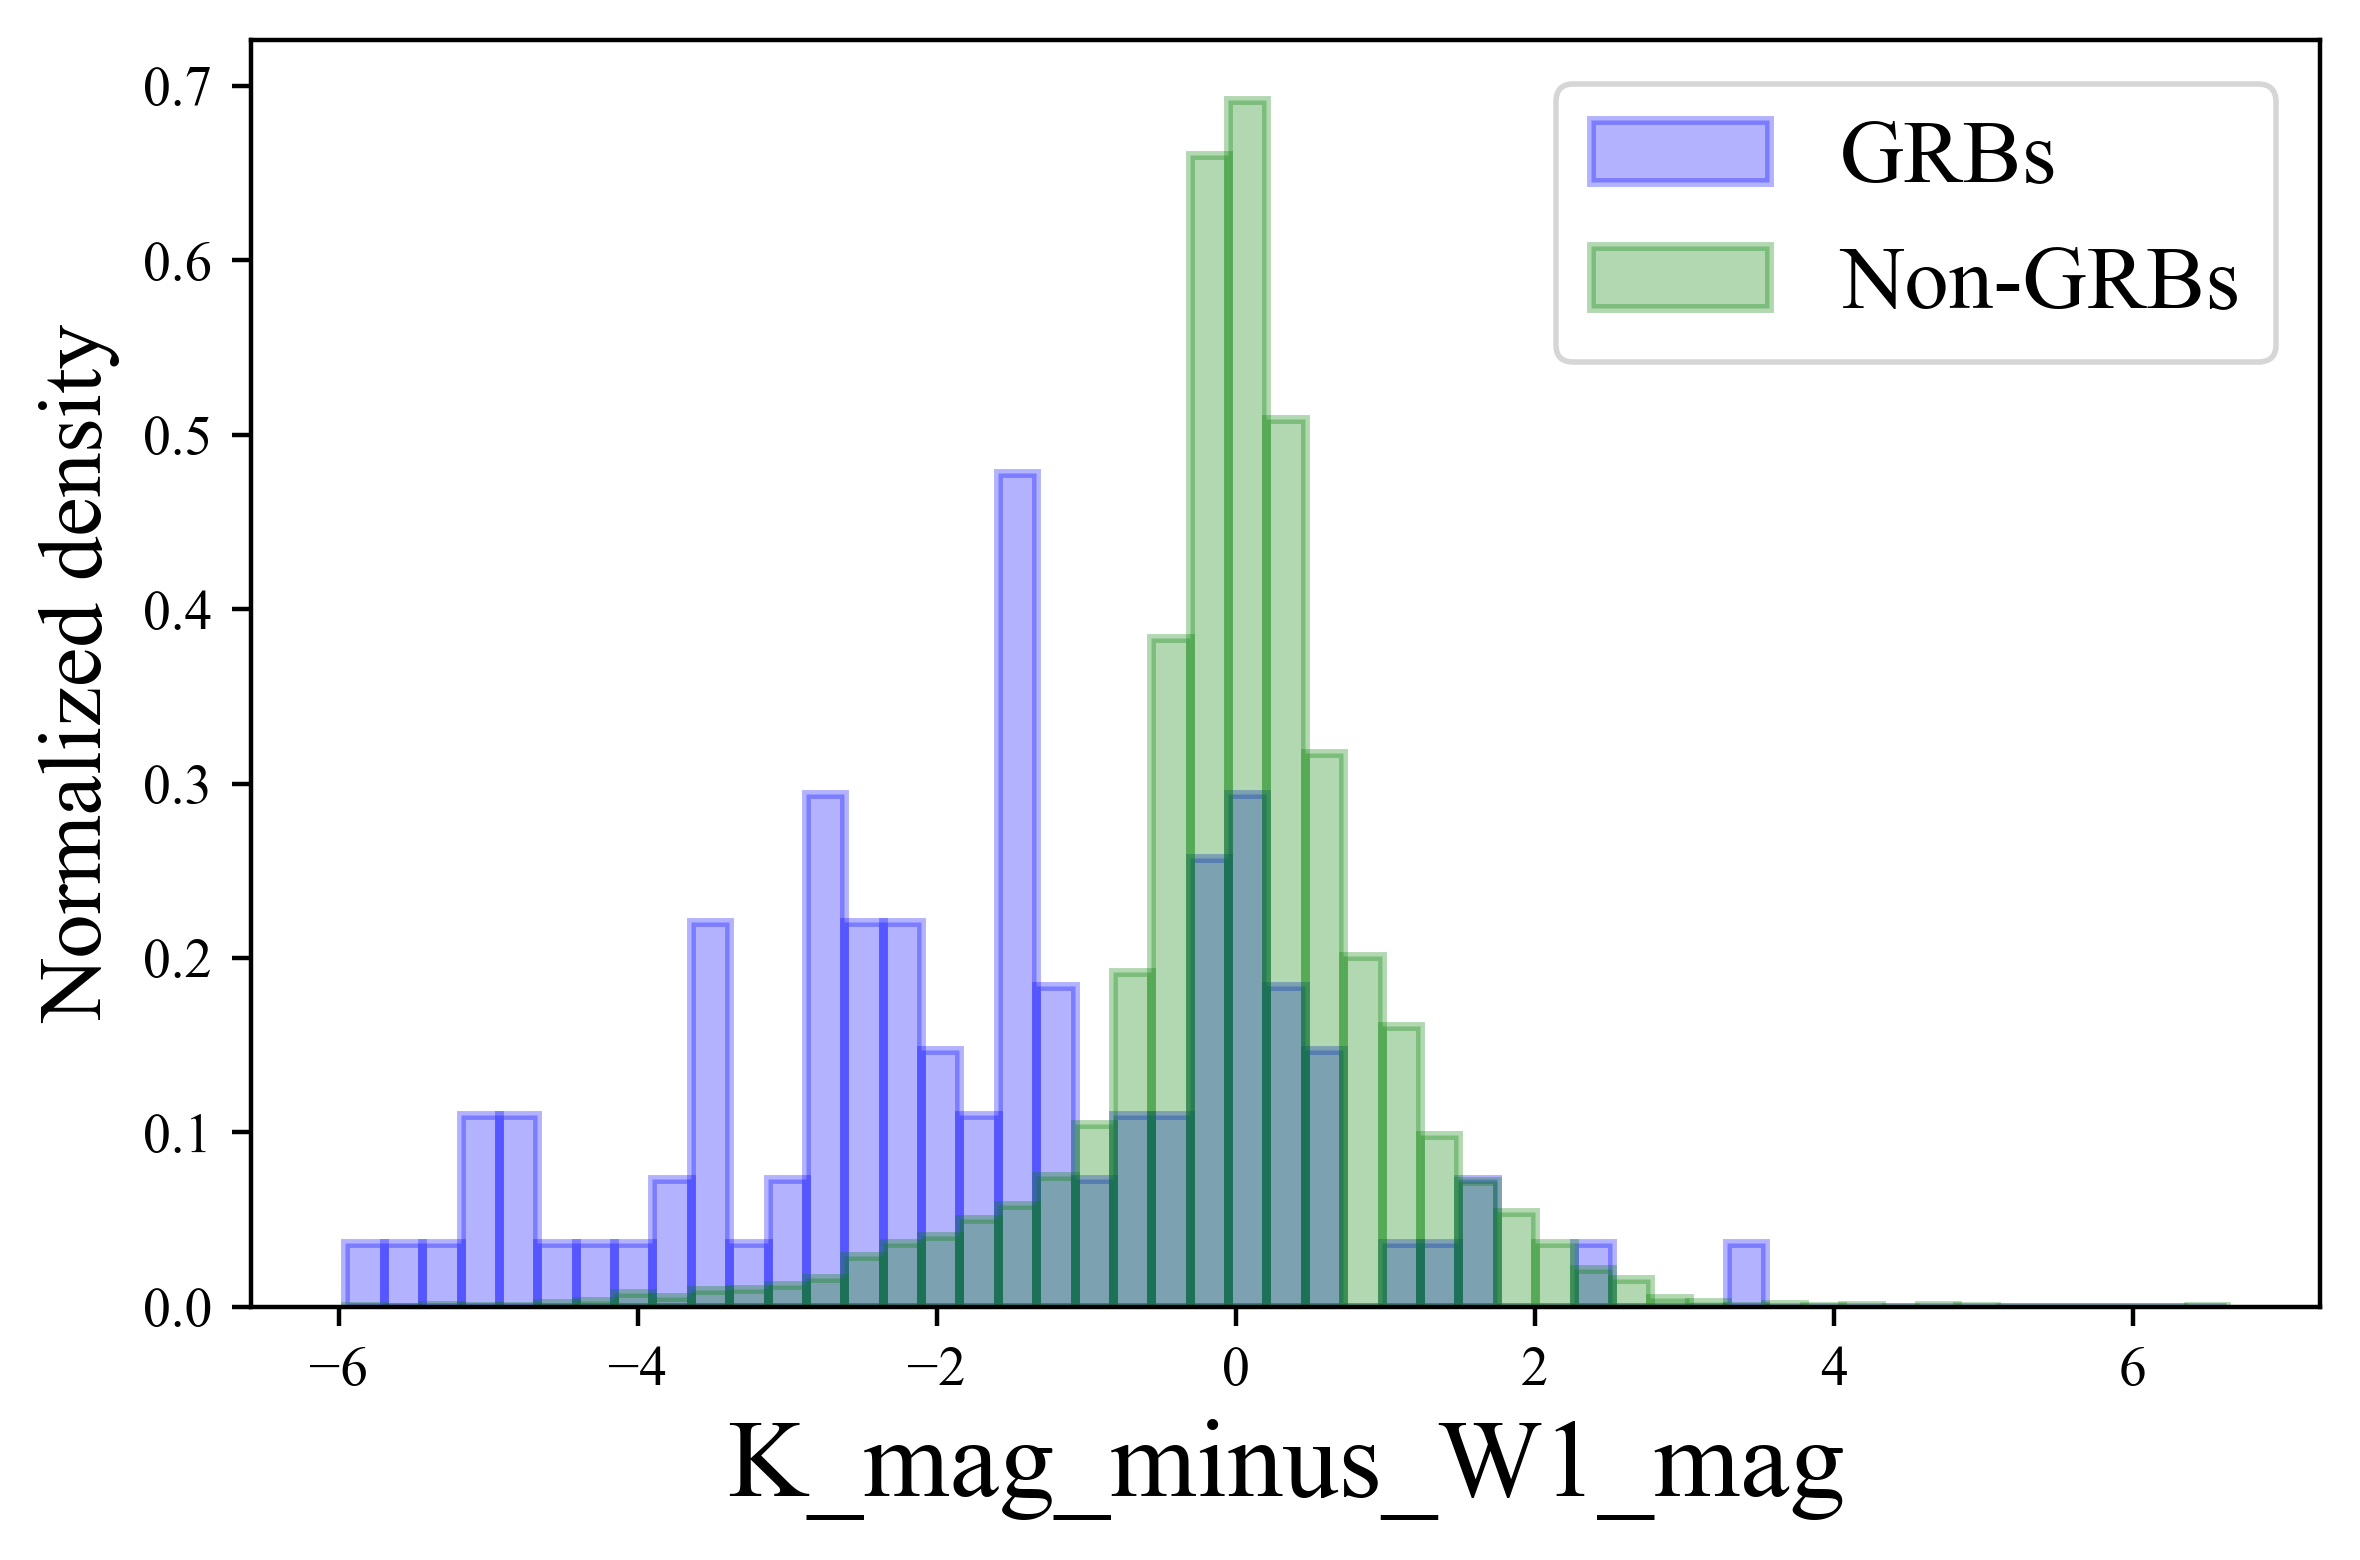



Feature: W1_mag_minus_W2_mag
Distributions ARE different.


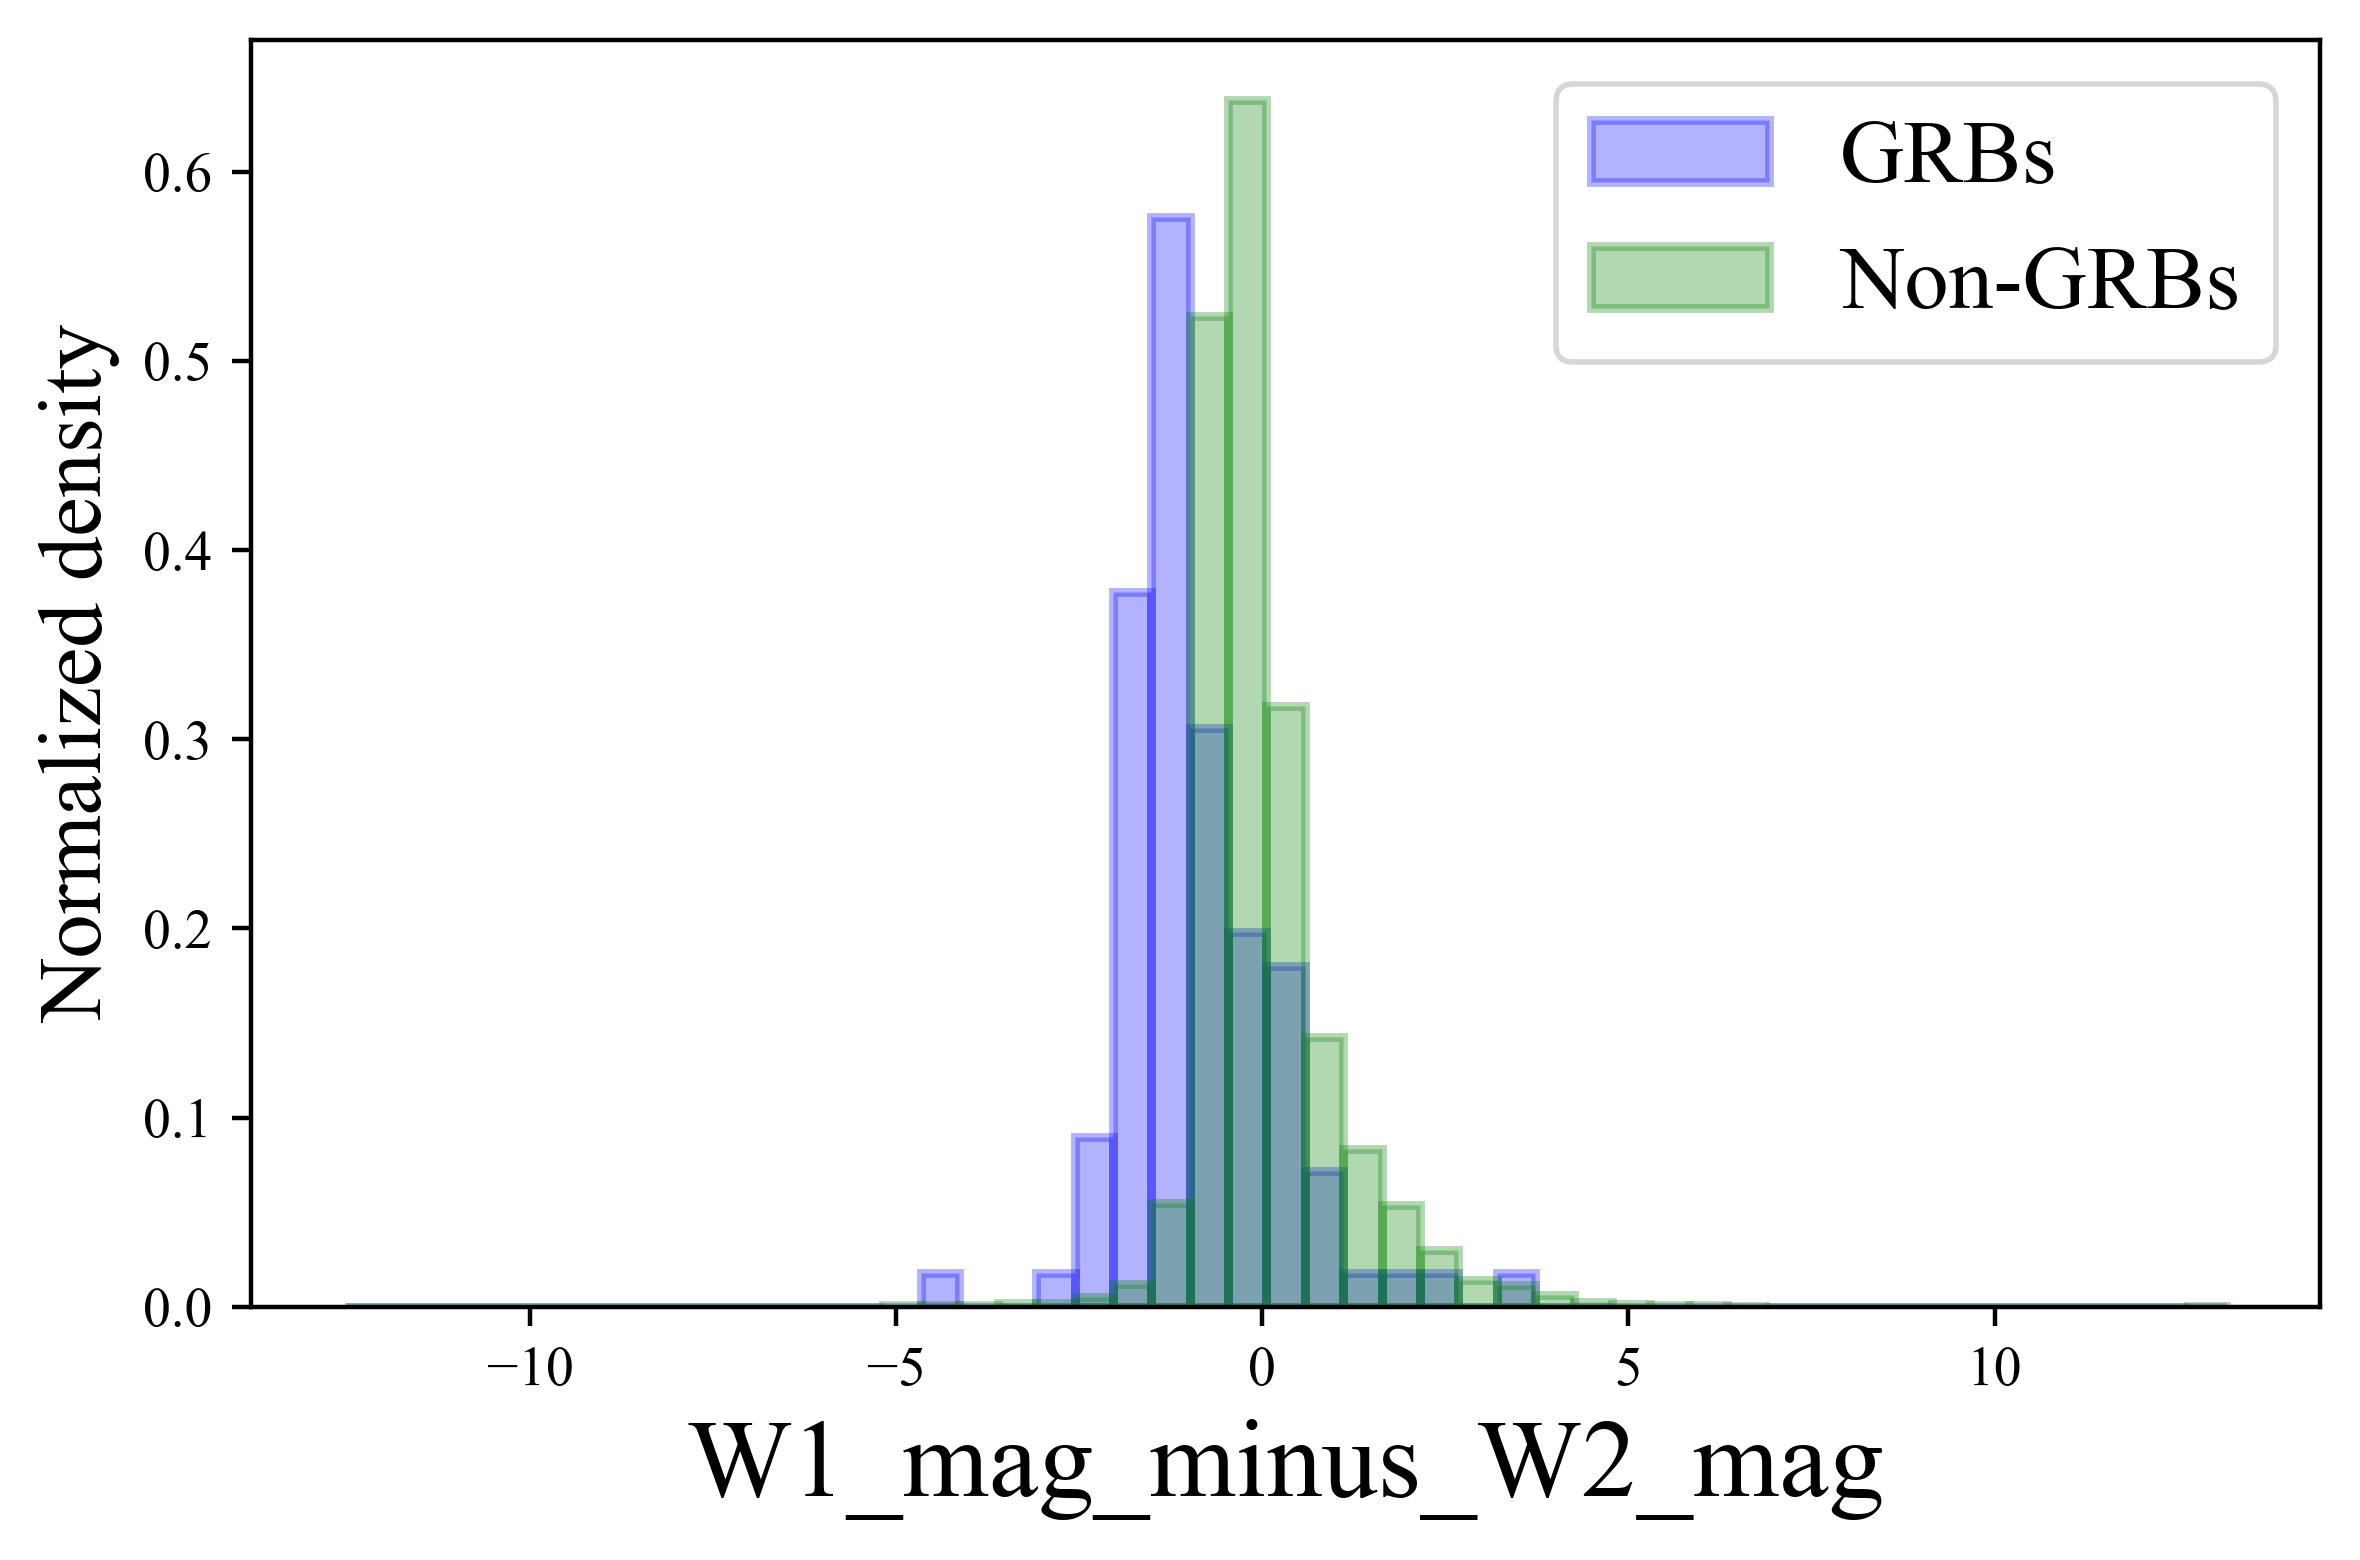



Feature: r_mag_minus_i_mag
Distributions ARE different.


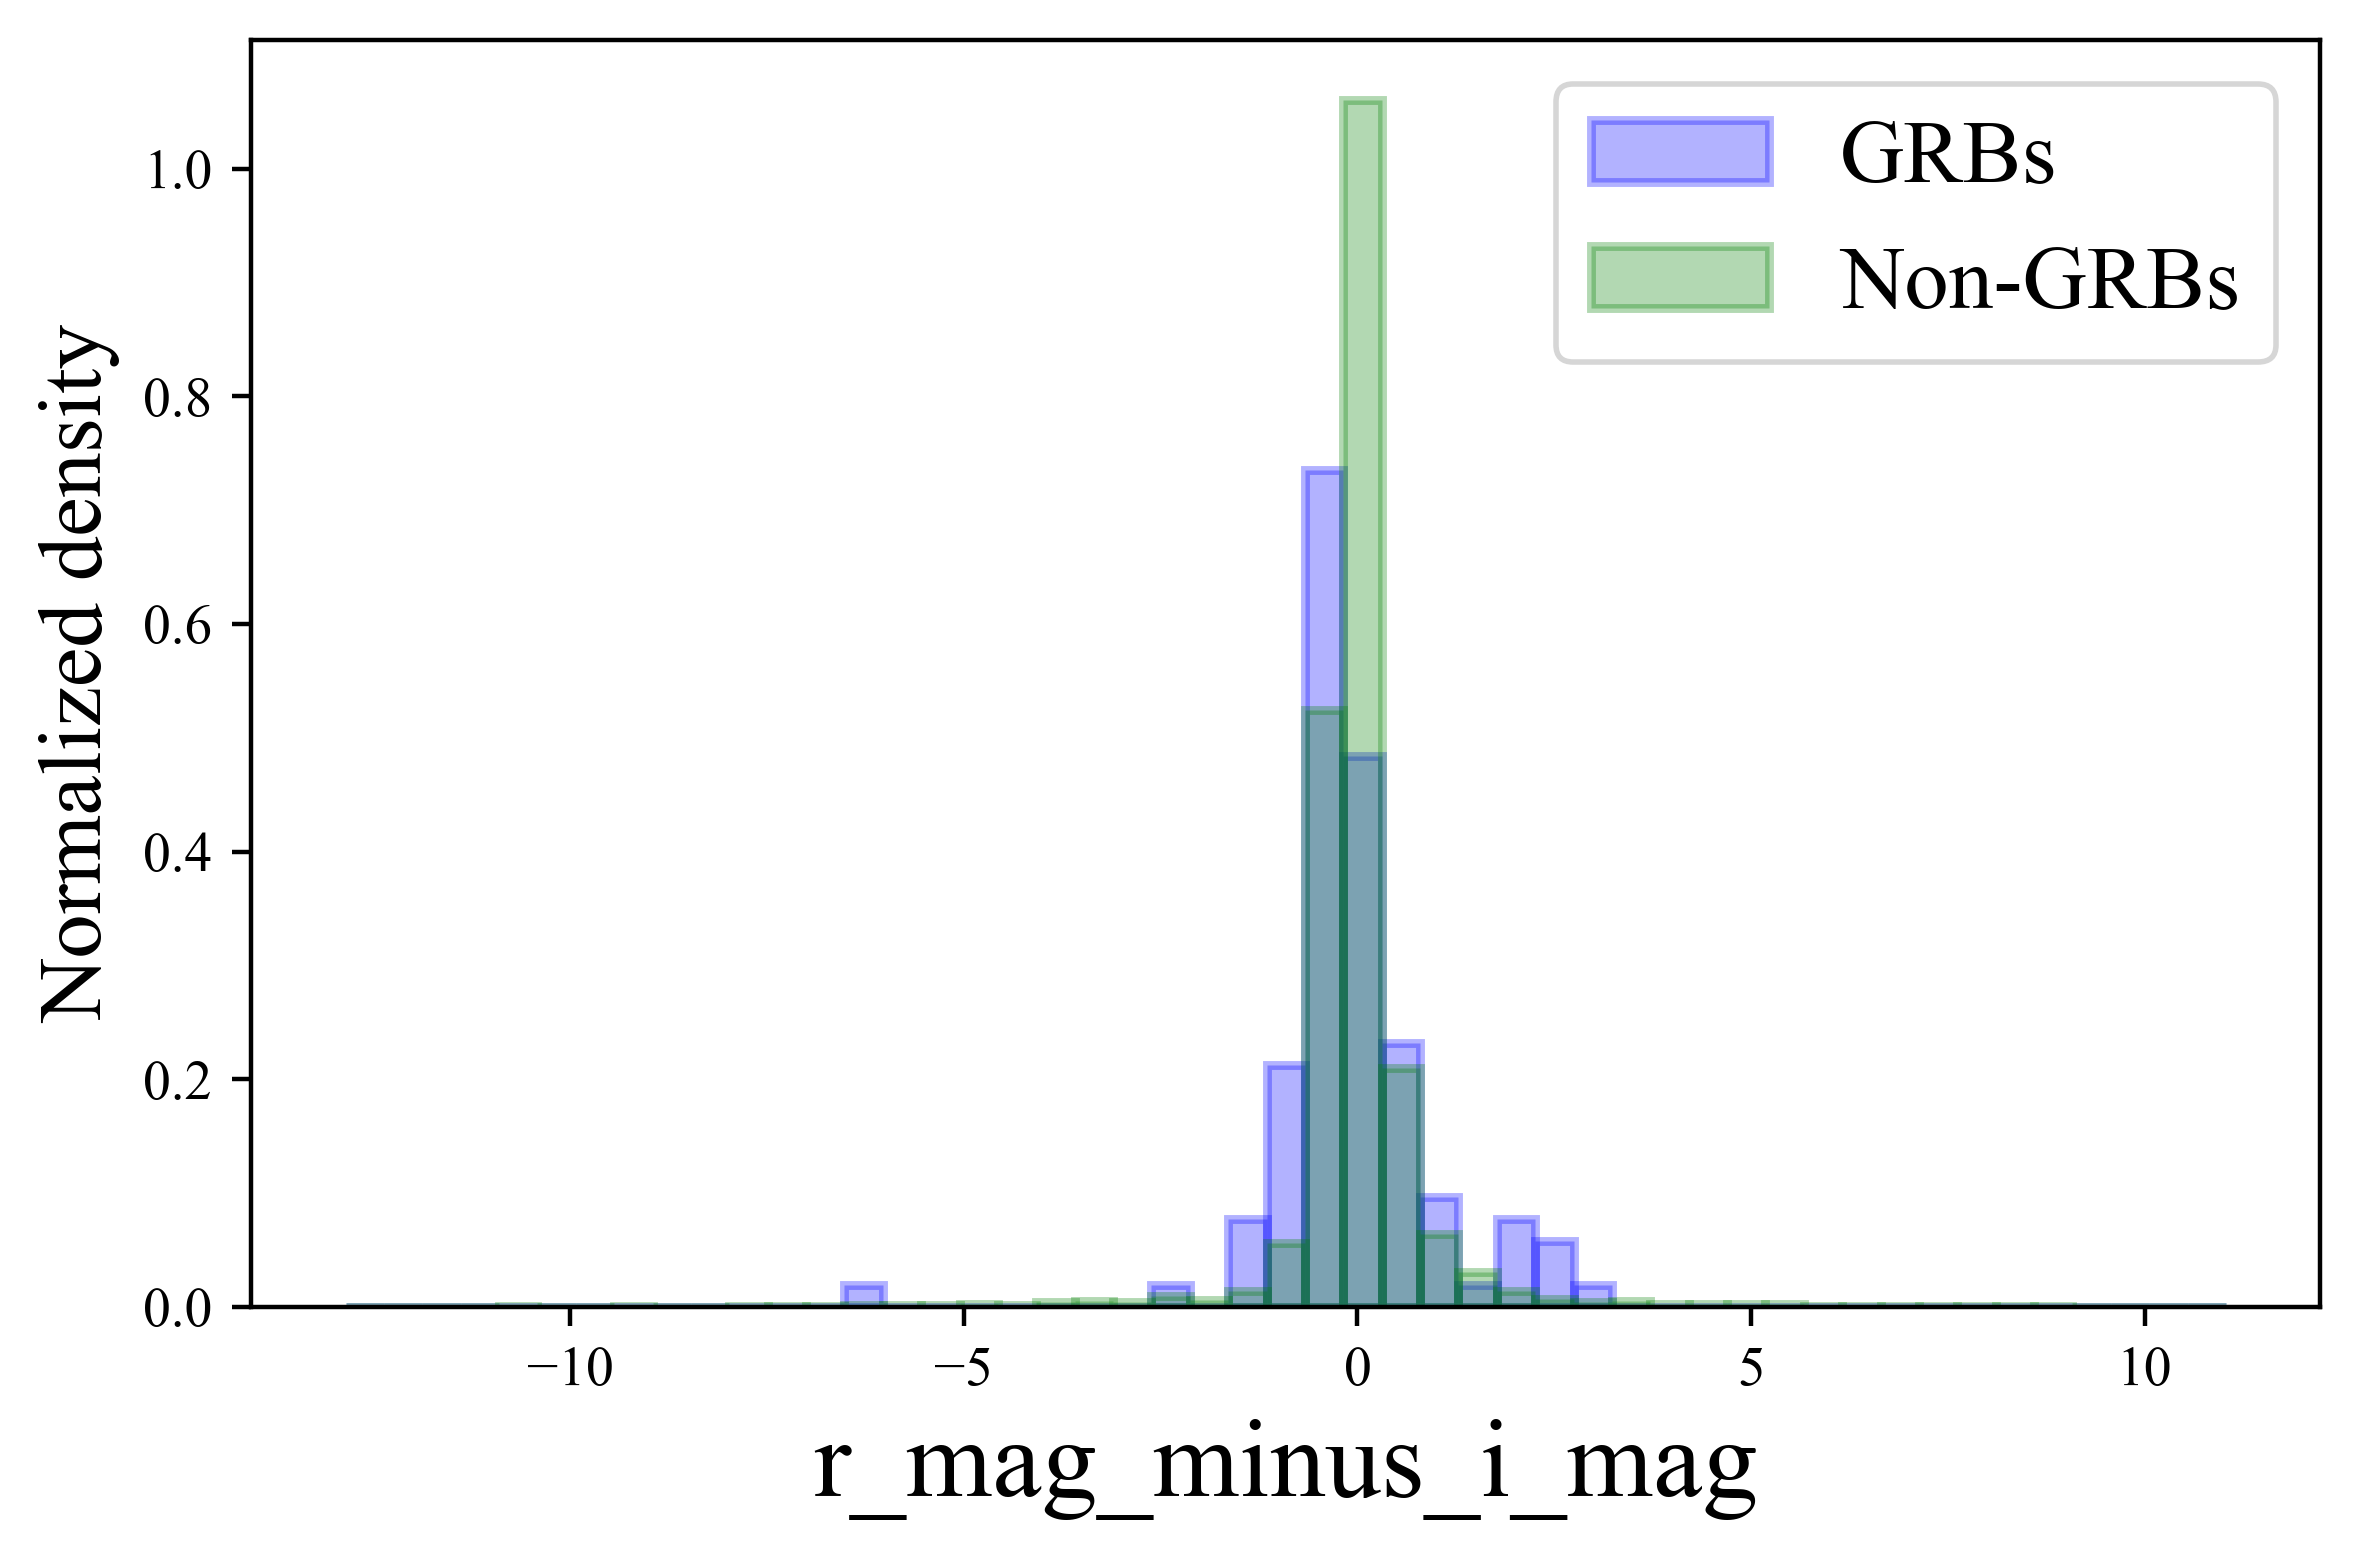



Feature: i_mag_minus_z_mag
Distributions ARE different.


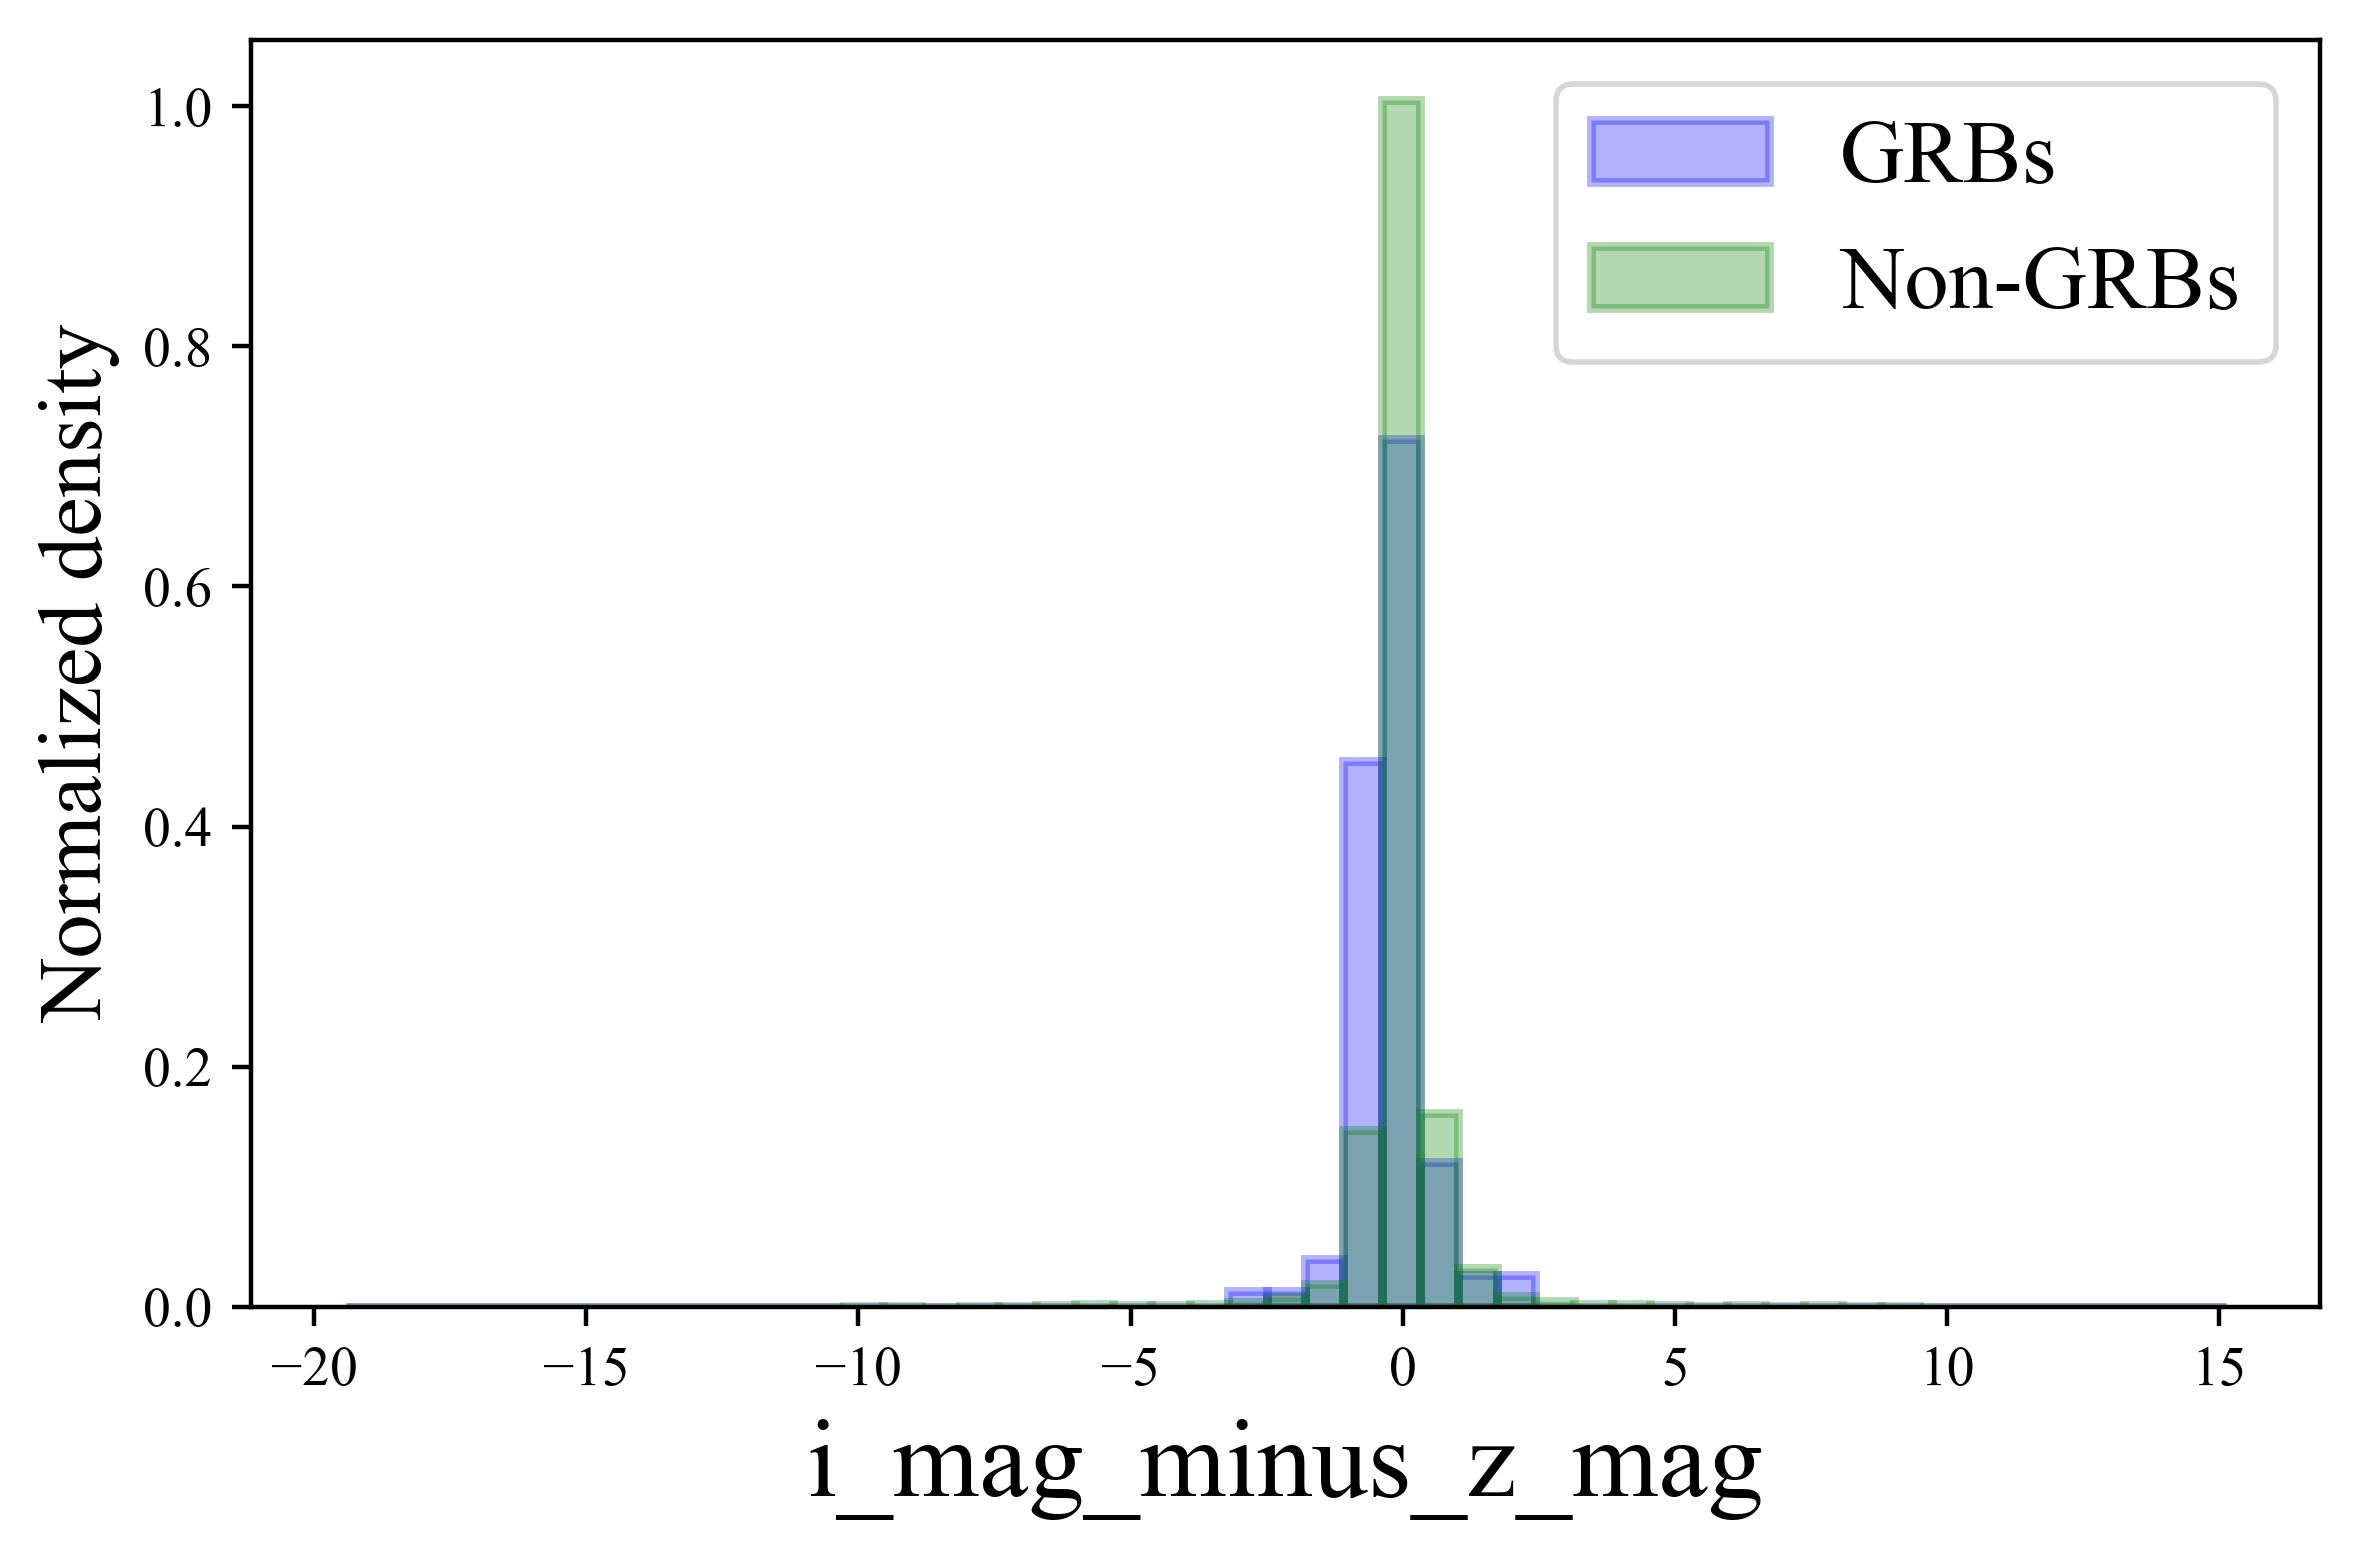


 The following feature are statistically different by KS-test:
{'y_mag': 0.2270089185676511, 'W1_mag': 0.28692540970136987, 'W2_mag': 0.30391289084091483, 'i_mag': 0.19831114895651264, 'z_mag': 0.20793931788643394, 'y_mag_minus_J_mag': 0.48626361314032174, 'H_mag_minus_K_mag': 0.20014864279418576, 'z_mag_minus_y_mag': 0.2823690225429122, 'J_mag_minus_H_mag': 0.26851125651712754, 'K_mag_minus_W1_mag': 0.5588688955616307, 'W1_mag_minus_W2_mag': 0.5422138066000388, 'r_mag_minus_i_mag': 0.2899561541104588, 'i_mag_minus_z_mag': 0.2858666098985644}


In [173]:
y_test_label[:,len(model.class_labels)]

y_r = cust_relabel(y_test_label[:,len(model.class_labels)], model.class_labels)

full_df = X_test.copy()
full_df[TARGET_LABEL] =y_r 
import matplotlib.pyplot as plt

# Plot feature dists  
features_D = {}
for feature in list(X_test):
    print("\n\nFeature: " + str(feature))
    min_value = X_test[feature].min()
    max_value = X_test[feature].max()
    bins = np.linspace(min_value, max_value, 50) 
    
    f, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400) 
    D = plot_binary_classes_feature_dist(ax, full_df, feature, min_value, max_value, "GRB")
    
    if D is not None:
        features_D[feature] = D
    # Plot TP GRBs 
#     TPs = X_test.loc[TP_GRBs_indices, :][feature].values
#     ax.hist(TPs, bins, density=True, edgecolor='black', linewidth=1.2,label="TP GRB", facecolor='none')
#     facecolor='black',alpha=0.3,
#     plot_dist(ax,TPs , min_value, max_value, "black", "TP GRB")
    
    # Plot FN GRBs
#     FNs = X_test.loc[FN_GRBs_indices, :][feature].values
#     ax.hist(TPs, bins, density=True, edgecolor='orange', linewidth=1.1, label="FN GRB", facecolor='none')
# facecolor='orange',alpha=0.3,
    #     plot_dist(ax, X_test.loc[FN_GRBs_indices, :][feature].values, min_value, max_value, "red", "FN GRB")
    
    plt.xlabel(feature, fontsize=20)
    plt.ylabel("Normalized density", fontsize=16)
    plt.legend(loc='best', fontsize=16)
    util.display_and_save_plot(model.dir, "feature_" + str(feature))
print("\n The following feature are statistically different by KS-test:")
print(features_D)

In [159]:
len(list(X_test))

19

In [157]:
sorted_Ds = sorted(features_D.values())
sorted_Ds.reverse()
sorted_Vs = []
for t_D in sorted_Ds:
    for k in features_D.keys():
        if features_D[k] == t_D:
            sorted_Vs.append(k)
            break
    
sorted_Vs

['K_mag_minus_W1_mag',
 'W1_mag_minus_W2_mag',
 'y_mag_minus_J_mag',
 'W2_mag',
 'r_mag_minus_i_mag',
 'W1_mag',
 'i_mag_minus_z_mag',
 'z_mag_minus_y_mag',
 'J_mag_minus_H_mag',
 'y_mag',
 'z_mag',
 'H_mag_minus_K_mag',
 'i_mag']

In [158]:
for i in sorted_Vs:
    print(i)

K_mag_minus_W1_mag
W1_mag_minus_W2_mag
y_mag_minus_J_mag
W2_mag
r_mag_minus_i_mag
W1_mag
i_mag_minus_z_mag
z_mag_minus_y_mag
J_mag_minus_H_mag
y_mag
z_mag
H_mag_minus_K_mag
i_mag


In [ ]:
collect_data(data_file)



In [ ]:
mini_col_list =["g_mag",  "r_mag", "i_mag"]
data_filters= {'cols': mini_col_list,  # Names of columns to filter on; default is all numeric cols
                        'col_matches': None,  # String by which columns will be selected
                        'num_runs': None,  # Number of trials
                        'folds': 10,  # Number of folds if using k-fold Cross Validation
                        'transform_features': False,  # Derive mag colors & scale
                        'min_class_size': 40,
                        'max_class_size': None,
                        'pca': None,  # Number of principal components
                        'class_labels': None,
                        'data': None,  # [X,y] data, as PD dataframes.
                        'nb': False,  # Naive Bayes multiclass
                        'priors': False,  # Priors, boolean
                        'data_file': DATA_PATH,  # Default data file used
                        'linear_calib': False,
                        'lsst_test': False,  # if True, groups Ib/c, Ib, and Ic as Ib/c
                        'Zmodel': False,
                        'balanced_purity': True
                        }

In [ ]:
from thex_data.data_prep import get_source_target_data

FULL_X, FULL_y = get_source_target_data(mini_col_list, data_filters)
# get_data(mini_col_list, data_filters)

In [ ]:
FULL_GRBS_indices = FULL_y.loc[FULL_y['transient_type'].str.contains("GRB")].index

In [ ]:
FULL_X_GRBs = FULL_X.iloc[FULL_GRBS_indices]

In [ ]:
FULL_X_GRBs['r_mag'].unique()

KS test stats


In [ ]:
from scipy.stats import kstest
import math
obs1 = [2,3,2,5,2,1,3,2,2]
obs2 = [6,7,6,6,6,7,8,3,6] 

In [ ]:
D, pvalue = kstest(obs1, obs2)
c_alpha = 1.358 # 0.05, 95% confidence
v = c_alpha * math.sqrt((len(obs1) + len(obs2))/(len(obs1) * len(obs2)))
if D > v:
    print("Distributions ARE different.")
    
print("Stat: " + str(stat))
print("Pvalue: " + str(pvalue))